# Introduction

- **session_id** - the ID of the session the event took place in
- **index** - the index of the event for the session
- **elapsed_time** - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- **event_name** - the name of the event type
- **name** - the event name (e.g. identifies whether a notebook_click is opening or closing the notebook)
- **level** - what level of the game the event occurred in (0 to 22)
- **page** - the page number of the event (only for notebook-related events)
- **room_coor_x** - the coordinates of the click in reference to the in-game room (only for click events)
- **room_coor_y** - the coordinates of the click in reference to the in-game room (only for click events)
- **screen_coor_x** - the coordinates of the click in reference to the player’s screen (only for click events)
- **screen_coor_y** - the coordinates of the click in reference to the player’s screen (only for click events)
- **hover_duration** - how long (in milliseconds) the hover happened for (only for hover events)
- **text** - the text the player sees during this event
- **fqid** - the fully qualified ID of the event
- **room_fqid** - the fully qualified ID of the room the event took place in
- **text_fqid** - the fully qualified ID of the
- **fullscreen** - whether the player is in fullscreen mode
- **hq** - whether the game is in high-quality
- **music** - whether the game music is on or off
- **level_group** - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Train

## Data

In [3]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time': np.int32,
    'event_name': 'category',
    'name': 'category',
    'level': np.uint8,
    'room_coor_x': np.float32,
    'room_coor_y': np.float32,
    'screen_coor_x': np.float32,
    'screen_coor_y': np.float32,
    'hover_duration': np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid': 'category',
    'text_fqid': 'category',
    'fullscreen': 'category',
    'hq': 'category',
    'music': 'category',
    'level_group': 'category'
}

train_data = pd.read_csv('../data/train.csv', dtype=dtypes)

In [4]:
## Reference: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data?scriptVersionId=118573291&cellId=15
def summarize_data_info(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame(df.dtypes, columns=['data_type'])
    
    summary['perc_missing'] = df.isnull().sum().values * 100
    summary['perc_missing'] = df.isnull().sum().values / len(df)
    summary['n_unique'] = df.nunique().values
    
    summary['first_value'] = df.loc[0].values
    summary['second_value'] = df.loc[1].values
    summary['third_value'] = df.loc[2].values
    
    df_describe = pd.DataFrame(df.describe(include='all').transpose())
    summary['min'] = df_describe['min'].values
    summary['max'] = df_describe['max'].values
    
    print(f'Data Shape: {df.shape}')
    
    return summary

In [5]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int64      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level              uint8      0.000000        23   
page             float64      0.978532         7   
room_coor_x      float32      0.078841  12538215   
room_coor_y      float32      0.078841   9551136   
screen_coor_x    float32      0.078841     57477   
screen_coor_y    float32      0.078841    102591   
hover_duration   float32      0.923860     24101   
text            category      0.634287       597   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                              0   
page                                             NaN   
room_coor_x                              -413.991394   
room_coor_y                              -159.314682   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                           0   
page                                                          NaN   
room_coor_x                                           -413.991394   
room_coor_y                                           -159.314682   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

In [6]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [7]:
train_data = reduce_memory_usage(train_data)

Memory usage of dataframe is 1529.83 MB
Memory usage became:  1053.3384094238281  MB


In [8]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000        23   
page             float16      0.978532         7   
room_coor_x      float16      0.078841     29854   
room_coor_y      float16      0.078841     27847   
screen_coor_x    float16      0.078841      6866   
screen_coor_y    float16      0.078841      5188   
hover_duration   float32      0.923860     24101   
text            category      0.634287       597   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

### `Text` Field Preprocessing

In [9]:
from typing import Dict

def preprocess_text_str(text_str: str) -> str:
    s = str(text_str).replace("\\", "")
    text_str_ = "undefined" if s.startswith("u0") or (s in ["undefined", "nan"]) else s
    
    text_str__clean = text_str_.split("u0")[0] if "u0" in text_str_ else text_str_ 
    
    return text_str__clean

def create_text_field__clean_dict(data: pd.DataFrame(), text_field: str) -> Dict:
    text_values = list(data[text_field].unique())
    text_values_ = [preprocess_text_str(s) for s in text_values]
    
    text_field__clean_dict = dict(zip(text_values, text_values_))
    
    return text_field__clean_dict

def map_text_field(data: pd.DataFrame, text_field: str, text_field__clean_dict: Dict) -> pd.DataFrame:
    data[text_field] = data[text_field].map(text_values__clean_dict).fillna("undefined")
    
    return data

def recategorize_category_typed_fields(data: pd.DataFrame) -> pd.DataFrame:
    for field_name, dtype in data.dtypes.items():
        if dtype == "category":
            data[field_name] = data[field_name].astype(str).astype("category")
            
    return data

In [10]:
text_values = list(train_data["text"].unique())
text_values[:20]

['undefined',
 'Whatcha doing over there, Jo?',
 'Just talking to Teddy.',
 'I gotta run to my meeting!',
 'Can I come, Gramps?',
 'Sure thing, Jo. Grab your notebook and come upstairs!',
 'See you later, Teddy.',
 "I get to go to Gramps's meeting!",
 'Now where did I put my notebook?',
 '\\u00f0\\u0178\\u02dc\\u00b4',
 nan,
 'I love these photos of me and Teddy!',
 'Found it!',
 'Gramps is in trouble for losing papers?',
 "This can't be right!",
 'Gramps is a great historian!',
 "Hmm. Button's still not working.",
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
 'Who wants to investigate the shirt artifact?',
 "Not Leopold here. He's been losing papers lately."]

In [11]:
text_values_ = [preprocess_text_str(s) for s in text_values]
text_values_[:20]

['undefined',
 'Whatcha doing over there, Jo?',
 'Just talking to Teddy.',
 'I gotta run to my meeting!',
 'Can I come, Gramps?',
 'Sure thing, Jo. Grab your notebook and come upstairs!',
 'See you later, Teddy.',
 "I get to go to Gramps's meeting!",
 'Now where did I put my notebook?',
 'undefined',
 'undefined',
 'I love these photos of me and Teddy!',
 'Found it!',
 'Gramps is in trouble for losing papers?',
 "This can't be right!",
 'Gramps is a great historian!',
 "Hmm. Button's still not working.",
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
 'Who wants to investigate the shirt artifact?',
 "Not Leopold here. He's been losing papers lately."]

In [12]:
text_field__clean_dict = dict(zip(text_values, text_values_))
train_data["text"] = train_data["text"].map(text_field__clean_dict).fillna("undefined").astype('category')

In [13]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000        23   
page             float16      0.978532         7   
room_coor_x      float16      0.078841     29854   
room_coor_y      float16      0.078841     27847   
screen_coor_x    float16      0.078841      6866   
screen_coor_y    float16      0.078841      5188   
hover_duration   float32      0.923860     24101   
text            category      0.000000       587   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

### Train Labels

In [14]:
train_labels = pd.read_csv("../data/train_labels.csv")

In [15]:
summary = summarize_data_info(train_labels)
summary

Data Shape: (424116, 2)


data_type  perc_missing  n_unique           first_value  \
session_id    object           0.0    424116  20090312431273200_q1   
correct        int64           0.0         2                     1   

                    second_value           third_value  min  max  
session_id  20090312433251036_q1  20090312455206810_q1  NaN  NaN  
correct                        0                     1  0.0  1.0

In [16]:
train_labels['question_no'] = train_labels['session_id'].apply(lambda x: int(x.split('_')[-1][1:]))
train_labels['session_id'] = train_labels['session_id'].apply(lambda x: int(x.split('_')[0]) )

train_labels["session_id"].nunique()

23562

In [17]:
summary = summarize_data_info(train_labels)
summary

Data Shape: (424116, 3)


data_type  perc_missing  n_unique        first_value  \
session_id      int64           0.0     23562  20090312431273200   
correct         int64           0.0         2                  1   
question_no     int64           0.0        18                  1   

                  second_value        third_value           min           max  
session_id   20090312433251036  20090312455206810  2.009031e+16  2.210022e+16  
correct                      0                  1  0.000000e+00  1.000000e+00  
question_no                  1                  1  1.000000e+00  1.800000e+01

#### Validity check >>> Train Labels

In [18]:
train_labels.groupby("session_id")["question_no"].nunique().value_counts()

18    23562
Name: question_no, dtype: int64

In [19]:
question_no__list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
len(train_labels[~train_labels["question_no"].isin(question_no__list)])

0

In [20]:
len(train_labels) == (23562 * 18)

True

#### Validity check >>> Session ids in datasets

In [21]:
train_data__session_id_unique_vals = train_data["session_id"].drop_duplicates().sort_values().reset_index(drop=True)
train_labels__session_id_unique_vals = train_labels["session_id"].drop_duplicates().sort_values().reset_index(drop=True)

pd.testing.assert_series_equal(train_data__session_id_unique_vals, train_labels__session_id_unique_vals)

### Downsampling

In [22]:
session_ids = sorted(train_labels["session_id"].unique())

np.random.seed(42)
np.random.shuffle(session_ids)

session_ids[:5]

[22010107585684490,
 20100413373831344,
 21000409261644490,
 20110314164224844,
 21080621495509370]

In [23]:
N_CHUNKS = 10

np.random.seed(42)
chunk_ids = np.random.randint(N_CHUNKS, size=len(session_ids))

session_chunk_df = pd.DataFrame({"session_id": session_ids, "chunk_id": chunk_ids})
session_chunk_df["chunk_id"].value_counts()

0    2418
9    2407
5    2395
6    2360
1    2358
2    2350
3    2347
7    2320
8    2311
4    2296
Name: chunk_id, dtype: int64

In [24]:
session_chunk_df["chunk_id"].nunique()

10

## Filter Data

### `level_group` == `"5-12"`

In [25]:
level_group = "5-12"
train_data__lg_filtered = train_data[train_data["level_group"] == level_group].drop(labels="level_group", axis=1).reset_index(drop=True)
train_data__lg_filtered.head()

session_id  index  elapsed_time      event_name       name  level  \
0  20090312431273200    175        221485  navigate_click  undefined    5.0   
1  20090312431273200    176        222334    person_click      basic    5.0   
2  20090312431273200    177        223251    person_click      basic    5.0   
3  20090312431273200    178        223735  navigate_click  undefined    5.0   
4  20090312431273200    179        224235  navigate_click  undefined    5.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN      280.500   -19.703125          653.0          321.0   
1   NaN      273.000   -19.234375          649.0          321.0   
2   NaN      240.875  -228.250000          628.0          459.0   
3   NaN      331.750  -220.625000          688.0          454.0   
4   NaN      404.250  -226.500000          716.0          454.0   

   hover_duration                                    text  fqid  \
0             NaN                               undefined  boss   
1             NaN  What are you still doing here,  Jolie?  boss   
2             NaN    Go find your grampa and get to work!  boss   
3             NaN                               undefined   NaN   
4             NaN                               undefined   NaN   

              room_fqid                               text_fqid fullscreen hq  \
0  tunic.capitol_0.hall                                     NaN          0  0   
1  tunic.capitol_0.hall  tunic.capitol_0.hall.boss.talktogramps          0  0   
2  tunic.capitol_0.hall  tunic.capitol_0.hall.boss.talktogramps          0  0   
3  tunic.capitol_0.hall                                     NaN          0  0   
4  tunic.capitol_0.hall                                     NaN          0  0   

  music  
0     1  
1     1  
2     1  
3     1  
4     1

In [26]:
summary = summarize_data_info(train_data__lg_filtered)
summary

Data Shape: (8844238, 19)


data_type  perc_missing  n_unique           first_value  \
session_id         int64      0.000000     23562     20090312431273200   
index              int16      0.000000     17893                   175   
elapsed_time       int32      0.000000   1866383                221485   
event_name      category      0.000000        11        navigate_click   
name            category      0.000000         6             undefined   
level            float16      0.000000         8                   5.0   
page             float16      0.979405         4                   NaN   
room_coor_x      float16      0.098495     26186                 280.5   
room_coor_y      float16      0.098495     22677            -19.703125   
screen_coor_x    float16      0.098495      5811                 653.0   
screen_coor_y    float16      0.098495      4457                 321.0   
hover_duration   float32      0.904182     18751                   NaN   
text            category      0.000000       238             undefined   
fqid            category      0.244399        63                  boss   
room_fqid       category      0.000000        13  tunic.capitol_0.hall   
text_fqid       category      0.630009        50                   NaN   
fullscreen      category      0.000000         2                     0   
hq              category      0.000000         2                     0   
music           category      0.000000         2                     1   

                                          second_value  \
session_id                           20090312431273200   
index                                              176   
elapsed_time                                    222334   
event_name                                person_click   
name                                             basic   
level                                              5.0   
page                                               NaN   
room_coor_x                                      273.0   
room_coor_y                                 -19.234375   
screen_coor_x                                    649.0   
screen_coor_y                                    321.0   
hover_duration                                     NaN   
text            What are you still doing here,  Jolie?   
fqid                                              boss   
room_fqid                         tunic.capitol_0.hall   
text_fqid       tunic.capitol_0.hall.boss.talktogramps   
fullscreen                                           0   
hq                                                   0   
music                                                1   

                                           third_value                  min  \
session_id                           20090312431273200  20090312431273200.0   
index                                              177                  0.0   
elapsed_time                                    223251                  0.0   
event_name                                person_click                  NaN   
name                                             basic                  NaN   
level                                              5.0                  5.0   
page                                               NaN                  0.0   
room_coor_x                                    240.875              -1215.0   
room_coor_y                                    -228.25               -592.5   
screen_coor_x                                    628.0                  0.0   
screen_coor_y                                    459.0                  0.0   
hover_duration                                     NaN                  0.0   
text              Go find your grampa and get to work!                  NaN   
fqid                                              boss                  NaN   
room_fqid                         tunic.capitol_0.hall                  NaN   
text_fqid       tunic.capitol_0.hall.boss.talktogramps                  NaN   
fullscreen                    

#### `question_no` == `1`

In [27]:
question_no = 1
train_labels__qn_filtered = train_labels[train_labels["question_no"] == question_no].drop(labels="question_no", axis=1).reset_index(drop=True)
train_labels__qn_filtered.head()

session_id  correct
0  20090312431273200        1
1  20090312433251036        0
2  20090312455206810        1
3  20090313091715820        0
4  20090313571836404        1

In [28]:
summary = summarize_data_info(train_labels__qn_filtered)
summary

Data Shape: (23562, 2)


data_type  perc_missing  n_unique        first_value  \
session_id     int64           0.0     23562  20090312431273200   
correct        int64           0.0         2                  1   

                 second_value        third_value           min           max  
session_id  20090312433251036  20090312455206810  2.009031e+16  2.210022e+16  
correct                     0                  1  0.000000e+00  1.000000e+00

# EDA per Event

In [29]:
df = train_data__lg_filtered.merge(train_labels__qn_filtered, on="session_id", how="left")
df.head()

session_id  index  elapsed_time      event_name       name  level  \
0  20090312431273200    175        221485  navigate_click  undefined    5.0   
1  20090312431273200    176        222334    person_click      basic    5.0   
2  20090312431273200    177        223251    person_click      basic    5.0   
3  20090312431273200    178        223735  navigate_click  undefined    5.0   
4  20090312431273200    179        224235  navigate_click  undefined    5.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN      280.500   -19.703125          653.0          321.0   
1   NaN      273.000   -19.234375          649.0          321.0   
2   NaN      240.875  -228.250000          628.0          459.0   
3   NaN      331.750  -220.625000          688.0          454.0   
4   NaN      404.250  -226.500000          716.0          454.0   

   hover_duration                                    text  fqid  \
0             NaN                               undefined  boss   
1             NaN  What are you still doing here,  Jolie?  boss   
2             NaN    Go find your grampa and get to work!  boss   
3             NaN                               undefined   NaN   
4             NaN                               undefined   NaN   

              room_fqid                               text_fqid fullscreen hq  \
0  tunic.capitol_0.hall                                     NaN          0  0   
1  tunic.capitol_0.hall  tunic.capitol_0.hall.boss.talktogramps          0  0   
2  tunic.capitol_0.hall  tunic.capitol_0.hall.boss.talktogramps          0  0   
3  tunic.capitol_0.hall                                     NaN          0  0   
4  tunic.capitol_0.hall                                     NaN          0  0   

  music  correct  
0     1        1  
1     1        1  
2     1        1  
3     1        1  
4     1        1

In [30]:
summary = summarize_data_info(df)
summary

Data Shape: (8844238, 20)


data_type  perc_missing  n_unique           first_value  \
session_id         int64      0.000000     23562     20090312431273200   
index              int16      0.000000     17893                   175   
elapsed_time       int32      0.000000   1866383                221485   
event_name      category      0.000000        11        navigate_click   
name            category      0.000000         6             undefined   
level            float16      0.000000         8                   5.0   
page             float16      0.979405         4                   NaN   
room_coor_x      float16      0.098495     26186                 280.5   
room_coor_y      float16      0.098495     22677            -19.703125   
screen_coor_x    float16      0.098495      5811                 653.0   
screen_coor_y    float16      0.098495      4457                 321.0   
hover_duration   float32      0.904182     18751                   NaN   
text            category      0.000000       238             undefined   
fqid            category      0.244399        63                  boss   
room_fqid       category      0.000000        13  tunic.capitol_0.hall   
text_fqid       category      0.630009        50                   NaN   
fullscreen      category      0.000000         2                     0   
hq              category      0.000000         2                     0   
music           category      0.000000         2                     1   
correct            int64      0.000000         2                     1   

                                          second_value  \
session_id                           20090312431273200   
index                                              176   
elapsed_time                                    222334   
event_name                                person_click   
name                                             basic   
level                                              5.0   
page                                               NaN   
room_coor_x                                      273.0   
room_coor_y                                 -19.234375   
screen_coor_x                                    649.0   
screen_coor_y                                    321.0   
hover_duration                                     NaN   
text            What are you still doing here,  Jolie?   
fqid                                              boss   
room_fqid                         tunic.capitol_0.hall   
text_fqid       tunic.capitol_0.hall.boss.talktogramps   
fullscreen                                           0   
hq                                                   0   
music                                                1   
correct                                              1   

                                           third_value                  min  \
session_id                           20090312431273200  20090312431273200.0   
index                                              177                  0.0   
elapsed_time                                    223251                  0.0   
event_name                                person_click                  NaN   
name                                             basic                  NaN   
level                                              5.0                  5.0   
page                                               NaN                  0.0   
room_coor_x                                    240.875              -1215.0   
room_coor_y                                    -228.25               -592.5   
screen_coor_x                                    628.0                  0.0   
screen_coor_y                                    459.0                  0.0   
hover_duration                                     NaN                  0.0   
text              Go find your grampa and get to work!                  NaN   
fqid                                              boss                  NaN   
room_fqid                         tunic.capitol_0.hall  

In [31]:
from typing import List, Tuple

def get_heatmap_values(df: pd.DataFrame, col_pair: List[str]) -> pd.DataFrame:
    df__col_pair = df[[*col_pair, "correct"]]

    subcount_df = df__col_pair.groupby([*col_pair, "correct"]).size().reset_index().rename(columns={0: "subcount"})
    count_df = df__col_pair.groupby(col_pair).size().reset_index().rename(columns={0: "count"})

    df__all_counts = subcount_df.merge(count_df, on=col_pair, how="left")
    df__all_counts["perc"] = df__all_counts["subcount"] / df__all_counts["count"]

    df__heatmap = df__all_counts[df__all_counts["correct"] == 1].pivot_table(index=col_pair[0], columns=col_pair[1], values="perc")
    df__heatmap = df__heatmap.sort_values(by=df__heatmap.columns.to_list())

    return df__heatmap

def plot_heatmap(df__heatmap: pd.DataFrame, figsize: Tuple[int] = (12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df__heatmap, annot=True, cbar=False, ax=ax)
    
    plt.show()

## Event Categories

In [32]:
for i in df["event_name"].unique().categories:
    print(i)

checkpoint
cutscene_click
map_click
map_hover
navigate_click
notebook_click
notification_click
object_click
object_hover
observation_click
person_click


## `event_name` == `"checkpoint"`

In [33]:
df__checkpoint = df[df["event_name"] == "checkpoint"].reset_index(drop=True)
df__checkpoint.head()

session_id  index  elapsed_time  event_name   name  level  page  \
0  20090312431273200    470        499235  checkpoint  basic   12.0   NaN   
1  20090312433251036    544        817609  checkpoint  basic   12.0   NaN   
2  20090312455206810    402        632860  checkpoint  basic   12.0   NaN   
3  20090313091715820    510        749302  checkpoint  basic   12.0   NaN   
4  20090313571836404    360        527617  checkpoint  basic   12.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0          NaN          NaN            NaN            NaN             NaN   
1          NaN          NaN            NaN            NaN             NaN   
2          NaN          NaN            NaN            NaN             NaN   
3          NaN          NaN            NaN            NaN             NaN   
4          NaN          NaN            NaN            NaN             NaN   

        text            fqid             room_fqid text_fqid fullscreen hq  \
0  undefined  chap2_finale_c  tunic.capitol_1.hall       NaN          0  0   
1  undefined  chap2_finale_c  tunic.capitol_1.hall       NaN          0  0   
2  undefined  chap2_finale_c  tunic.capitol_1.hall       NaN          1  1   
3  undefined  chap2_finale_c  tunic.capitol_1.hall       NaN          1  1   
4  undefined  chap2_finale_c  tunic.capitol_1.hall       NaN          0  0   

  music  correct  
0     1        1  
1     0        0  
2     1        1  
3     1        0  
4     1        1

#### Update Category Fields

In [34]:
df__checkpoint = recategorize_category_typed_fields(df__checkpoint)

In [35]:
summary = summarize_data_info(df__checkpoint)
summary

Data Shape: (23682, 20)


data_type  perc_missing  n_unique           first_value  \
session_id         int64           0.0     23562     20090312431273200   
index              int16           0.0      1122                   470   
elapsed_time       int32           0.0     23472                499235   
event_name      category           0.0         1            checkpoint   
name            category           0.0         1                 basic   
level            float16           0.0         1                  12.0   
page             float16           1.0         0                   NaN   
room_coor_x      float16           1.0         0                   NaN   
room_coor_y      float16           1.0         0                   NaN   
screen_coor_x    float16           1.0         0                   NaN   
screen_coor_y    float16           1.0         0                   NaN   
hover_duration   float32           1.0         0                   NaN   
text            category           0.0         1             undefined   
fqid            category           0.0         1        chap2_finale_c   
room_fqid       category           0.0         1  tunic.capitol_1.hall   
text_fqid       category           0.0         1                   nan   
fullscreen      category           0.0         2                     0   
hq              category           0.0         2                     0   
music           category           0.0         2                     1   
correct            int64           0.0         2                     1   

                        second_value           third_value  \
session_id         20090312433251036     20090312455206810   
index                            544                   402   
elapsed_time                  817609                632860   
event_name                checkpoint            checkpoint   
name                           basic                 basic   
level                           12.0                  12.0   
page                             NaN                   NaN   
room_coor_x                      NaN                   NaN   
room_coor_y                      NaN                   NaN   
screen_coor_x                    NaN                   NaN   
screen_coor_y                    NaN                   NaN   
hover_duration                   NaN                   NaN   
text                       undefined             undefined   
fqid                  chap2_finale_c        chap2_finale_c   
room_fqid       tunic.capitol_1.hall  tunic.capitol_1.hall   
text_fqid                        nan                   nan   
fullscreen                         0                     1   
hq                                 0                     1   
music                              0                     1   
correct                            0                     1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                          26.0              18196.0  
elapsed_time                  893.0         1987182816.0  
event_name                      NaN                  NaN  
name                            NaN                  NaN  
level                          12.0                 12.0  
page                            NaN                  NaN  
room_coor_x                     NaN                  NaN  
room_coor_y                     NaN                  NaN  
screen_coor_x                   NaN                  NaN  
screen_coor_y                   NaN                  NaN  
hover_duration                  NaN                  NaN  
text                            NaN                  NaN  
fqid                            NaN                  NaN  
room_fqid                       NaN                  NaN  
text_fqid                       NaN                  NaN  
fullscreen                      NaN                  NaN  
hq                              NaN                  NaN  
music                           NaN 

#### Insights

- `name` field is constant (basic).
- `level` field is constant (12).
- `text` field is constant (undefined).
- `fqid` field is constant (chap2_finale_c).
- `room_fqid` field is constant (tunic.capitol_1.hall).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`
    - `hover_duration`

## `event_name` == `"cutscene_click"`

In [36]:
df__cutscene_click = df[df["event_name"] == "cutscene_click"].reset_index(drop=True)
df__cutscene_click.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200    188        234969  cutscene_click  basic    5.0   NaN   
1  20090312431273200    189        235717  cutscene_click  basic    5.0   NaN   
2  20090312431273200    190        236350  cutscene_click  basic    5.0   NaN   
3  20090312431273200    191        237000  cutscene_click  basic    5.0   NaN   
4  20090312431273200    192        237734  cutscene_click  basic    5.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       -668.0     -187.625           89.0          509.0             NaN   
1       -623.0     -157.125          308.0          470.0             NaN   
2       -713.5     -156.125          260.0          467.0             NaN   
3       -729.0     -158.750          258.0          469.0             NaN   
4       -712.5     -152.000          279.0          462.0             NaN   

                                         text           fqid  \
0                                      Oh no!  what_happened   
1                                   undefined  what_happened   
2                        What happened here?!  what_happened   
3                               I don't know!  what_happened   
4  I got here and the whole place was a mess!  what_happened   

                              room_fqid  \
0  tunic.historicalsociety.closet_dirty   
1  tunic.historicalsociety.closet_dirty   
2  tunic.historicalsociety.closet_dirty   
3  tunic.historicalsociety.closet_dirty   
4  tunic.historicalsociety.closet_dirty   

                                           text_fqid fullscreen hq music  \
0  tunic.historicalsociety.closet_dirty.what_happ...          0  0     1   
1  tunic.historicalsociety.closet_dirty.what_happ...          0  0     1   
2  tunic.historicalsociety.closet_dirty.what_happ...          0  0     1   
3  tunic.historicalsociety.closet_dirty.what_happ...          0  0     1   
4  tunic.historicalsociety.closet_dirty.what_happ...          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

#### Update Category Fields

In [37]:
df__cutscene_click = recategorize_category_typed_fields(df__cutscene_click)

In [38]:
summary = summarize_data_info(df__cutscene_click)
summary

Data Shape: (292379, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      2310   
elapsed_time       int32           0.0    224618   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         4   
page             float16           1.0         0   
room_coor_x      float16           0.0     13656   
room_coor_y      float16           0.0     10862   
screen_coor_x    float16           0.0      2211   
screen_coor_y    float16           0.0      1627   
hover_duration   float32           1.0         0   
text            category           0.0        51   
fqid            category           0.0         7   
room_fqid       category           0.0         3   
text_fqid       category           0.0         7   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                                      first_value  \
session_id                                      20090312431273200   
index                                                         188   
elapsed_time                                               234969   
event_name                                         cutscene_click   
name                                                        basic   
level                                                         5.0   
page                                                          NaN   
room_coor_x                                                -668.0   
room_coor_y                                              -187.625   
screen_coor_x                                                89.0   
screen_coor_y                                               509.0   
hover_duration                                                NaN   
text                                                       Oh no!   
fqid                                                what_happened   
room_fqid                    tunic.historicalsociety.closet_dirty   
text_fqid       tunic.historicalsociety.closet_dirty.what_happ...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                         189   
elapsed_time                                               235717   
event_name                                         cutscene_click   
name                                                        basic   
level                                                         5.0   
page                                                          NaN   
room_coor_x                                                -623.0   
room_coor_y                                              -157.125   
screen_coor_x                                               308.0   
screen_coor_y                                               470.0   
hover_duration                                                NaN   
text                                                    undefined   
fqid                                                what_happened   
room_fqid                    tunic.historicalsociety.closet_dirty   
text_fqid       tunic.historicalsociety.closet_dirty.what_happ...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                      

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

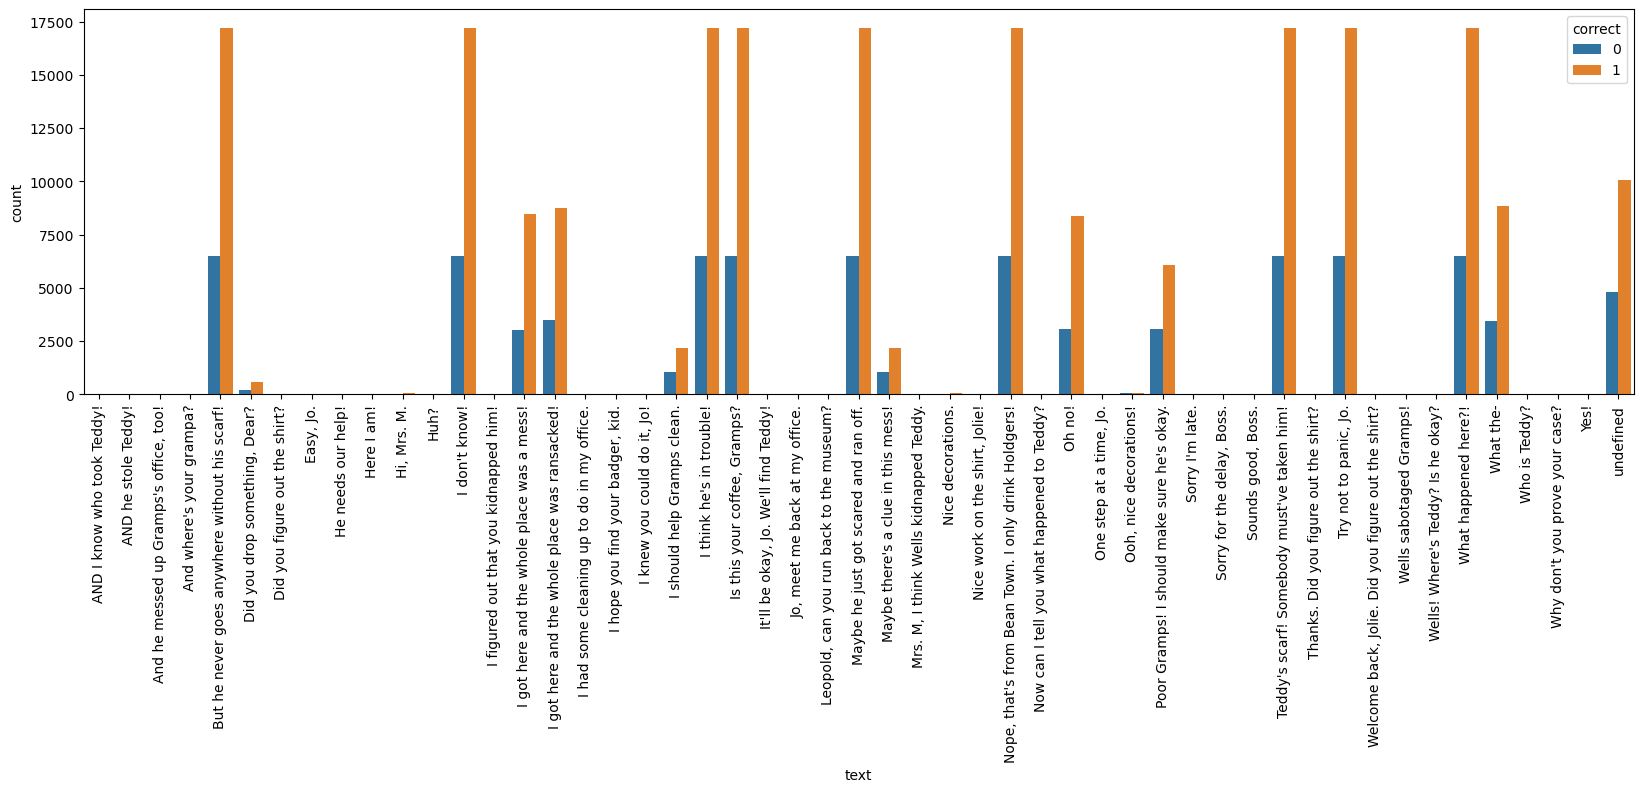

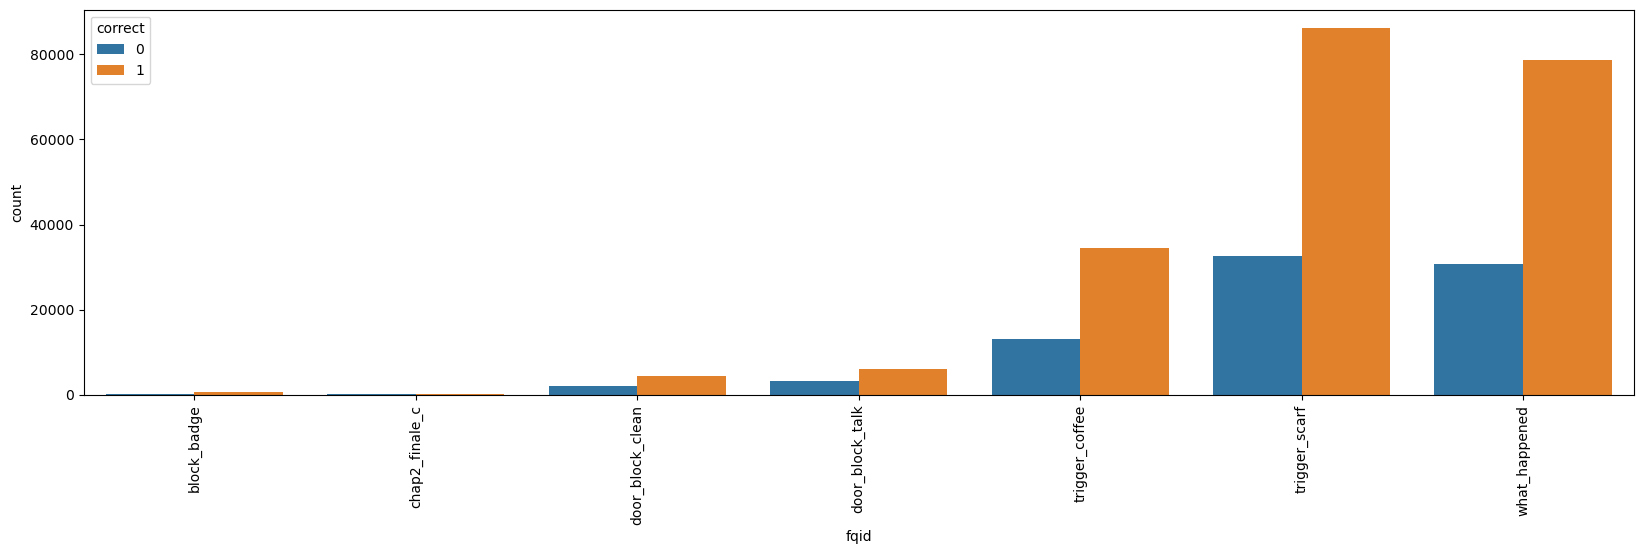

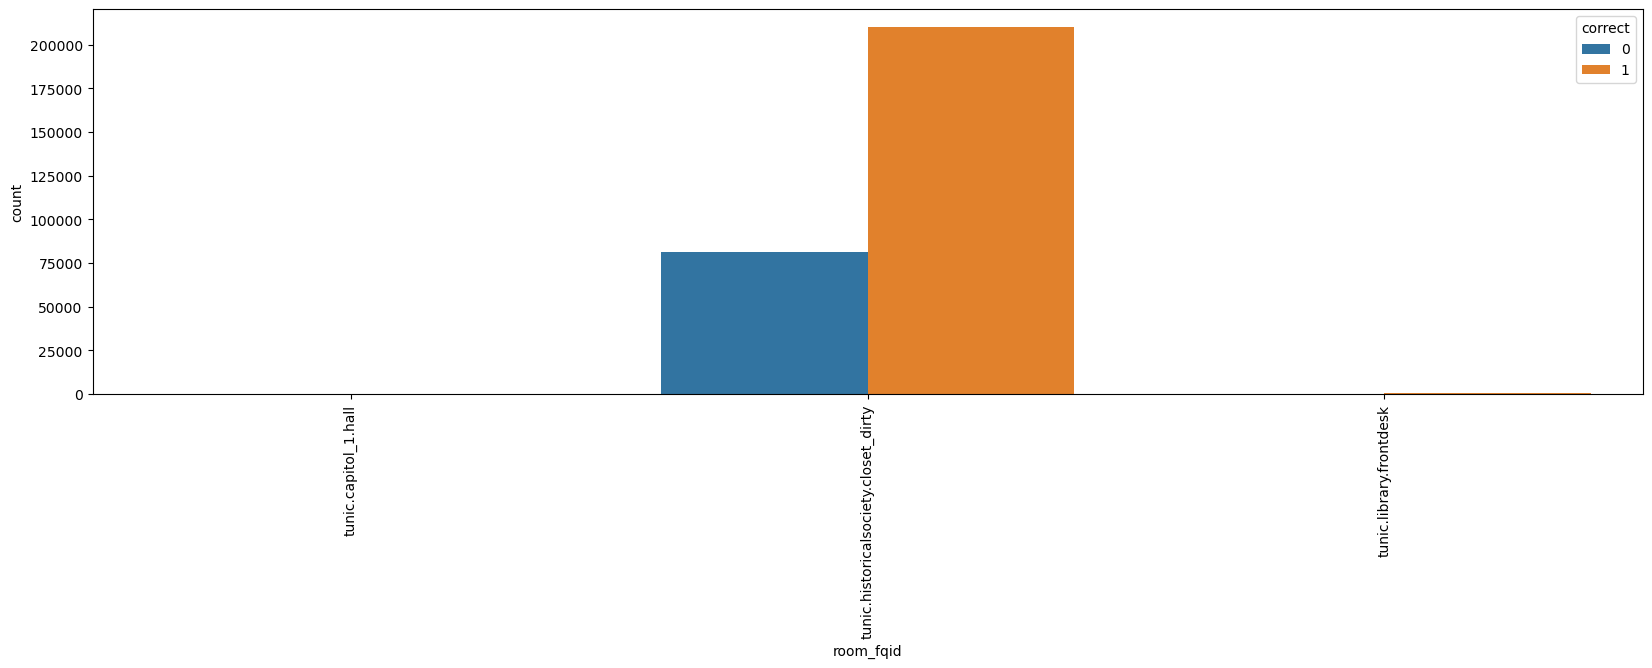

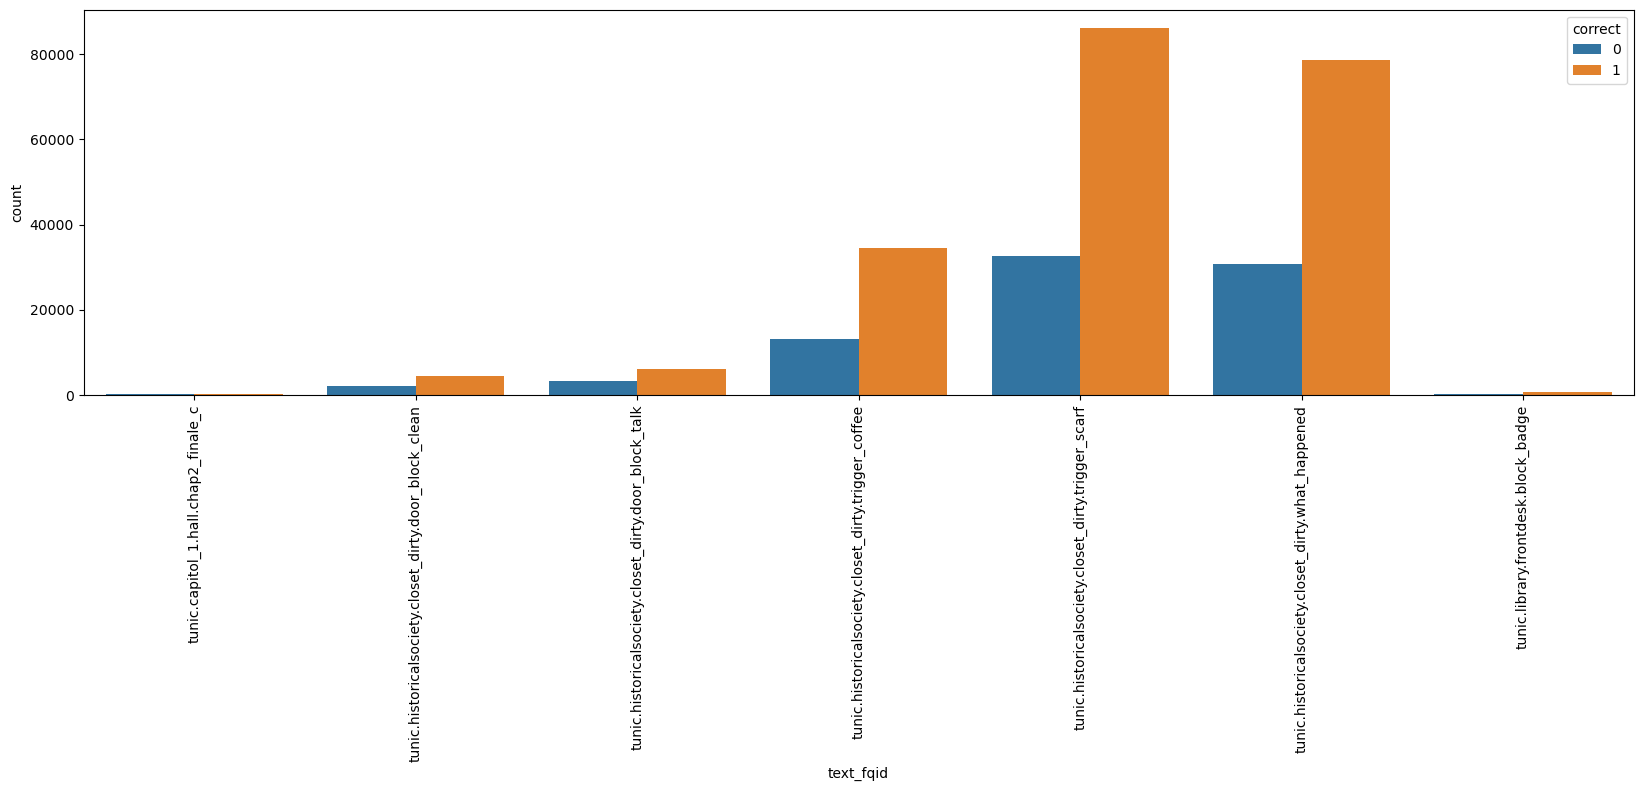

In [39]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__cutscene_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

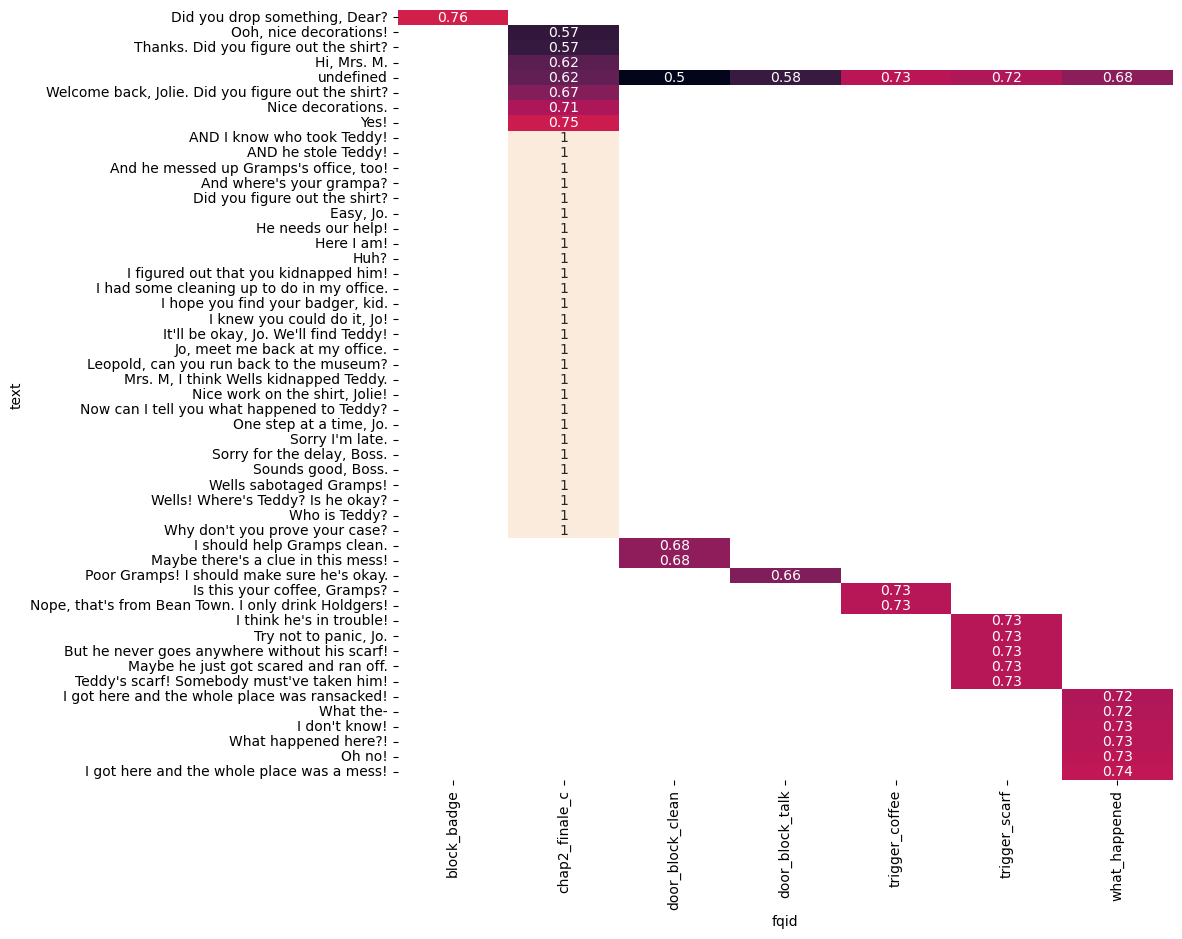

In [40]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

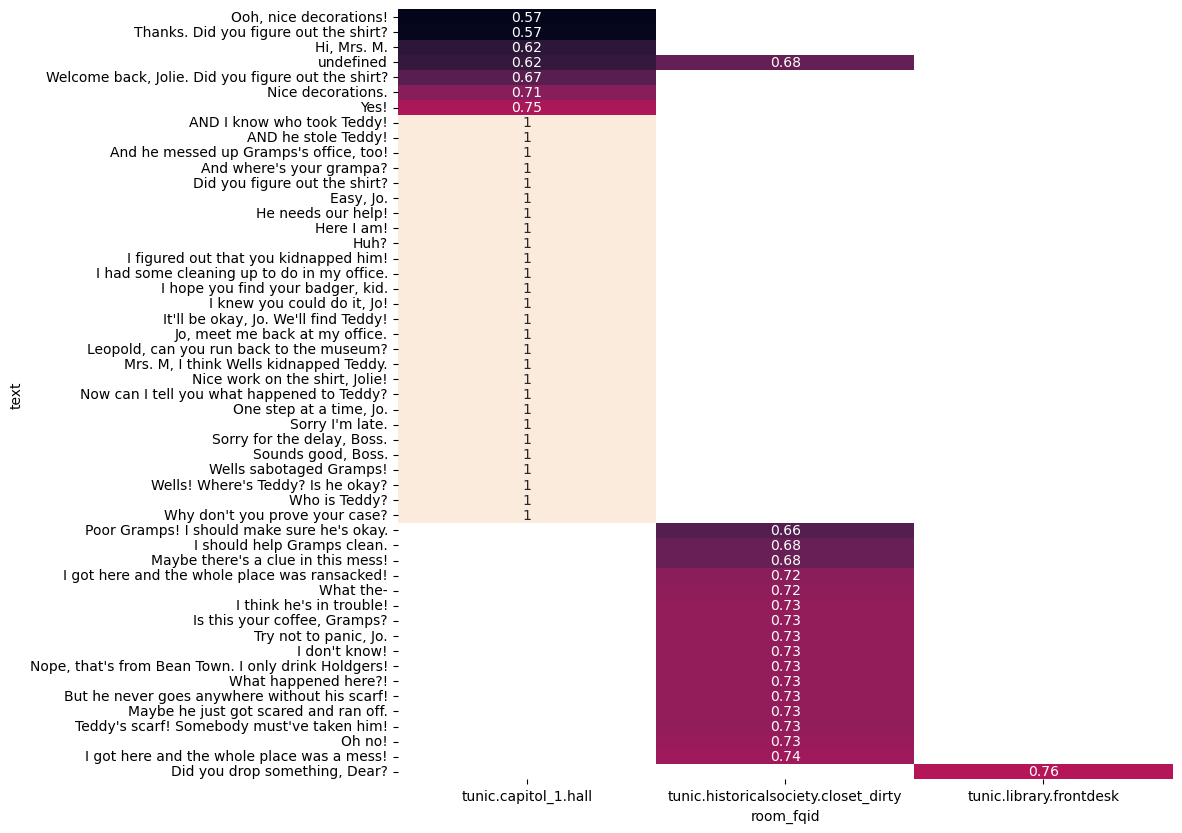

In [41]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

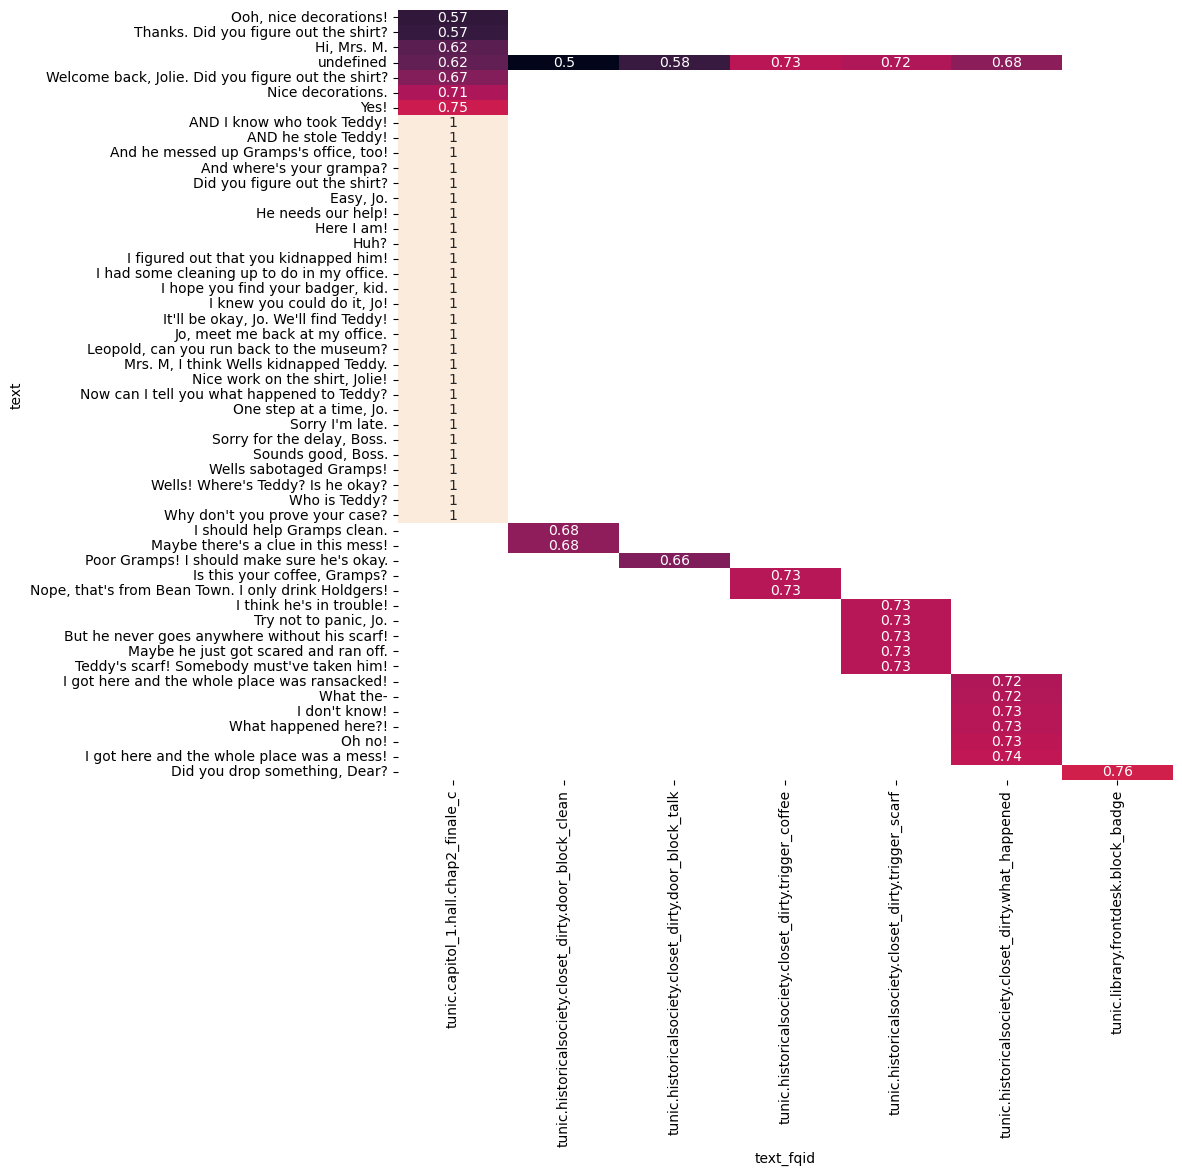

In [42]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

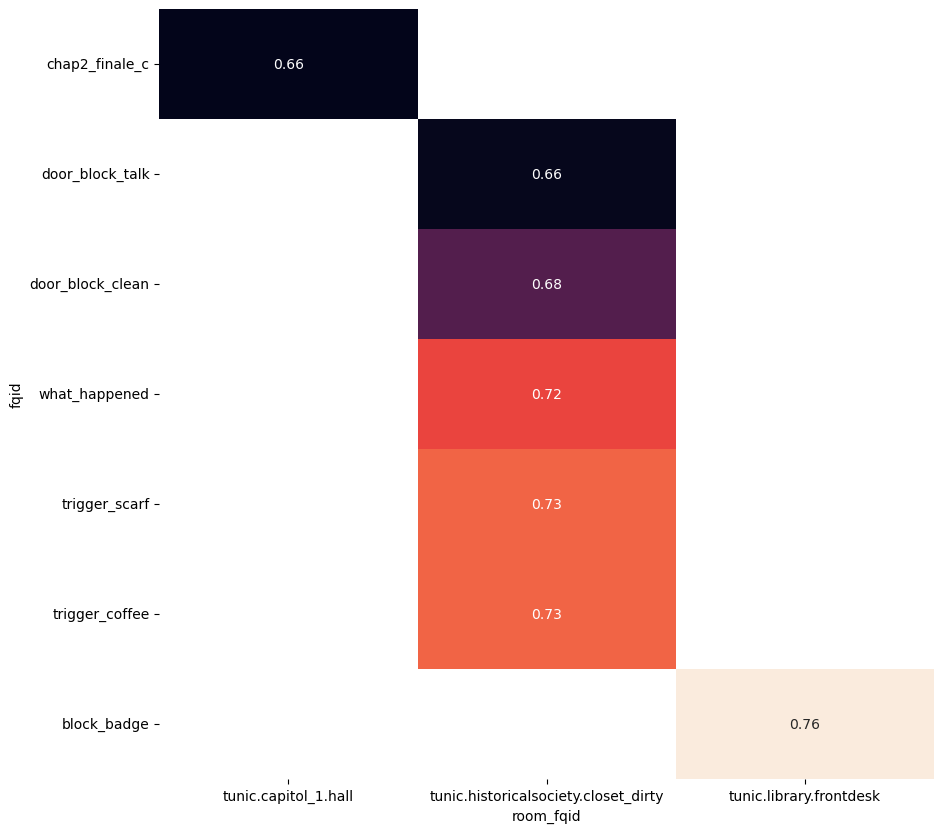

In [43]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

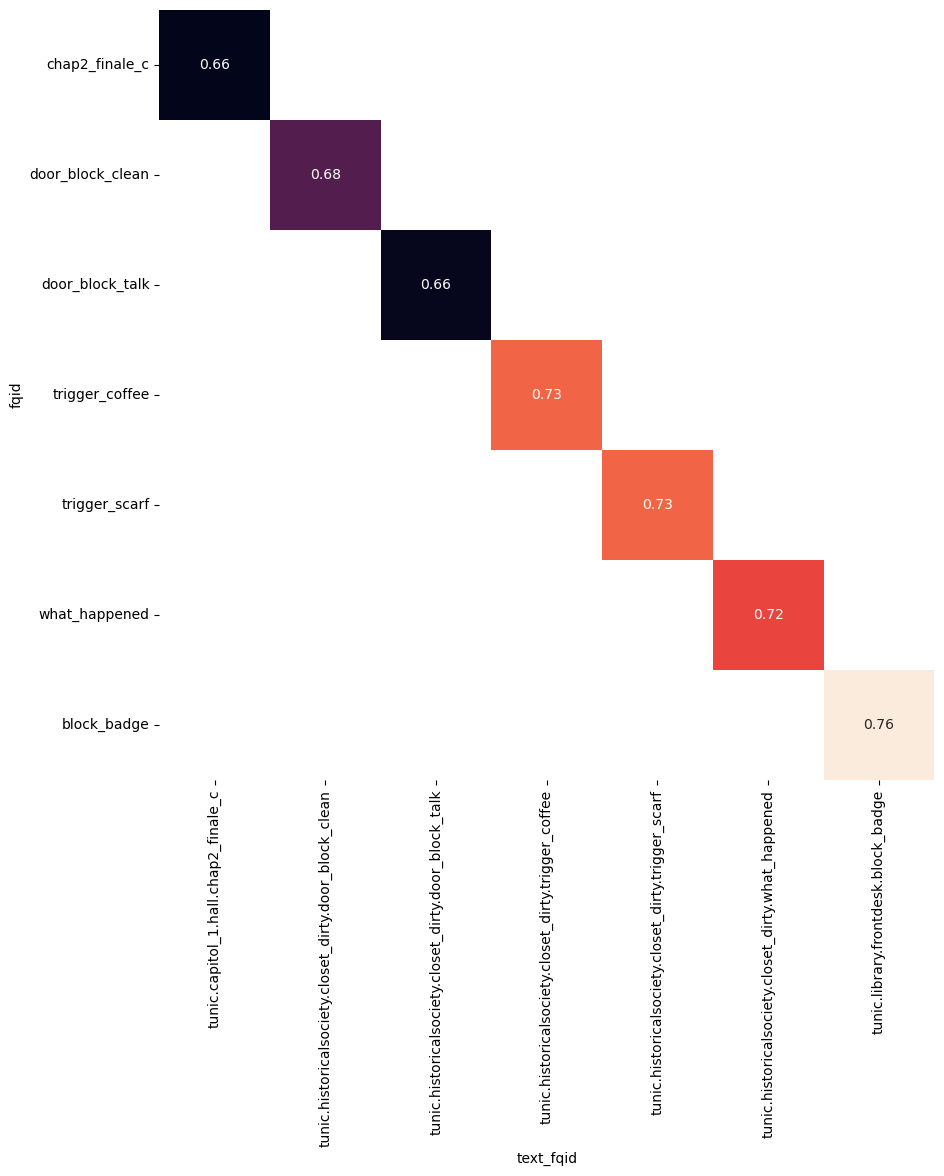

In [44]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

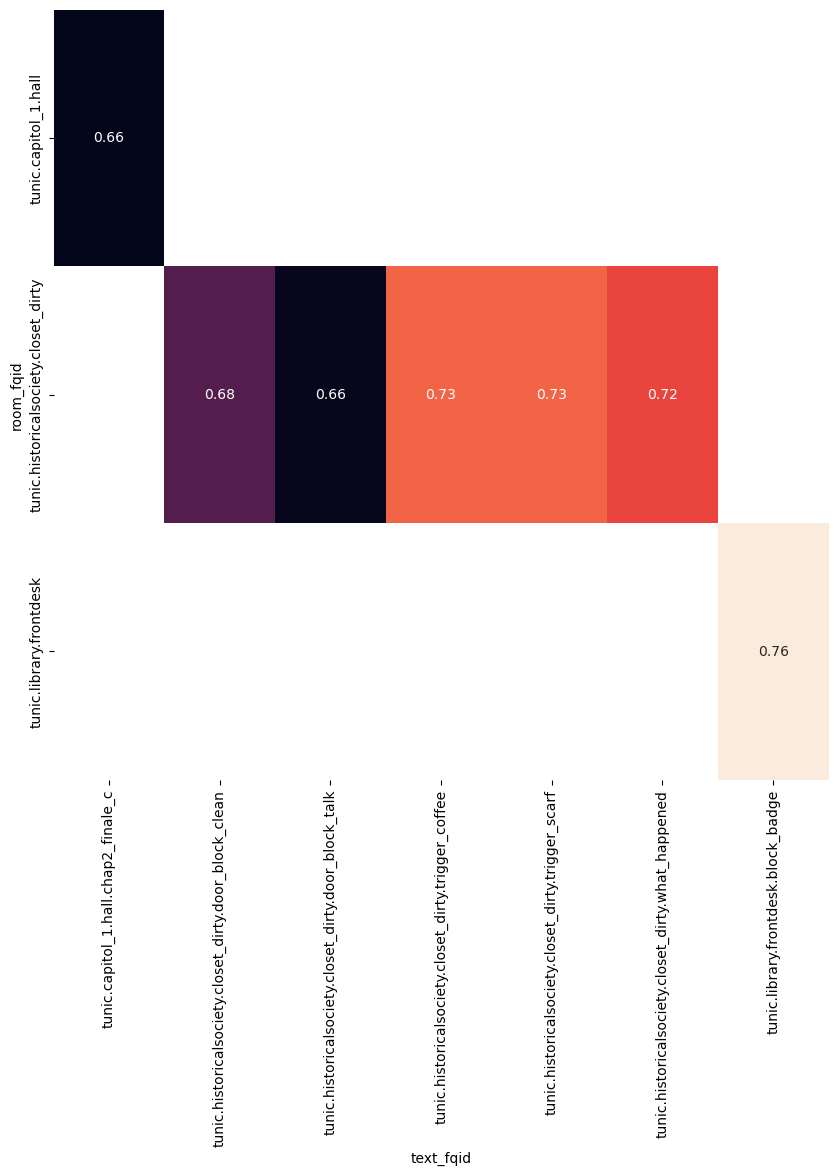

In [45]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

## `event_name` == `"map_click"`

In [46]:
df__map_click = df[df["event_name"] == "map_click"].reset_index(drop=True)
df__map_click.head()

session_id  index  elapsed_time event_name       name  level  page  \
0  20090312431273200    183        228133  map_click  undefined    5.0   NaN   
1  20090312431273200    242        280148  map_click      close    6.0   NaN   
2  20090312431273200    285        324396  map_click  undefined    7.0   NaN   
3  20090312431273200    329        357345  map_click  undefined    8.0   NaN   
4  20090312431273200    362        390068  map_click  undefined    9.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0   456.750000      167.125          559.0          198.0             NaN   
1  1111.000000      419.500          843.0           72.0             NaN   
2   418.500000     -201.000          420.0          453.0             NaN   
3   432.500000       60.000          587.0          270.0             NaN   
4   -30.953125       39.000          298.0          291.0             NaN   

        text                     fqid                      room_fqid  \
0  undefined  tunic.historicalsociety           tunic.capitol_0.hall   
1  undefined                      NaN  tunic.historicalsociety.entry   
2  undefined       tunic.humanecology  tunic.historicalsociety.entry   
3  undefined         tunic.drycleaner   tunic.humanecology.frontdesk   
4  undefined            tunic.library     tunic.drycleaner.frontdesk   

  text_fqid fullscreen hq music  correct  
0       NaN          0  0     1        1  
1       NaN          0  0     1        1  
2       NaN          0  0     1        1  
3       NaN          0  0     1        1  
4       NaN          0  0     1        1

#### Update Category Fields

In [47]:
df__map_click = recategorize_category_typed_fields(df__map_click)

In [48]:
summary = summarize_data_info(df__map_click)
summary

Data Shape: (205314, 20)


data_type  perc_missing  n_unique              first_value  \
session_id         int64           0.0     23562        20090312431273200   
index              int16           0.0      2783                      183   
elapsed_time       int32           0.0    187424                   228133   
event_name      category           0.0         1                map_click   
name            category           0.0         3                undefined   
level            float16           0.0         7                      5.0   
page             float16           1.0         0                      NaN   
room_coor_x      float16           0.0     15553                   456.75   
room_coor_y      float16           0.0     12845                  167.125   
screen_coor_x    float16           0.0      1976                    559.0   
screen_coor_y    float16           0.0      1571                    198.0   
hover_duration   float32           1.0         0                      NaN   
text            category           0.0         1                undefined   
fqid            category           0.0         8  tunic.historicalsociety   
room_fqid       category           0.0         7     tunic.capitol_0.hall   
text_fqid       category           0.0         1                      nan   
fullscreen      category           0.0         2                        0   
hq              category           0.0         2                        0   
music           category           0.0         2                        1   
correct            int64           0.0         2                        1   

                                 second_value                    third_value  \
session_id                  20090312431273200              20090312431273200   
index                                     242                            285   
elapsed_time                           280148                         324396   
event_name                          map_click                      map_click   
name                                    close                      undefined   
level                                     6.0                            7.0   
page                                      NaN                            NaN   
room_coor_x                            1111.0                          418.5   
room_coor_y                             419.5                         -201.0   
screen_coor_x                           843.0                          420.0   
screen_coor_y                            72.0                          453.0   
hover_duration                            NaN                            NaN   
text                                undefined                      undefined   
fqid                                      nan             tunic.humanecology   
room_fqid       tunic.historicalsociety.entry  tunic.historicalsociety.entry   
text_fqid                                 nan                            nan   
fullscreen                                  0                              0   
hq                                          0                              0   
music                                       1                              1   
correct                                     1                              1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                           0.0              18093.0  
elapsed_time                  113.0         1987178723.0  
event_name                      NaN                  NaN  
name                            NaN                  NaN  
level                           5.0                 12.0  
page                            NaN                  NaN  
room_coor_x                  -995.0               1171.0  
room_coor_y                  -531.5                536.5  
screen_coor_x                   0.0               1894.0  
screen_coor_y                   0.0               1062.0  
hover_du

In [49]:
df__map_click["name"].value_counts()

undefined    177497
basic         16660
close         11157
Name: name, dtype: int64

#### Insights

- `name` field has three values (basic, undefined, closed).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

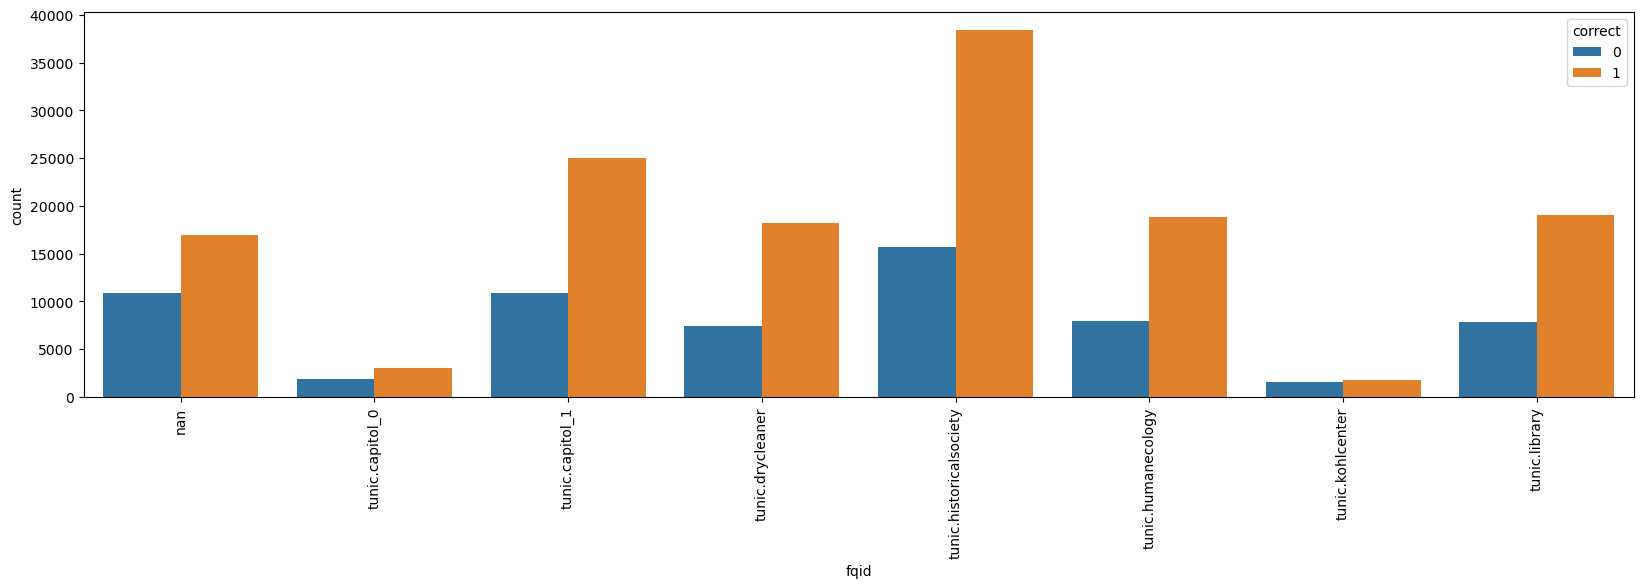

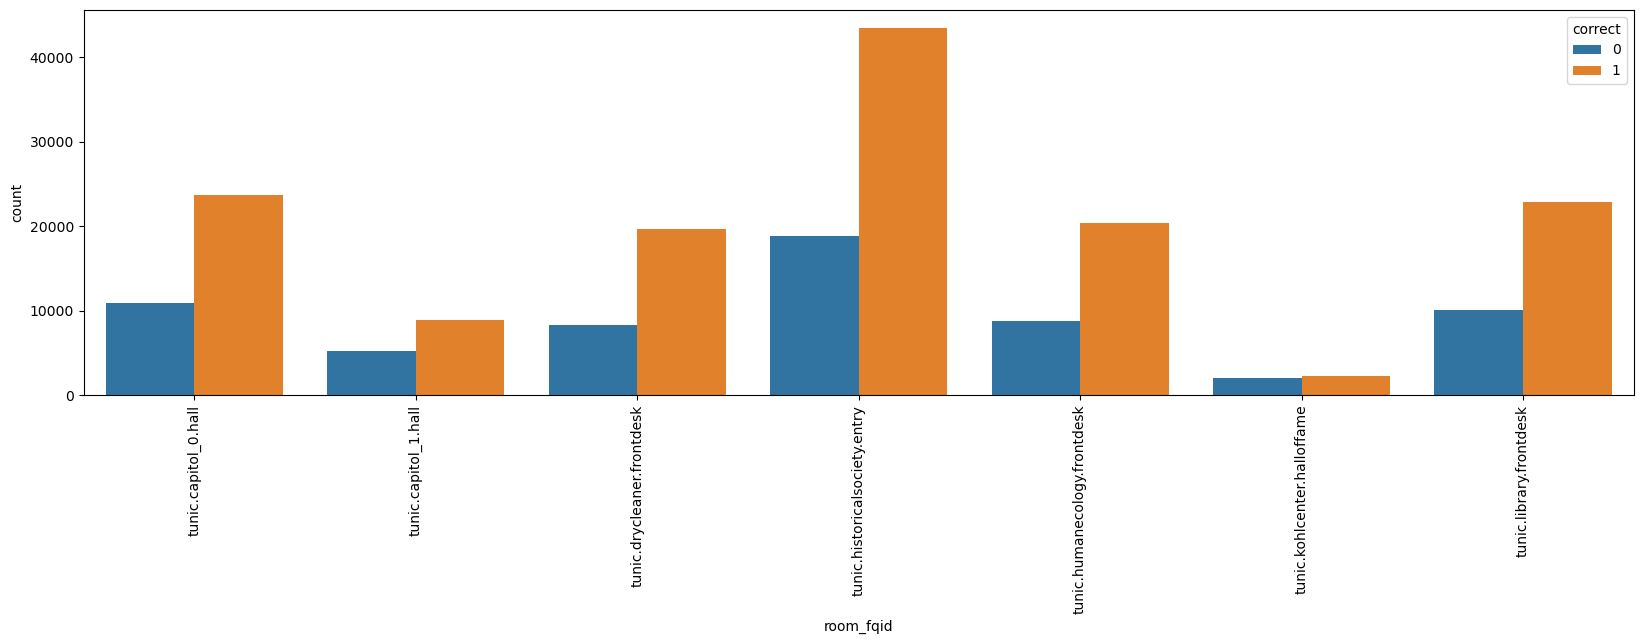

In [50]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__map_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

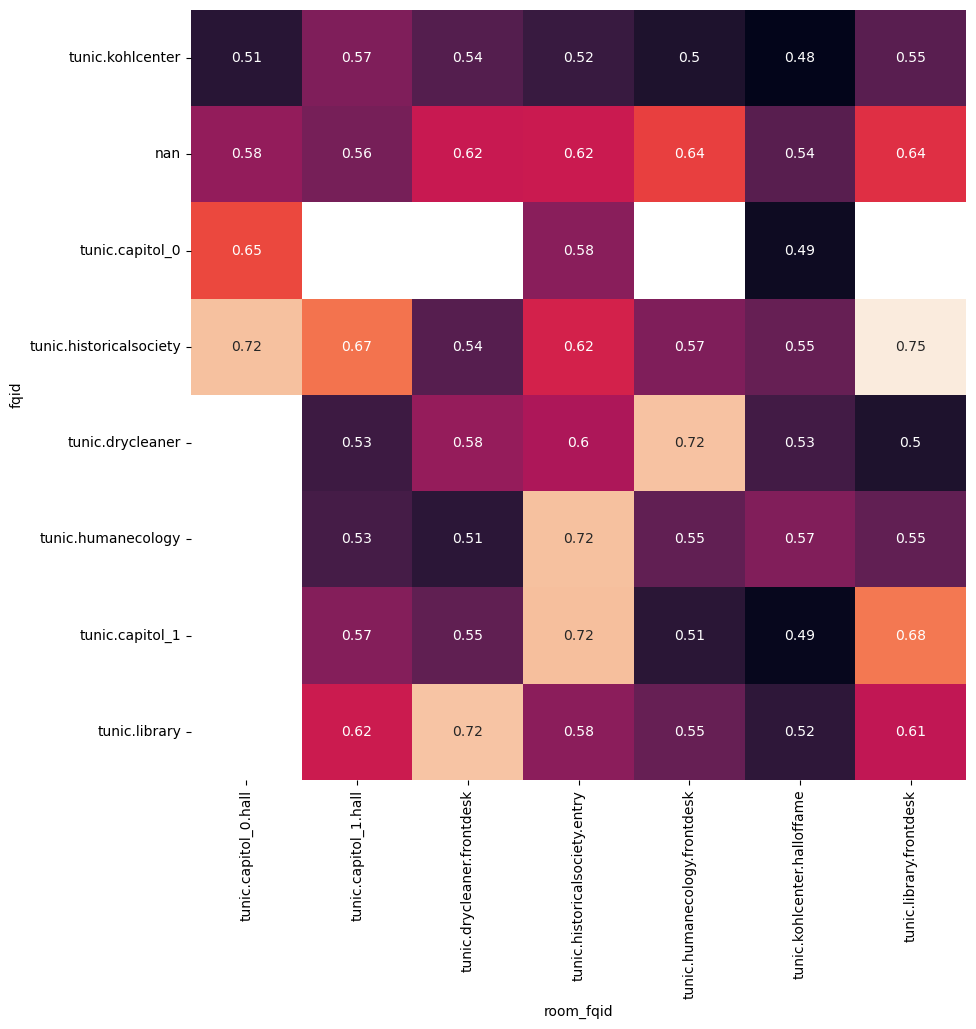

In [51]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__map_click, col_pair), figsize=(10, 10))

## `event_name` == `"map_hover"`

In [52]:
df__map_hover = df[df["event_name"] == "map_hover"].reset_index(drop=True)
df__map_hover.head()

session_id  index  elapsed_time event_name   name  level  page  \
0  20090312431273200    182        226643  map_hover  basic    5.0   NaN   
1  20090312431273200    240        278898  map_hover  basic    6.0   NaN   
2  20090312431273200    241        280113  map_hover  basic    6.0   NaN   
3  20090312431273200    284        323996  map_hover  basic    7.0   NaN   
4  20090312431273200    361        389751  map_hover  basic    9.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0          NaN          NaN            NaN            NaN           750.0   
1          NaN          NaN            NaN            NaN           582.0   
2          NaN          NaN            NaN            NaN           350.0   
3          NaN          NaN            NaN            NaN            16.0   
4          NaN          NaN            NaN            NaN           133.0   

        text             fqid                      room_fqid text_fqid  \
0  undefined          toentry           tunic.capitol_0.hall       NaN   
1  undefined            tomap  tunic.historicalsociety.entry       NaN   
2  undefined  tunic.capitol_1  tunic.historicalsociety.entry       NaN   
3  undefined  tunic.capitol_1  tunic.historicalsociety.entry       NaN   
4  undefined  tunic.capitol_1     tunic.drycleaner.frontdesk       NaN   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     1        1  
3          0  0     1        1  
4          0  0     1        1

#### Update Category Fields

In [53]:
df__map_hover = recategorize_category_typed_fields(df__map_hover)

In [54]:
summary = summarize_data_info(df__map_hover)
summary

Data Shape: (323170, 20)


data_type  perc_missing  n_unique           first_value  \
session_id         int64           0.0     21688     20090312431273200   
index              int16           0.0      2324                   182   
elapsed_time       int32           0.0    284686                226643   
event_name      category           0.0         1             map_hover   
name            category           0.0         1                 basic   
level            float16           0.0         7                   5.0   
page             float16           1.0         0                   NaN   
room_coor_x      float16           1.0         0                   NaN   
room_coor_y      float16           1.0         0                   NaN   
screen_coor_x    float16           1.0         0                   NaN   
screen_coor_y    float16           1.0         0                   NaN   
hover_duration   float32           0.0      4288                 750.0   
text            category           0.0         1             undefined   
fqid            category           0.0        16               toentry   
room_fqid       category           0.0         7  tunic.capitol_0.hall   
text_fqid       category           0.0         1                   nan   
fullscreen      category           0.0         2                     0   
hq              category           0.0         2                     0   
music           category           0.0         2                     1   
correct            int64           0.0         2                     1   

                                 second_value                    third_value  \
session_id                  20090312431273200              20090312431273200   
index                                     240                            241   
elapsed_time                           278898                         280113   
event_name                          map_hover                      map_hover   
name                                    basic                          basic   
level                                     6.0                            6.0   
page                                      NaN                            NaN   
room_coor_x                               NaN                            NaN   
room_coor_y                               NaN                            NaN   
screen_coor_x                             NaN                            NaN   
screen_coor_y                             NaN                            NaN   
hover_duration                          582.0                          350.0   
text                                undefined                      undefined   
fqid                                    tomap                tunic.capitol_1   
room_fqid       tunic.historicalsociety.entry  tunic.historicalsociety.entry   
text_fqid                                 nan                            nan   
fullscreen                                  0                              0   
hq                                          0                              0   
music                                       1                              1   
correct                                     1                              1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                           0.0              14937.0  
elapsed_time                  123.0         1987141625.0  
event_name                      NaN                  NaN  
name                            NaN                  NaN  
level                           5.0                 12.0  
page                            NaN                  NaN  
room_coor_x                     NaN                  NaN  
room_coor_y                     NaN                  NaN  
screen_coor_x                   NaN                  NaN  
screen_coor_y                   NaN                  NaN  
hover_duration                  0.0           47589760.0  
text        

#### Insights

- `name` field is constant (basic).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`

#### Categorical Fields

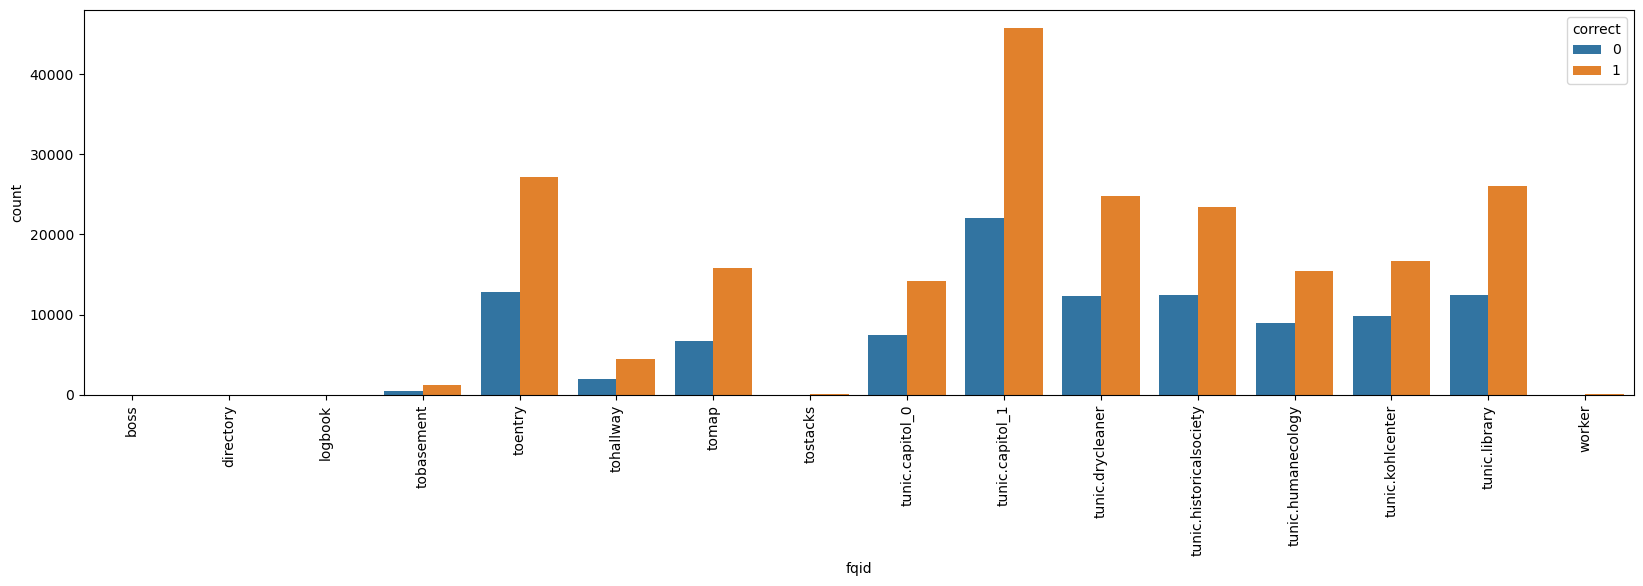

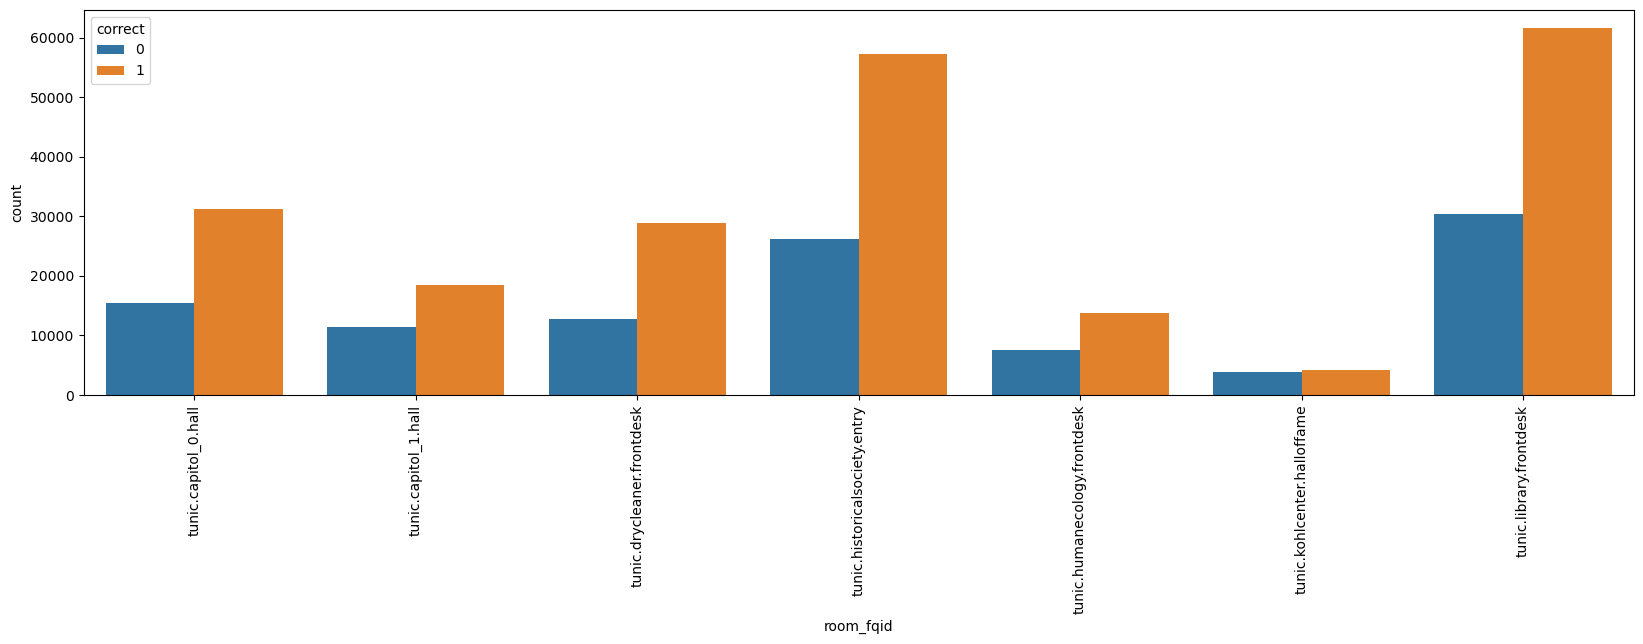

In [55]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__map_hover, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

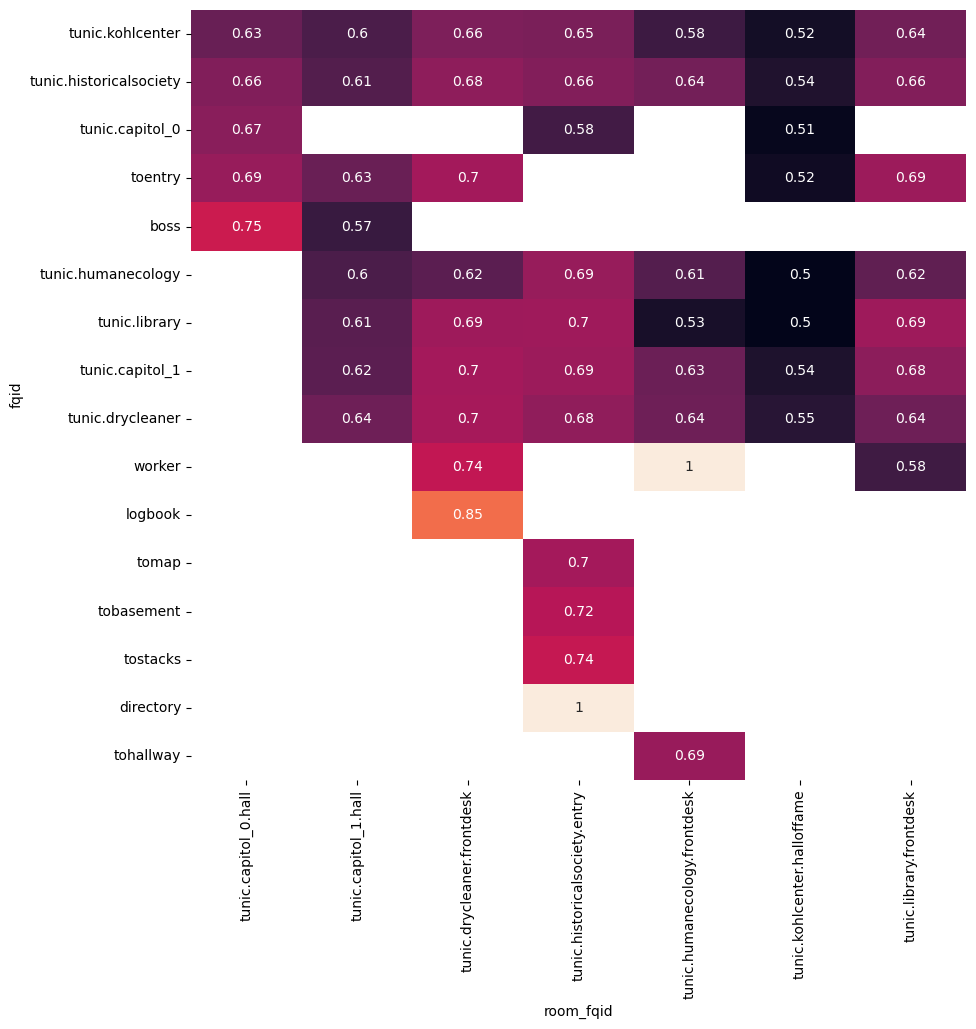

In [56]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__map_hover, col_pair), figsize=(10, 10))

## `event_name` == `"navigate_click"`

In [57]:
df__navigate_click = df[df["event_name"] == "navigate_click"].reset_index(drop=True)
df__navigate_click.head()

session_id  index  elapsed_time      event_name       name  level  \
0  20090312431273200    175        221485  navigate_click  undefined    5.0   
1  20090312431273200    178        223735  navigate_click  undefined    5.0   
2  20090312431273200    179        224235  navigate_click  undefined    5.0   
3  20090312431273200    180        224802  navigate_click  undefined    5.0   
4  20090312431273200    181        225803  navigate_click  undefined    5.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN       280.50   -19.703125          653.0          321.0   
1   NaN       331.75  -220.625000          688.0          454.0   
2   NaN       404.25  -226.500000          716.0          454.0   
3   NaN       612.50  -230.625000          804.0          454.0   
4   NaN       755.00  -213.125000          824.0          441.0   

   hover_duration       text     fqid             room_fqid text_fqid  \
0             NaN  undefined     boss  tunic.capitol_0.hall       NaN   
1             NaN  undefined      NaN  tunic.capitol_0.hall       NaN   
2             NaN  undefined      NaN  tunic.capitol_0.hall       NaN   
3             NaN  undefined      NaN  tunic.capitol_0.hall       NaN   
4             NaN  undefined  toentry  tunic.capitol_0.hall       NaN   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     1        1  
3          0  0     1        1  
4          0  0     1        1

#### Update Category Fields

In [58]:
df__navigate_click = recategorize_category_typed_fields(df__navigate_click)

In [59]:
summary = summarize_data_info(df__navigate_click)
summary

Data Shape: (3192522, 20)


data_type  perc_missing  n_unique           first_value  \
session_id         int64           0.0     23562     20090312431273200   
index              int16           0.0     11135                   175   
elapsed_time       int32           0.0   1191636                221485   
event_name      category           0.0         1        navigate_click   
name            category           0.0         1             undefined   
level            float16           0.0         8                   5.0   
page             float16           1.0         0                   NaN   
room_coor_x      float16           0.0     24307                 280.5   
room_coor_y      float16           0.0     21229            -19.703125   
screen_coor_x    float16           0.0      5432                 653.0   
screen_coor_y    float16           0.0      3311                 321.0   
hover_duration   float32           1.0         0                   NaN   
text            category           0.0         1             undefined   
fqid            category           0.0        38                  boss   
room_fqid       category           0.0        13  tunic.capitol_0.hall   
text_fqid       category           0.0         1                   nan   
fullscreen      category           0.0         2                     0   
hq              category           0.0         2                     0   
music           category           0.0         2                     1   
correct            int64           0.0         2                     1   

                        second_value           third_value  \
session_id         20090312431273200     20090312431273200   
index                            178                   179   
elapsed_time                  223735                224235   
event_name            navigate_click        navigate_click   
name                       undefined             undefined   
level                            5.0                   5.0   
page                             NaN                   NaN   
room_coor_x                   331.75                404.25   
room_coor_y                 -220.625                -226.5   
screen_coor_x                  688.0                 716.0   
screen_coor_y                  454.0                 454.0   
hover_duration                   NaN                   NaN   
text                       undefined             undefined   
fqid                             nan                   nan   
room_fqid       tunic.capitol_0.hall  tunic.capitol_0.hall   
text_fqid                        nan                   nan   
fullscreen                         0                     0   
hq                                 0                     0   
music                              1                     1   
correct                            1                     1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                           0.0              18195.0  
elapsed_time                    0.0         1987181016.0  
event_name                      NaN                  NaN  
name                            NaN                  NaN  
level                           5.0                 12.0  
page                            NaN                  NaN  
room_coor_x                 -1215.0               1173.0  
room_coor_y                  -592.5                532.0  
screen_coor_x                   0.0               1917.0  
screen_coor_y                   0.0               1440.0  
hover_duration                  NaN                  NaN  
text                            NaN                  NaN  
fqid                            NaN                  NaN  
room_fqid                       NaN                  NaN  
text_fqid                       NaN                  NaN  
fullscreen                      NaN                  NaN  
hq                              NaN                  NaN  
music                           NaN 

#### Insights

- `name` field is constant (undefined).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

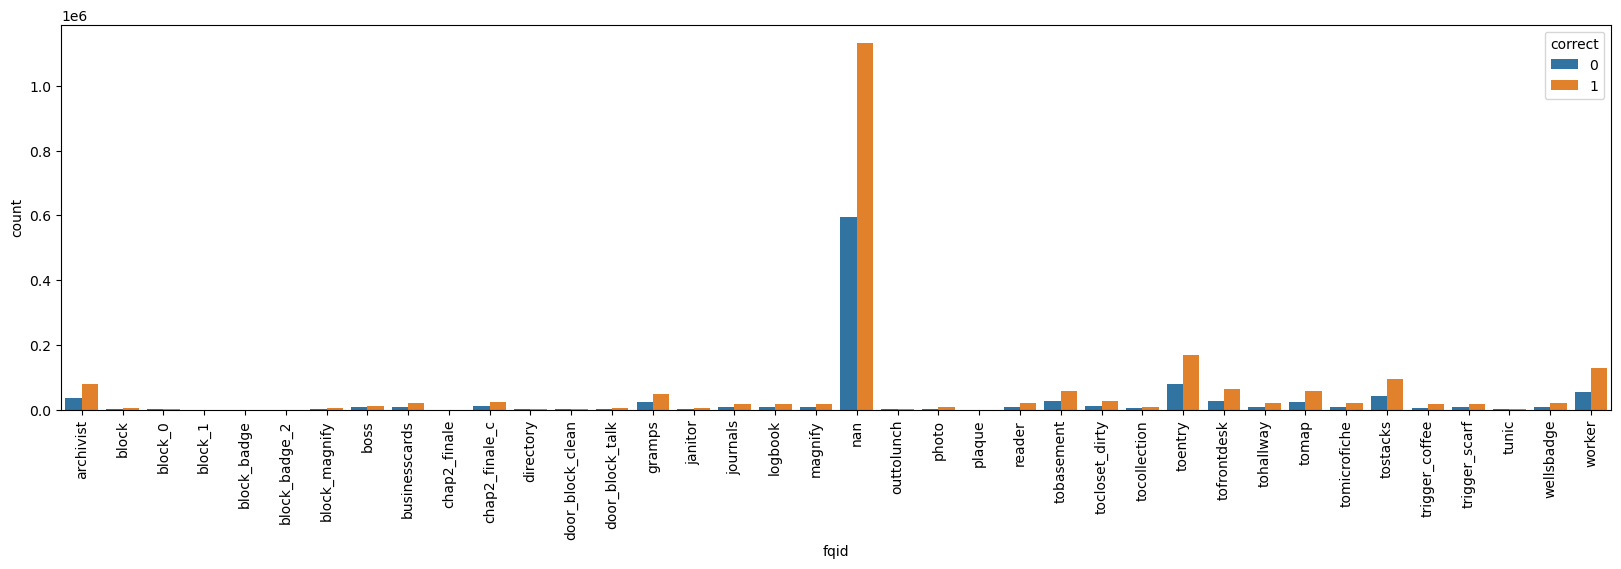

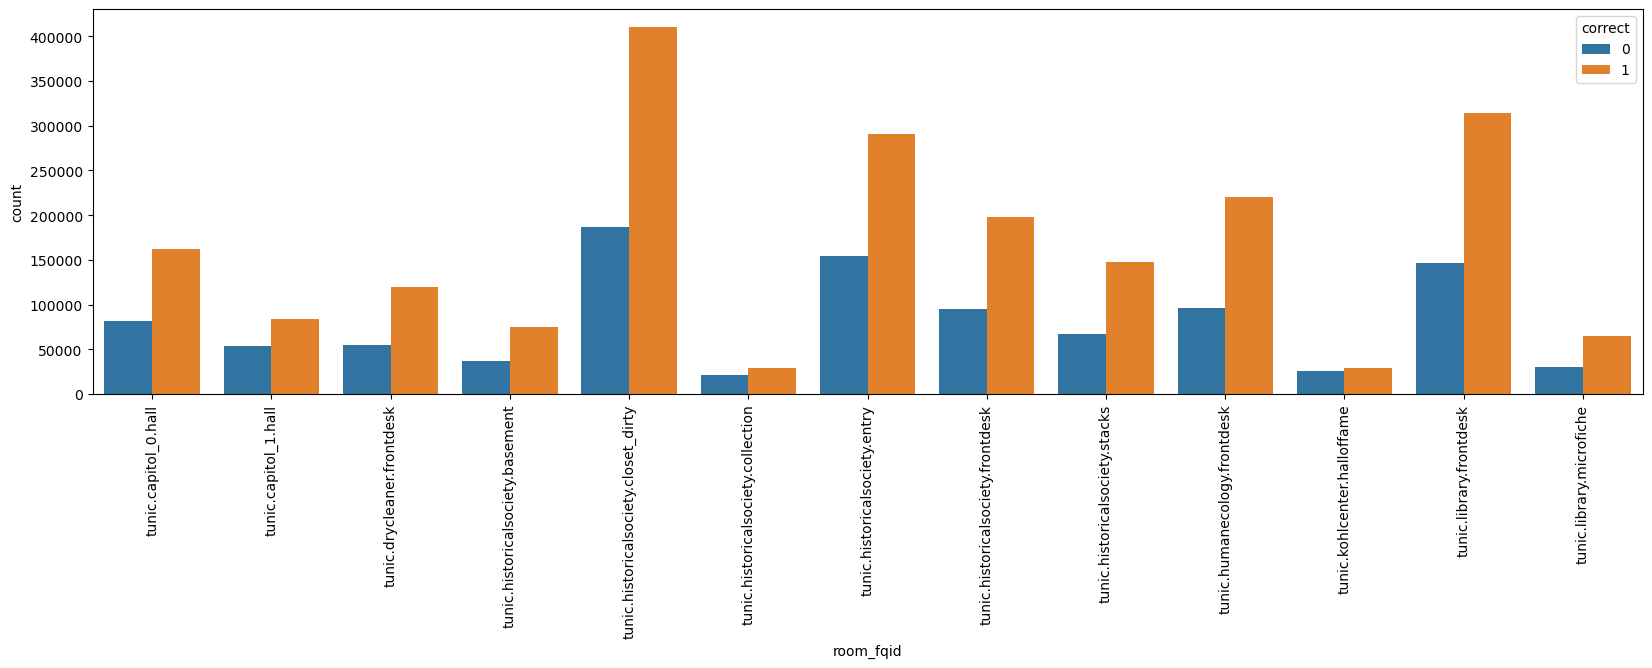

In [60]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__navigate_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

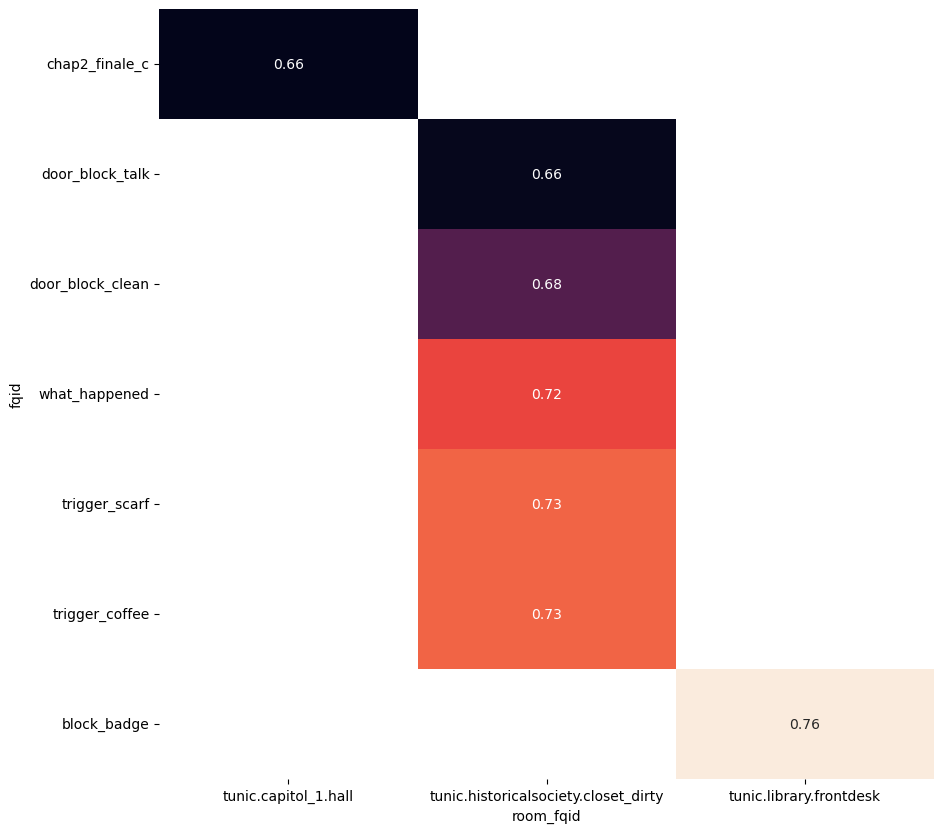

In [61]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

## `event_name` == `"notebook_click"`

In [62]:
df__notebook_click = df[df["event_name"] == "notebook_click"].reset_index(drop=True)
df__notebook_click.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312433251036    209        351064  notebook_click   open    6.0   1.0   
1  20090312433251036    210        354779  notebook_click  basic    6.0   1.0   
2  20090312433251036    211        357947  notebook_click  close    6.0   1.0   
3  20090312433251036    413        651200  notebook_click   open   11.0   3.0   
4  20090312433251036    414        654048  notebook_click  close   11.0   3.0   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0     -490.750      -429.75           61.0          629.0             NaN   
1      -97.625      -304.25          343.0          539.0             NaN   
2      556.000       342.50          812.0           75.0             NaN   
3     -465.250      -493.75           48.0          628.0             NaN   
4      795.000       390.50          822.0           85.0             NaN   

        text fqid                         room_fqid text_fqid fullscreen hq  \
0  undefined  NaN  tunic.historicalsociety.basement       NaN          0  0   
1  undefined  NaN  tunic.historicalsociety.basement       NaN          0  0   
2  undefined  NaN  tunic.historicalsociety.basement       NaN          0  0   
3  undefined  NaN     tunic.historicalsociety.entry       NaN          0  0   
4  undefined  NaN     tunic.historicalsociety.entry       NaN          0  0   

  music  correct  
0     0        0  
1     0        0  
2     0        0  
3     0        0  
4     0        0

#### Update Category Fields

In [63]:
df__notebook_click = recategorize_category_typed_fields(df__notebook_click)

In [64]:
summary = summarize_data_info(df__notebook_click)
summary

Data Shape: (182143, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     16228   
index              int16           0.0      4516   
elapsed_time       int32           0.0    168120   
event_name      category           0.0         1   
name            category           0.0         5   
level            float16           0.0         8   
page             float16           0.0         4   
room_coor_x      float16           0.0     10959   
room_coor_y      float16           0.0      6169   
screen_coor_x    float16           0.0      2312   
screen_coor_y    float16           0.0      1833   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0         1   
room_fqid       category           0.0        11   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                     first_value  \
session_id                     20090312433251036   
index                                        209   
elapsed_time                              351064   
event_name                        notebook_click   
name                                        open   
level                                        6.0   
page                                         1.0   
room_coor_x                              -490.75   
room_coor_y                              -429.75   
screen_coor_x                               61.0   
screen_coor_y                              629.0   
hover_duration                               NaN   
text                                   undefined   
fqid                                         nan   
room_fqid       tunic.historicalsociety.basement   
text_fqid                                    nan   
fullscreen                                     0   
hq                                             0   
music                                          0   
correct                                        0   

                                    second_value  \
session_id                     20090312433251036   
index                                        210   
elapsed_time                              354779   
event_name                        notebook_click   
name                                       basic   
level                                        6.0   
page                                         1.0   
room_coor_x                              -97.625   
room_coor_y                              -304.25   
screen_coor_x                              343.0   
screen_coor_y                              539.0   
hover_duration                               NaN   
text                                   undefined   
fqid                                         nan   
room_fqid       tunic.historicalsociety.basement   
text_fqid                                    nan   
fullscreen                                     0   
hq                                             0   
music                                          0   
correct                                        0   

                                     third_value                  min  \
session_id                     20090312433251036  20090312433251036.0   
index                                        211                  0.0   
elapsed_time                              357947             110180.0   
event_name                        notebook_click                  NaN   
name                                       close                  NaN   
level                                        6.0                  5.0   
page                                         1.0                  0.0   
room_coor_x                                556.0              -1208.0   
room_coor_y                                342.5               -583.0   
screen

In [65]:
df__notebook_click["name"].value_counts(dropna=False)

close    77201
open     77201
basic    19000
prev      5327
next      3414
Name: name, dtype: int64

In [66]:
df__notebook_click["page"].value_counts(dropna=False)

1.0    80807
3.0    51381
2.0    45288
0.0     4667
Name: page, dtype: int64

#### Insights

- `name` field has 5 different values (open, close, basic, prev, next).
- `page` field has 4 different values (0, 1, 2, 3).
- `text` field is constant (undefined).
- `fqid` field is constant (nan).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `hover_duration`

#### Categorical Fields

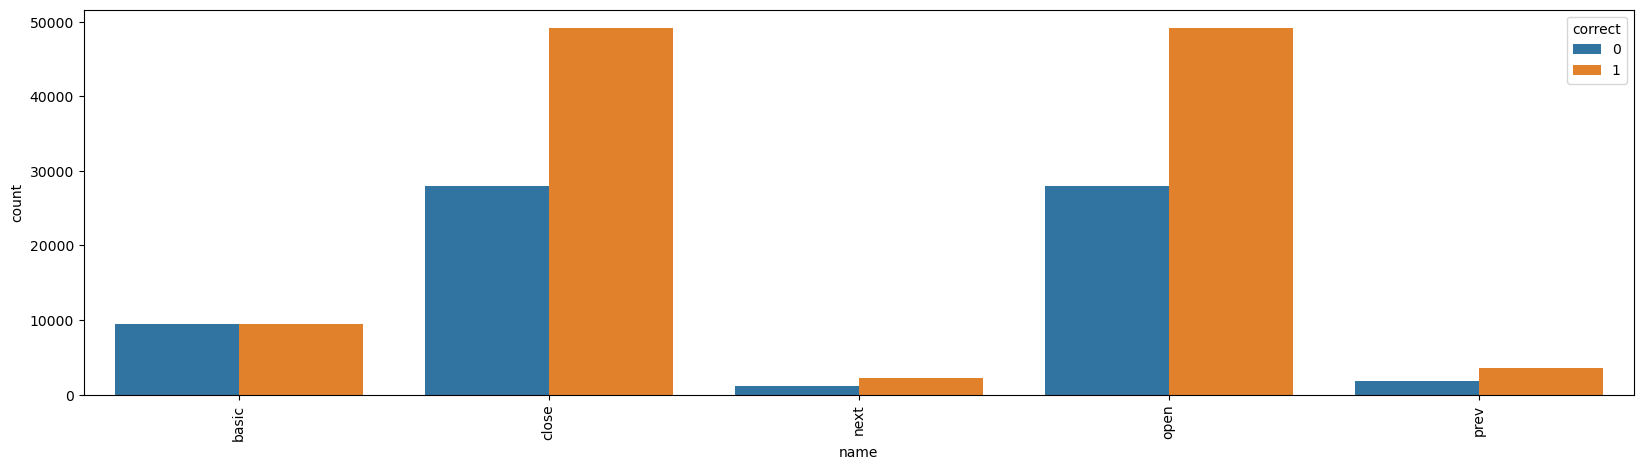

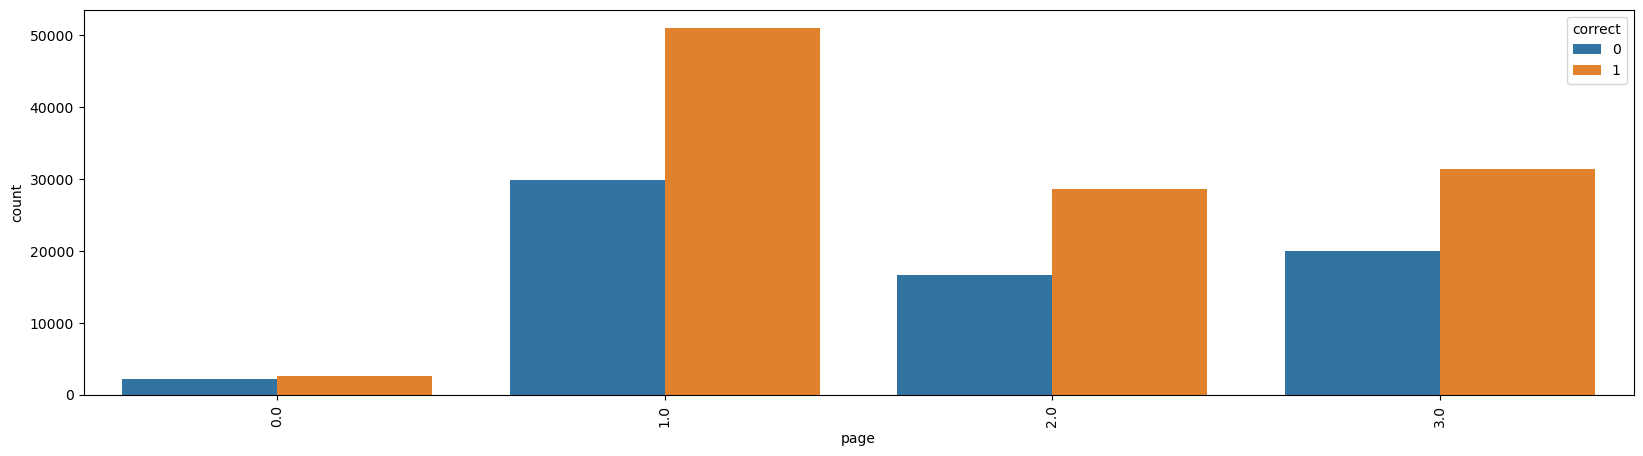

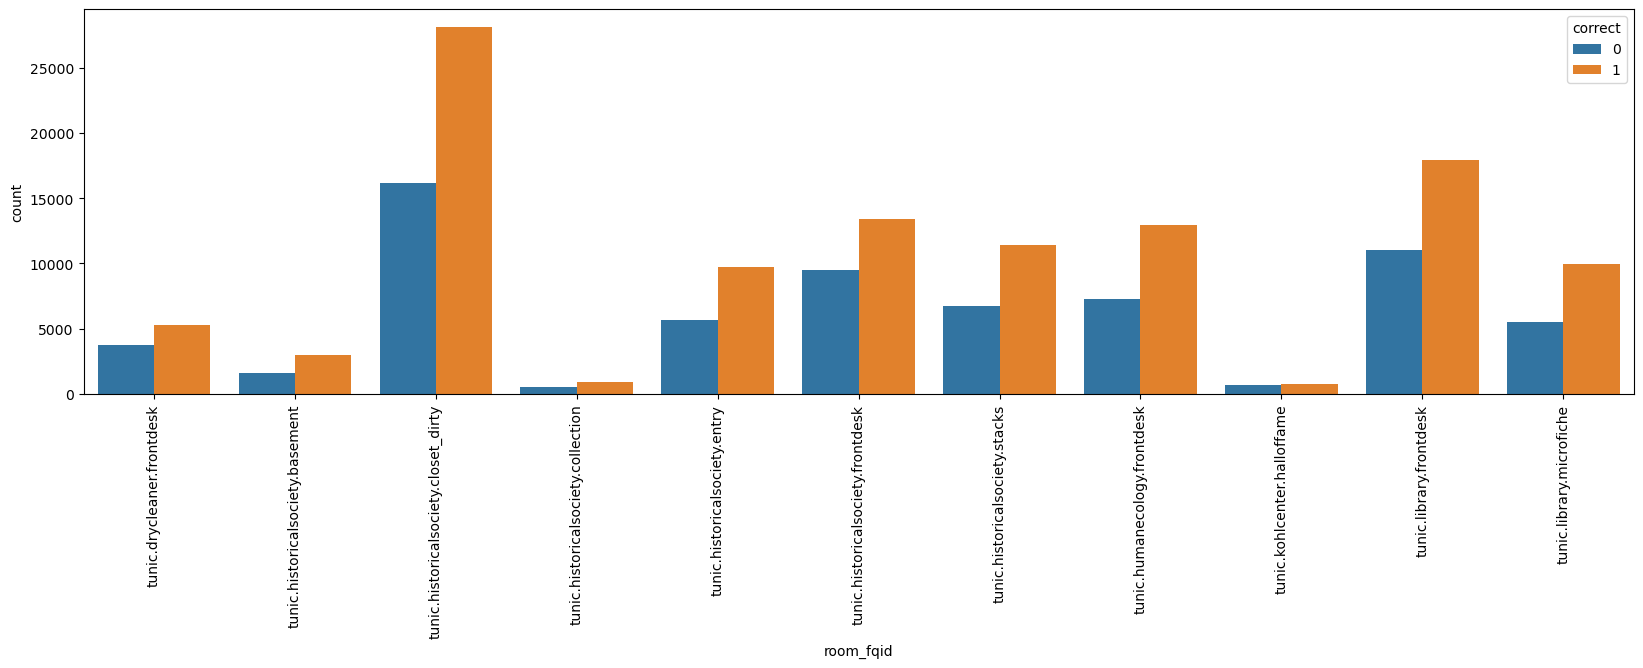

In [67]:
cat_fields_list = ["name", "page", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__notebook_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

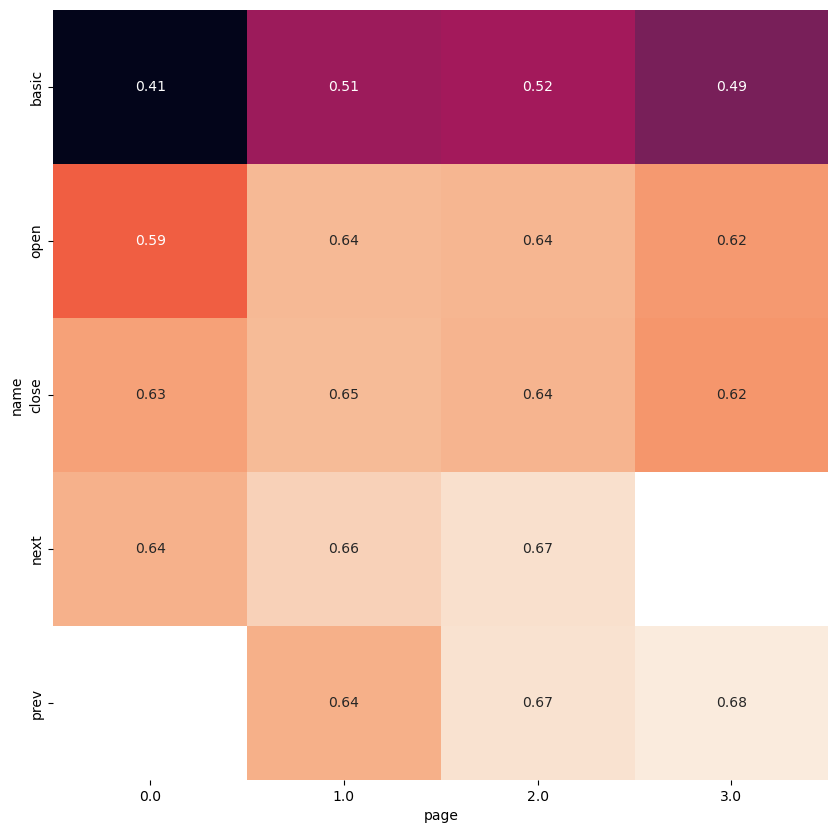

In [68]:
col_pair = ["name", "page"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

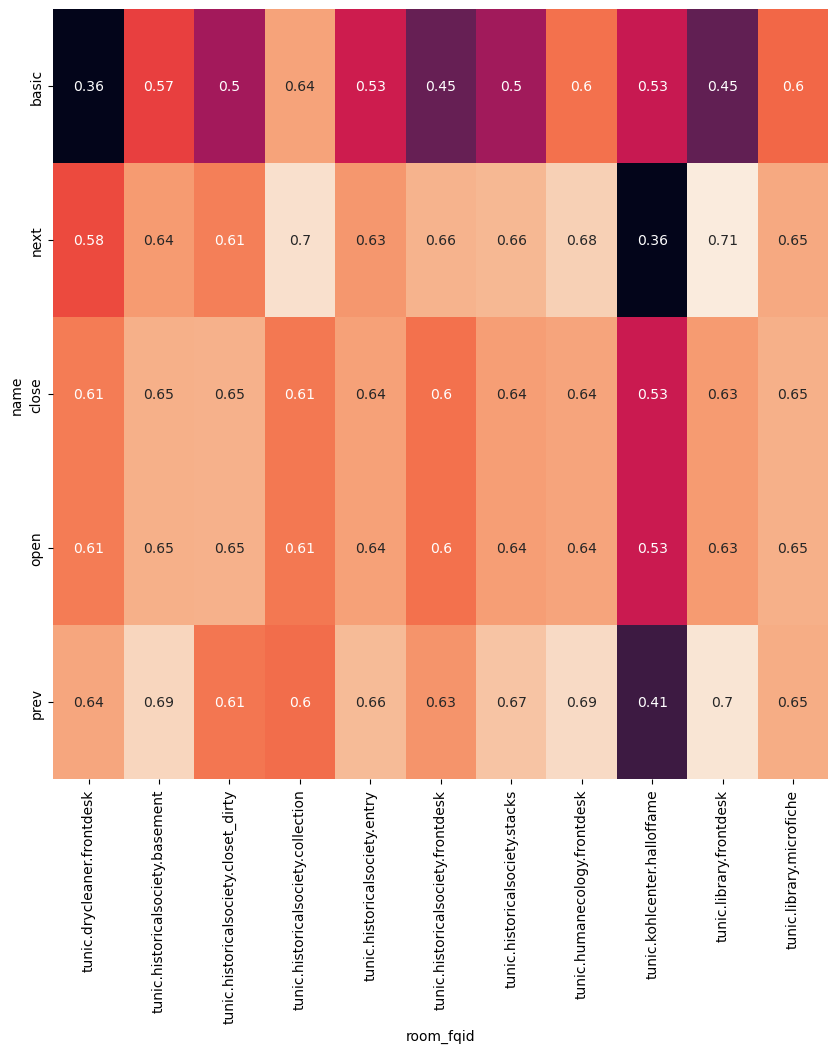

In [69]:
col_pair = ["name", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

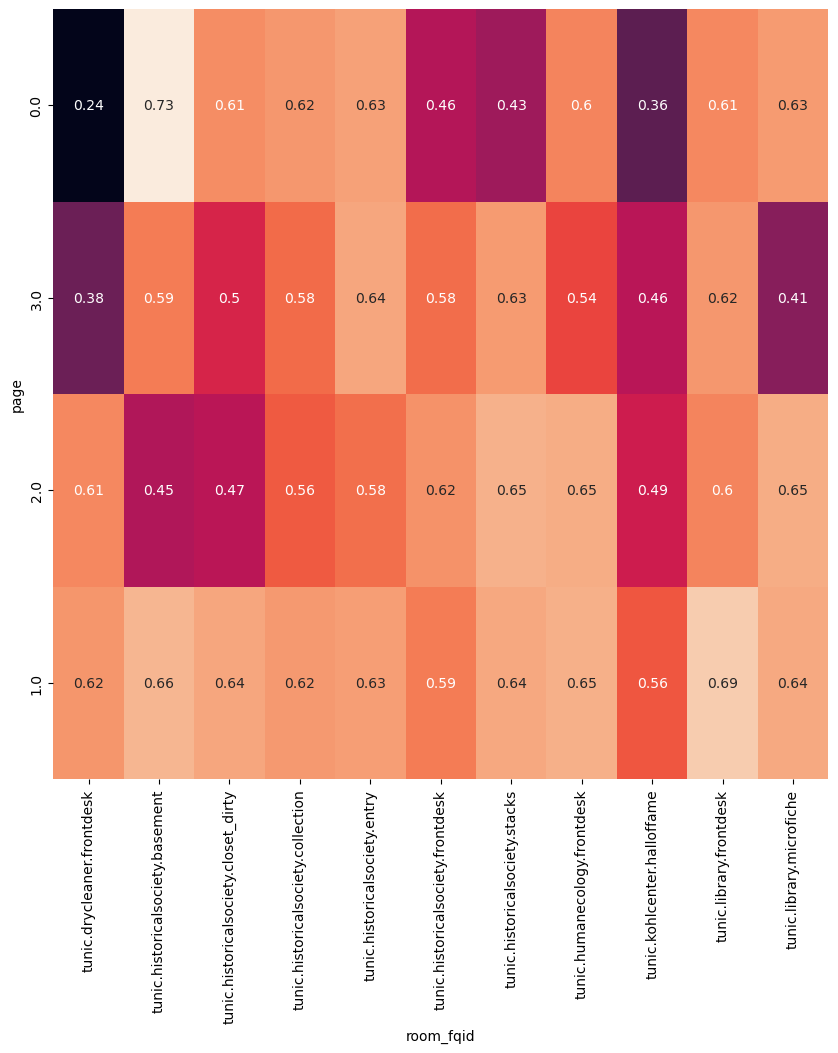

In [70]:
col_pair = ["page", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

## `event_name` == `"notification_click"`

In [71]:
df__notification_click = df[df["event_name"] == "notification_click"].reset_index(drop=True)
df__notification_click.head()

session_id  index  elapsed_time          event_name   name  level  \
0  20090312431273200    313        346295  notification_click  basic    7.0   
1  20090312431273200    349        381368  notification_click  basic    8.0   
2  20090312431273200    350        381935  notification_click  basic    8.0   
3  20090312431273200    383        412184  notification_click  basic    9.0   
4  20090312431273200    384        412767  notification_click  basic    9.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN    133.25000       -104.0          491.0          434.0   
1   NaN    256.25000         12.0          687.0          318.0   
2   NaN    256.25000         12.0          687.0          318.0   
3   NaN    -33.15625       -122.0          414.0          452.0   
4   NaN    -33.15625       -122.0          414.0          452.0   

   hover_duration                                               text fqid  \
0             NaN  This place was around in 1916! I can start there!  NaN   
1             NaN                                      It's a match!  NaN   
2             NaN                Theodora Youmans must be the owner!  NaN   
3             NaN                          Youmans was a suffragist!  NaN   
4             NaN                    She helped get votes for women!  NaN   

                      room_fqid  \
0  tunic.humanecology.frontdesk   
1    tunic.drycleaner.frontdesk   
2    tunic.drycleaner.frontdesk   
3      tunic.library.microfiche   
4      tunic.library.microfiche   

                                           text_fqid fullscreen hq music  \
0  tunic.humanecology.frontdesk.businesscards.car...          0  0     1   
1      tunic.drycleaner.frontdesk.logbook.page.bingo          0  0     1   
2      tunic.drycleaner.frontdesk.logbook.page.bingo          0  0     1   
3       tunic.library.microfiche.reader.paper2.bingo          0  0     1   
4       tunic.library.microfiche.reader.paper2.bingo          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

#### Update Category Fields

In [72]:
df__notification_click = recategorize_category_typed_fields(df__notification_click)

In [73]:
summary = summarize_data_info(df__notification_click)
summary

Data Shape: (222801, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      2173   
elapsed_time       int32           0.0    201230   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         6   
page             float16           1.0         0   
room_coor_x      float16           0.0     11176   
room_coor_y      float16           0.0      5931   
screen_coor_x    float16           0.0      2116   
screen_coor_y    float16           0.0      1683   
hover_duration   float32           1.0         0   
text            category           0.0        10   
fqid            category           0.0         1   
room_fqid       category           0.0         5   
text_fqid       category           0.0         5   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                                      first_value  \
session_id                                      20090312431273200   
index                                                         313   
elapsed_time                                               346295   
event_name                                     notification_click   
name                                                        basic   
level                                                         7.0   
page                                                          NaN   
room_coor_x                                                133.25   
room_coor_y                                                -104.0   
screen_coor_x                                               491.0   
screen_coor_y                                               434.0   
hover_duration                                                NaN   
text            This place was around in 1916! I can start there!   
fqid                                                          nan   
room_fqid                            tunic.humanecology.frontdesk   
text_fqid       tunic.humanecology.frontdesk.businesscards.car...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                 second_value  \
session_id                                  20090312431273200   
index                                                     349   
elapsed_time                                           381368   
event_name                                 notification_click   
name                                                    basic   
level                                                     8.0   
page                                                      NaN   
room_coor_x                                            256.25   
room_coor_y                                              12.0   
screen_coor_x                                           687.0   
screen_coor_y                                           318.0   
hover_duration                                            NaN   
text                                            It's a match!   
fqid                                                      nan   
room_fqid                          tunic.drycleaner.frontdesk   
text_fqid       tunic.drycleaner.frontdesk.logbook.page.bingo   
fullscreen                                                  0   
hq                                                          0   
music                                                       1   
correct                                                     1   

                                                  third_value  \
session_id                               

#### Insights

- `name` field is constant (basic).
- `fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

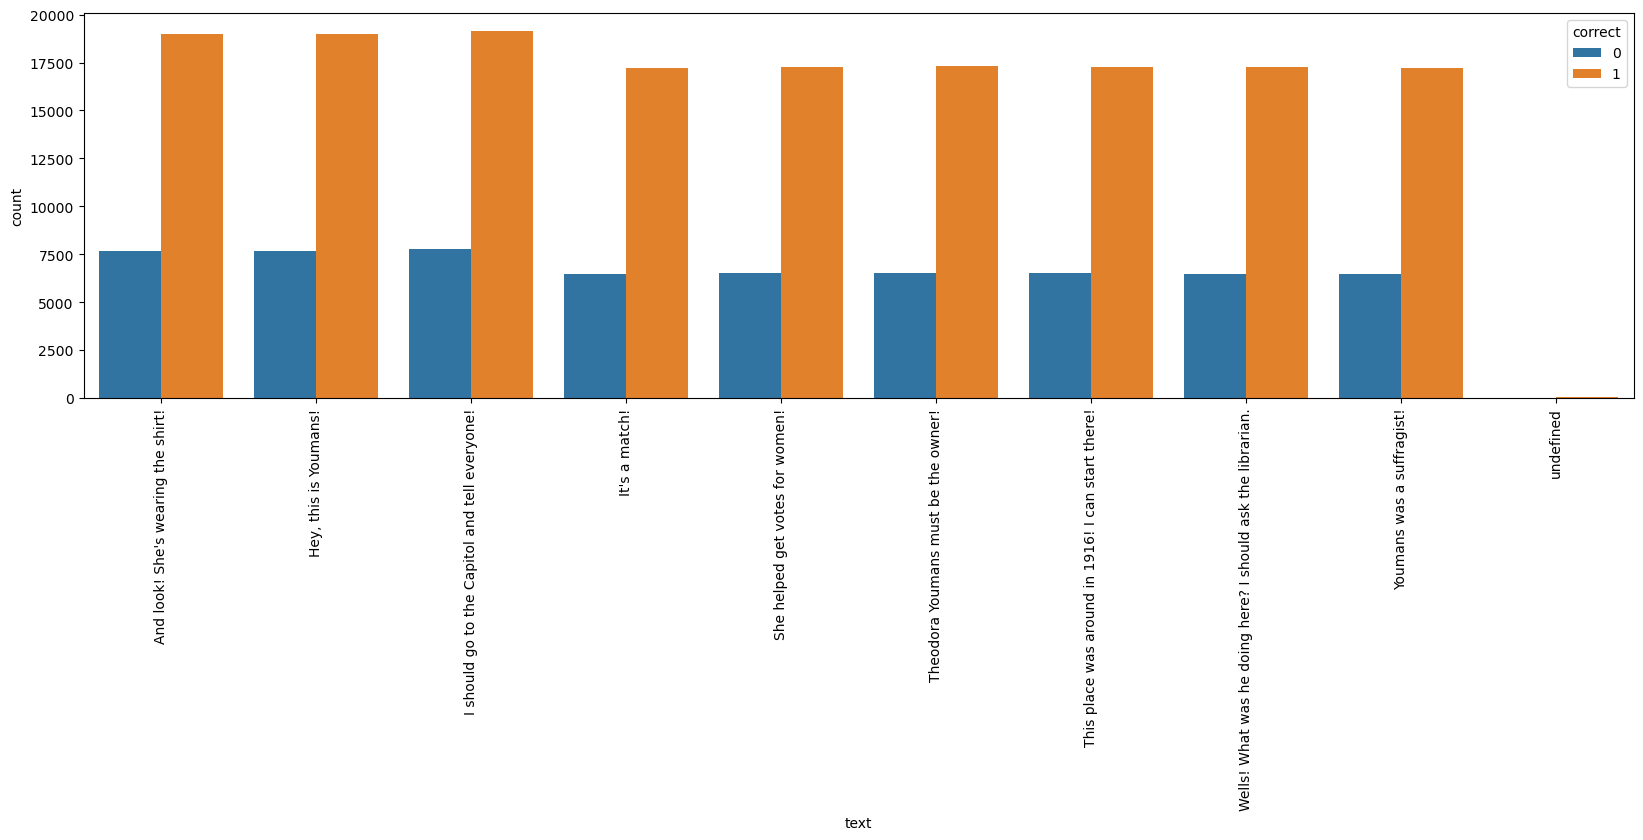

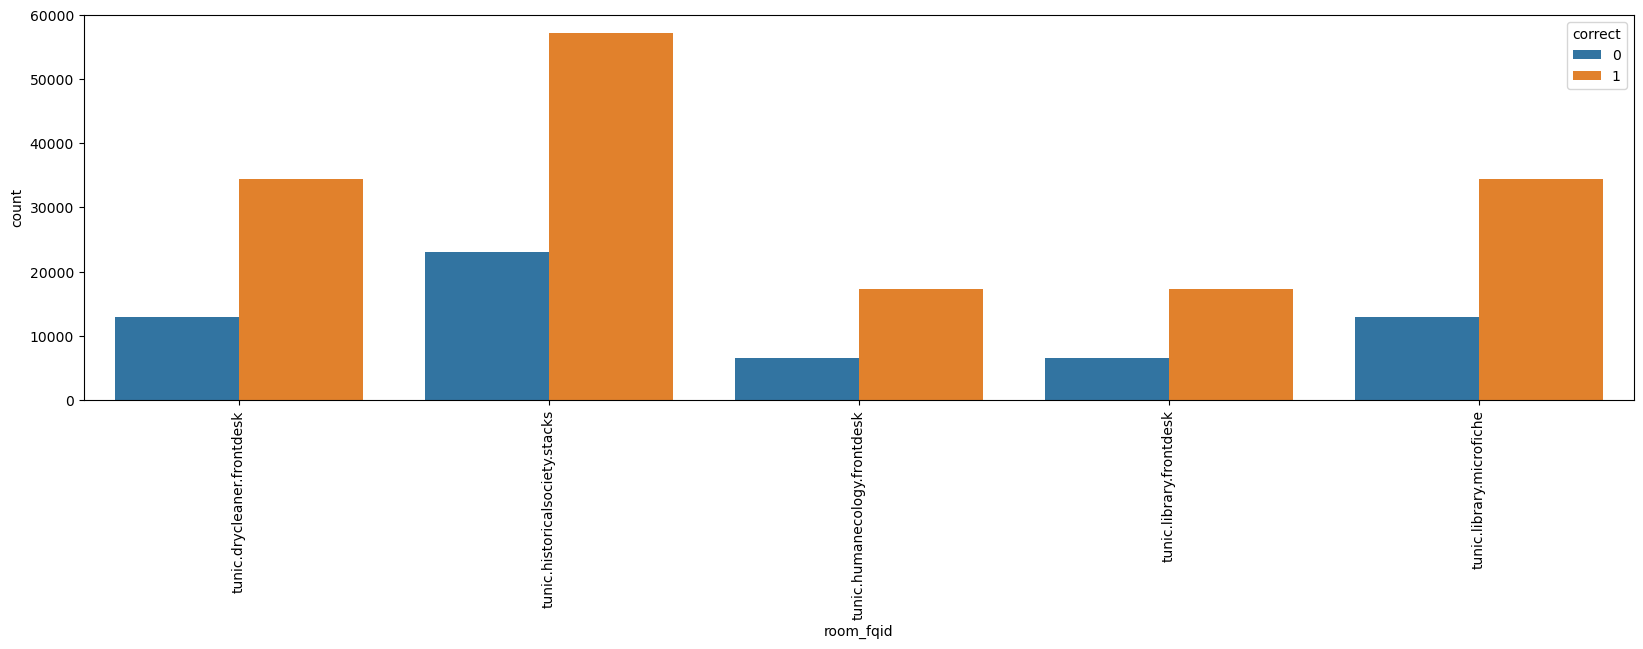

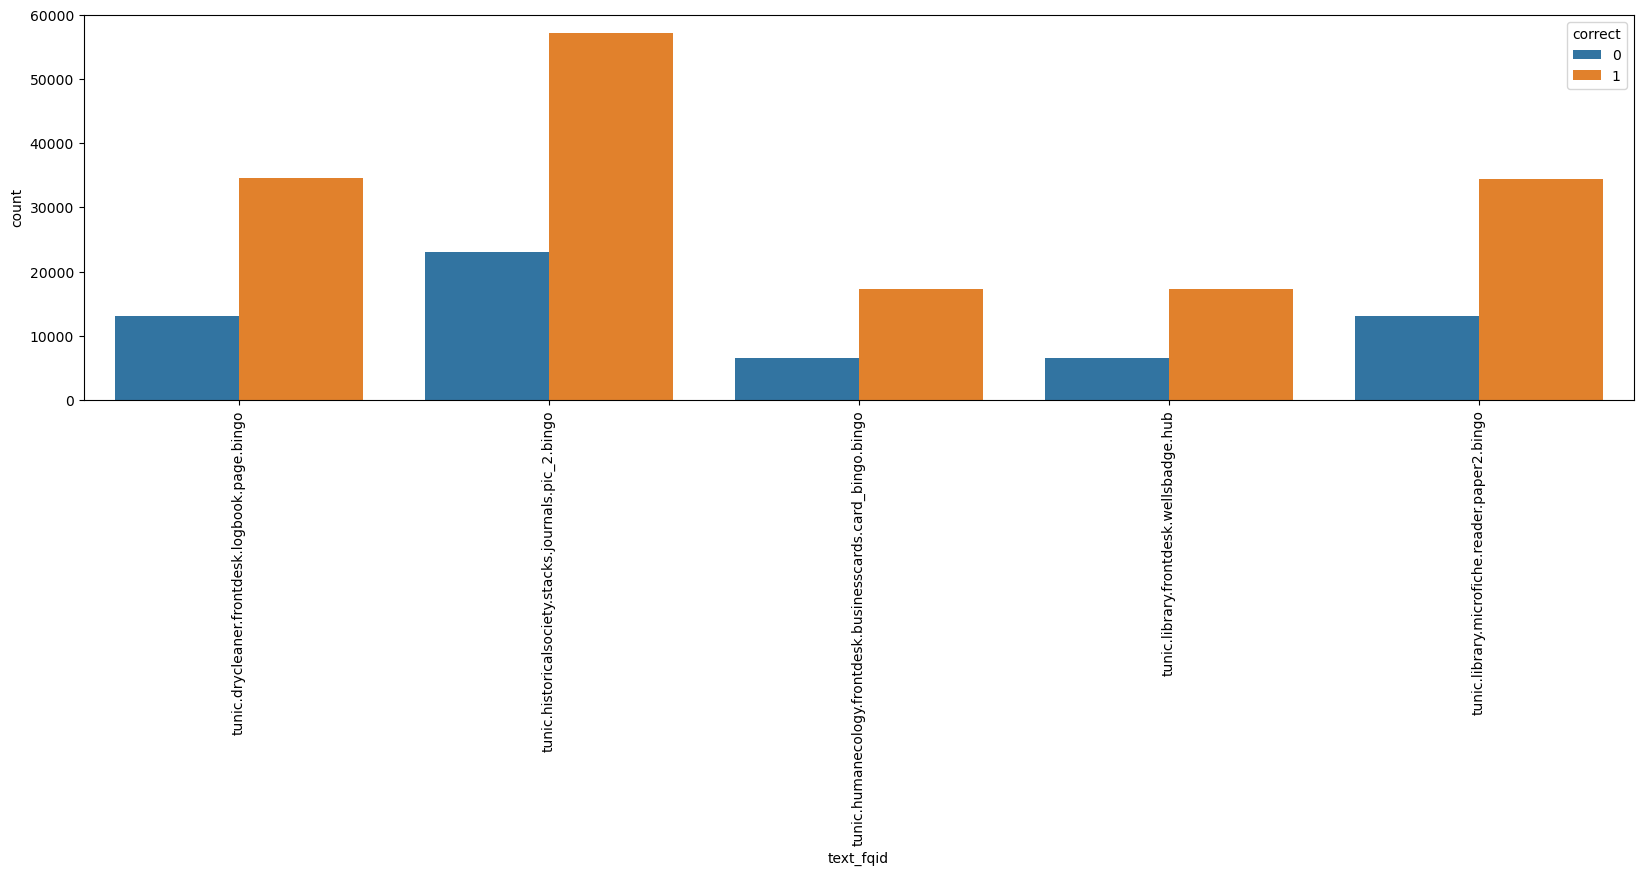

In [74]:
cat_fields_list = ["text", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__notification_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

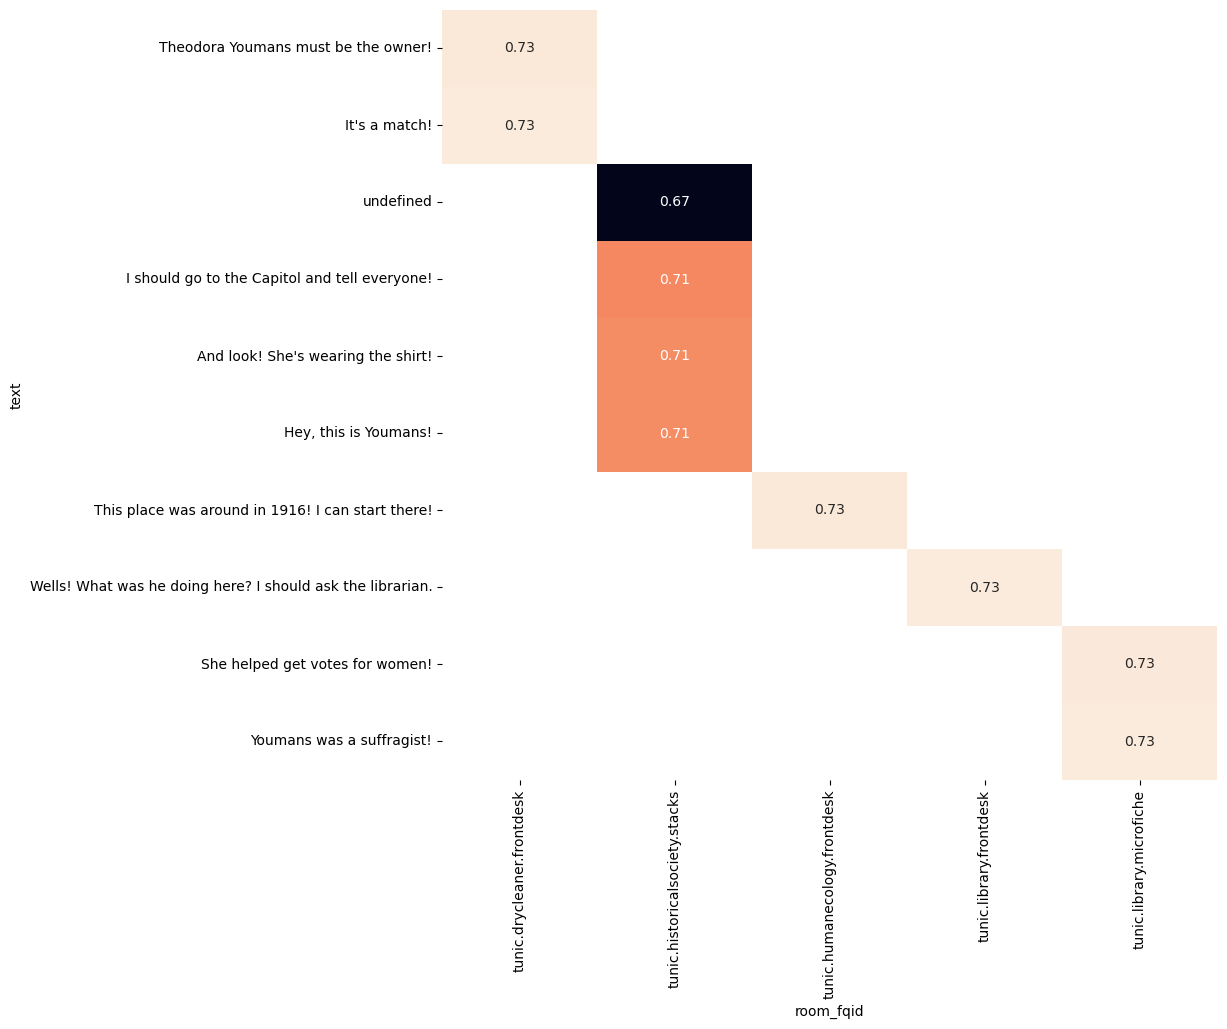

In [75]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

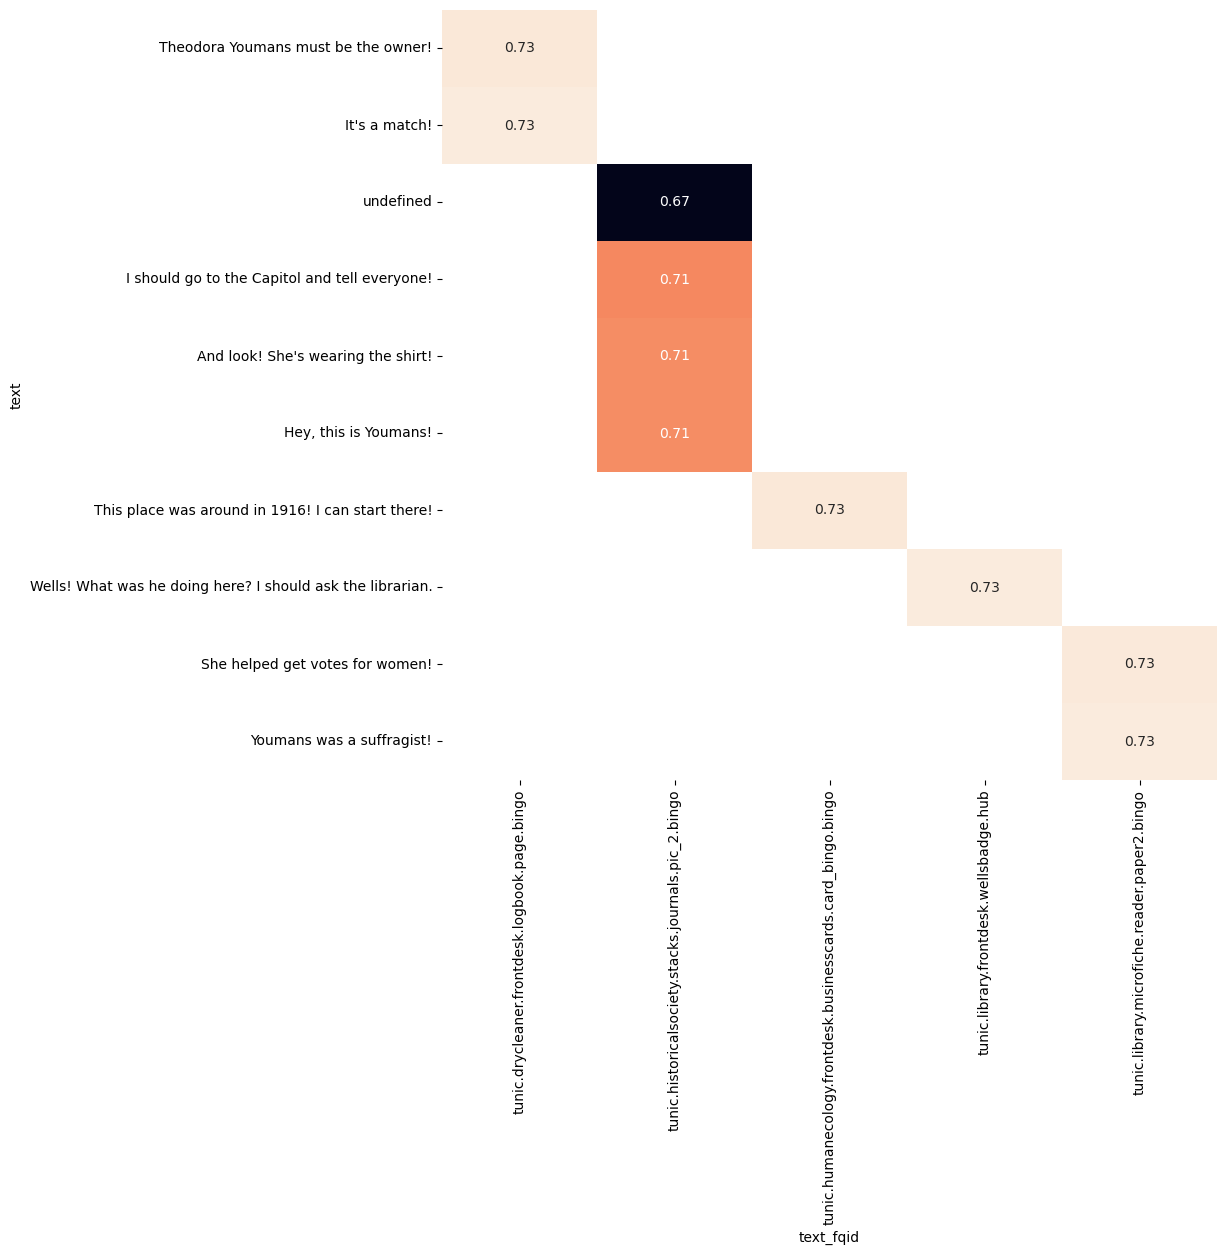

In [76]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

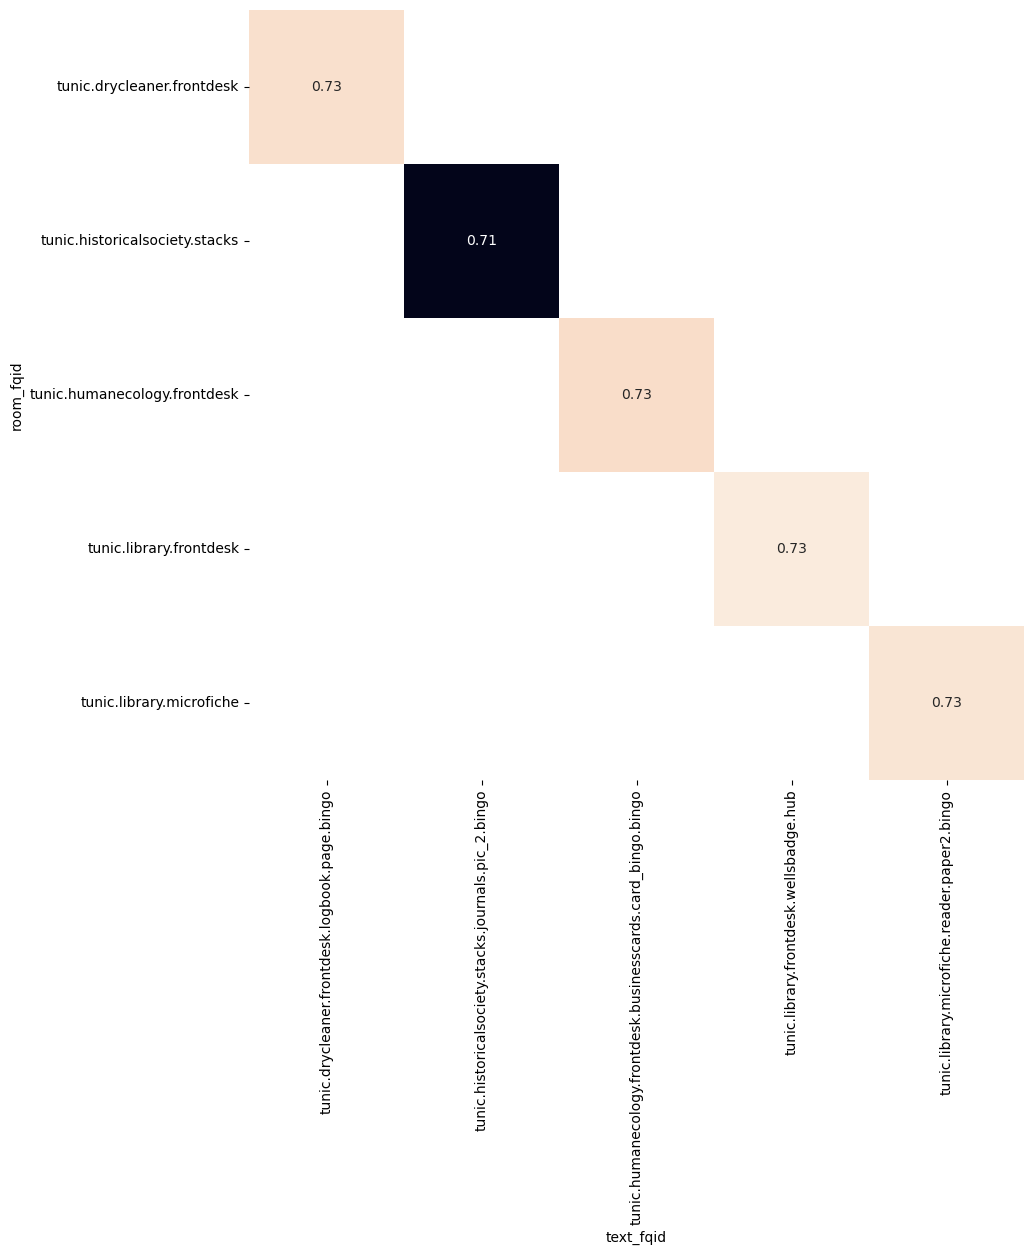

In [77]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

## `event_name` == `"object_click"`

In [78]:
df__object_click = df[df["event_name"] == "object_click"].reset_index(drop=True)
df__object_click.head()

session_id  index  elapsed_time    event_name   name  level  page  \
0  20090312431273200    305        339994  object_click  basic    7.0   NaN   
1  20090312431273200    307        342227  object_click  basic    7.0   NaN   
2  20090312431273200    309        343111  object_click  basic    7.0   NaN   
3  20090312431273200    312        345413  object_click  basic    7.0   NaN   
4  20090312431273200    314        346661  object_click  basic    7.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       396.50        -11.0          755.0          341.0             NaN   
1       400.25          0.0          758.0          330.0             NaN   
2       225.25        -19.0          583.0          349.0             NaN   
3       135.25       -105.0          493.0          435.0             NaN   
4       133.25       -104.0          491.0          434.0             NaN   

        text                            fqid                     room_fqid  \
0  undefined       businesscards.card_0.next  tunic.humanecology.frontdesk   
1  undefined       businesscards.card_1.next  tunic.humanecology.frontdesk   
2  undefined                   businesscards  tunic.humanecology.frontdesk   
3  undefined  businesscards.card_bingo.bingo  tunic.humanecology.frontdesk   
4  undefined                   businesscards  tunic.humanecology.frontdesk   

  text_fqid fullscreen hq music  correct  
0       NaN          0  0     1        1  
1       NaN          0  0     1        1  
2       NaN          0  0     1        1  
3       NaN          0  0     1        1  
4       NaN          0  0     1        1

#### Update Category Fields

In [79]:
df__object_click = recategorize_category_typed_fields(df__object_click)

In [80]:
summary = summarize_data_info(df__object_click)
summary

Data Shape: (1120858, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      5604   
elapsed_time       int32           0.0    752387   
event_name      category           0.0         1   
name            category           0.0         2   
level            float16           0.0         8   
page             float16           1.0         0   
room_coor_x      float16           0.0     14151   
room_coor_y      float16           0.0     12965   
screen_coor_x    float16           0.0      3624   
screen_coor_y    float16           0.0      3186   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0        26   
room_fqid       category           0.0         8   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                 first_value                  second_value  \
session_id                 20090312431273200             20090312431273200   
index                                    305                           307   
elapsed_time                          339994                        342227   
event_name                      object_click                  object_click   
name                                   basic                         basic   
level                                    7.0                           7.0   
page                                     NaN                           NaN   
room_coor_x                            396.5                        400.25   
room_coor_y                            -11.0                           0.0   
screen_coor_x                          755.0                         758.0   
screen_coor_y                          341.0                         330.0   
hover_duration                           NaN                           NaN   
text                               undefined                     undefined   
fqid               businesscards.card_0.next     businesscards.card_1.next   
room_fqid       tunic.humanecology.frontdesk  tunic.humanecology.frontdesk   
text_fqid                                nan                           nan   
fullscreen                                 0                             0   
hq                                         0                             0   
music                                      1                             1   
correct                                    1                             1   

                                 third_value                  min  \
session_id                 20090312431273200  20090312431273200.0   
index                                    309                  0.0   
elapsed_time                          343111                  0.0   
event_name                      object_click                  NaN   
name                                   basic                  NaN   
level                                    7.0                  5.0   
page                                     NaN                  NaN   
room_coor_x                           225.25               -906.0   
room_coor_y                            -19.0               -520.0   
screen_coor_x                          583.0                  0.0   
screen_coor_y                          349.0                  0.0   
hover_duration                           NaN                  NaN   
text                               undefined                  NaN   
fqid                           businesscards                  NaN   
room_fqid       tunic.humanecology.frontdesk                  NaN   
text_fqid                                nan                  NaN   
fullscreen                                 0                  NaN   
hq                                       

#### Insights

- `name` field has two values (basic, close).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

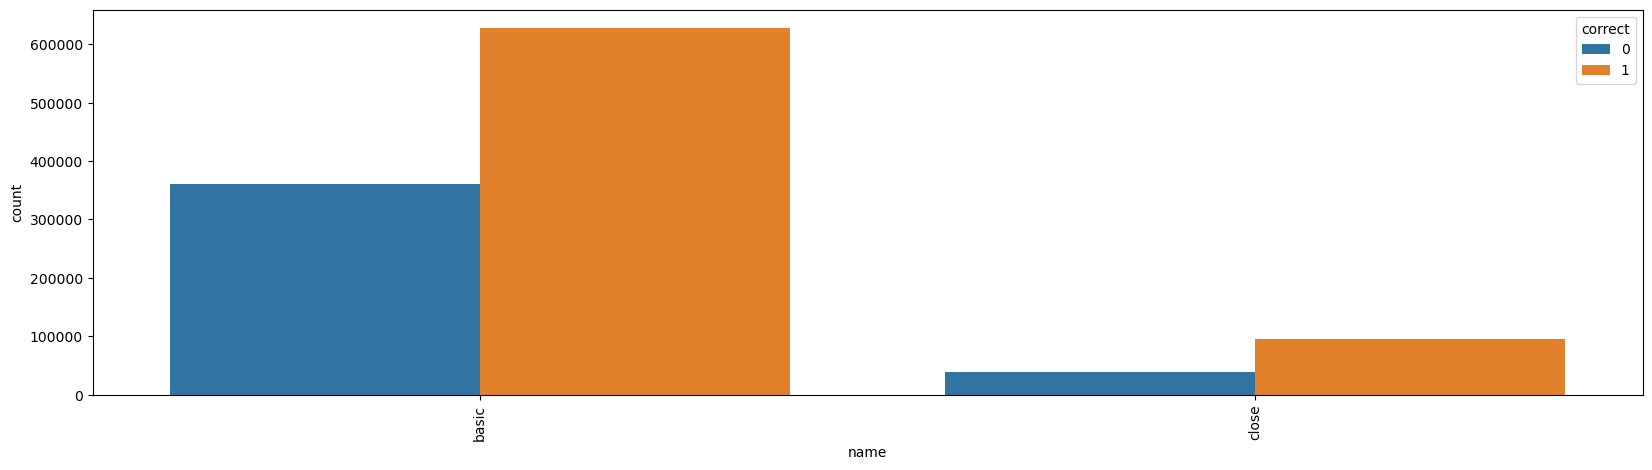

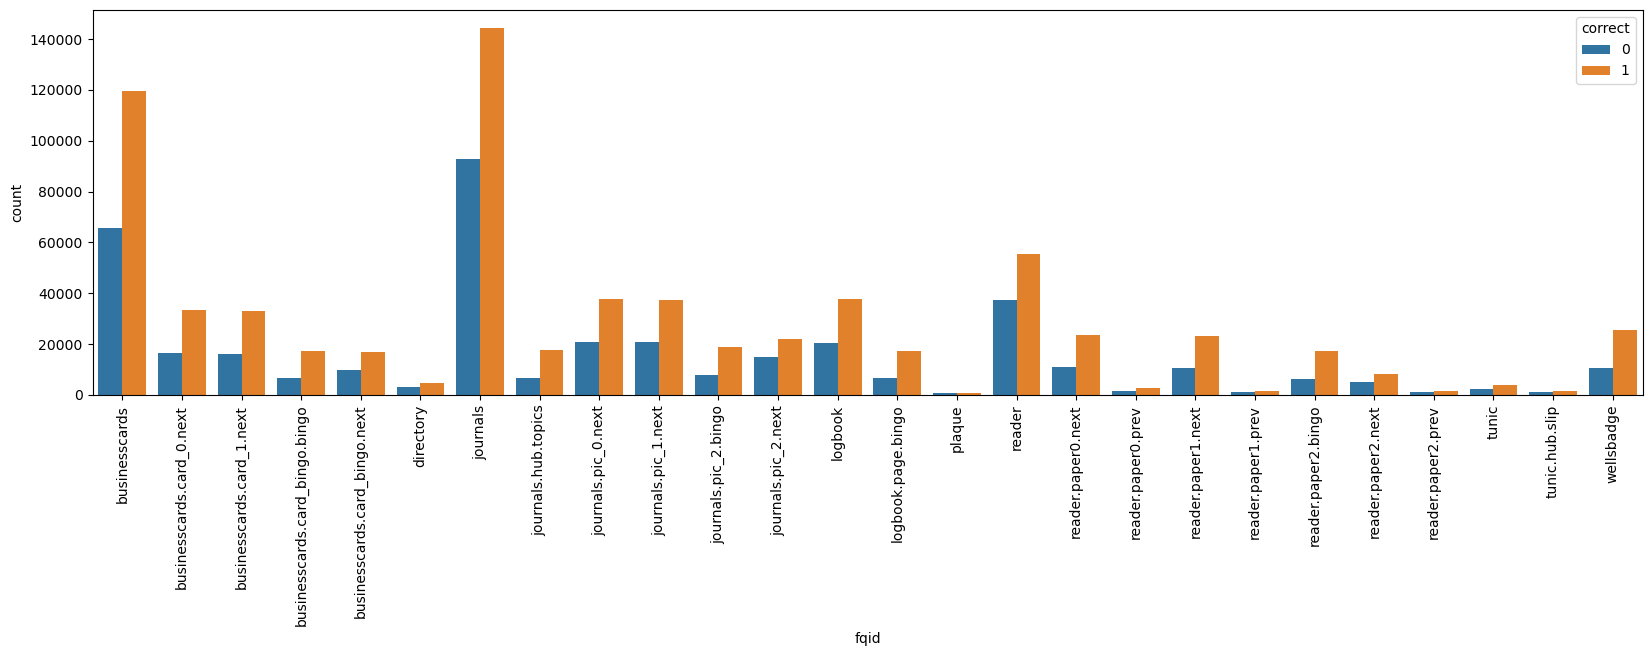

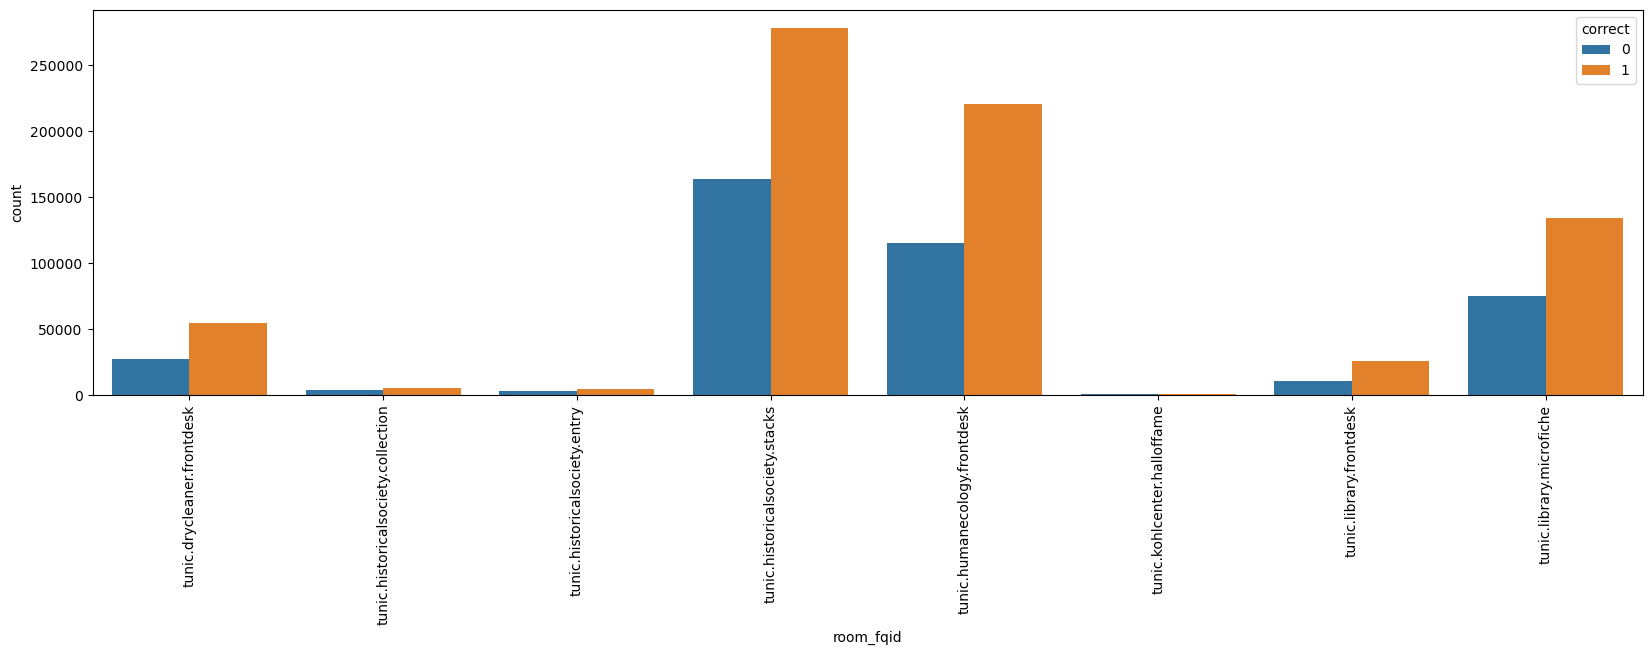

In [81]:
cat_fields_list = ["name", "fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__object_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

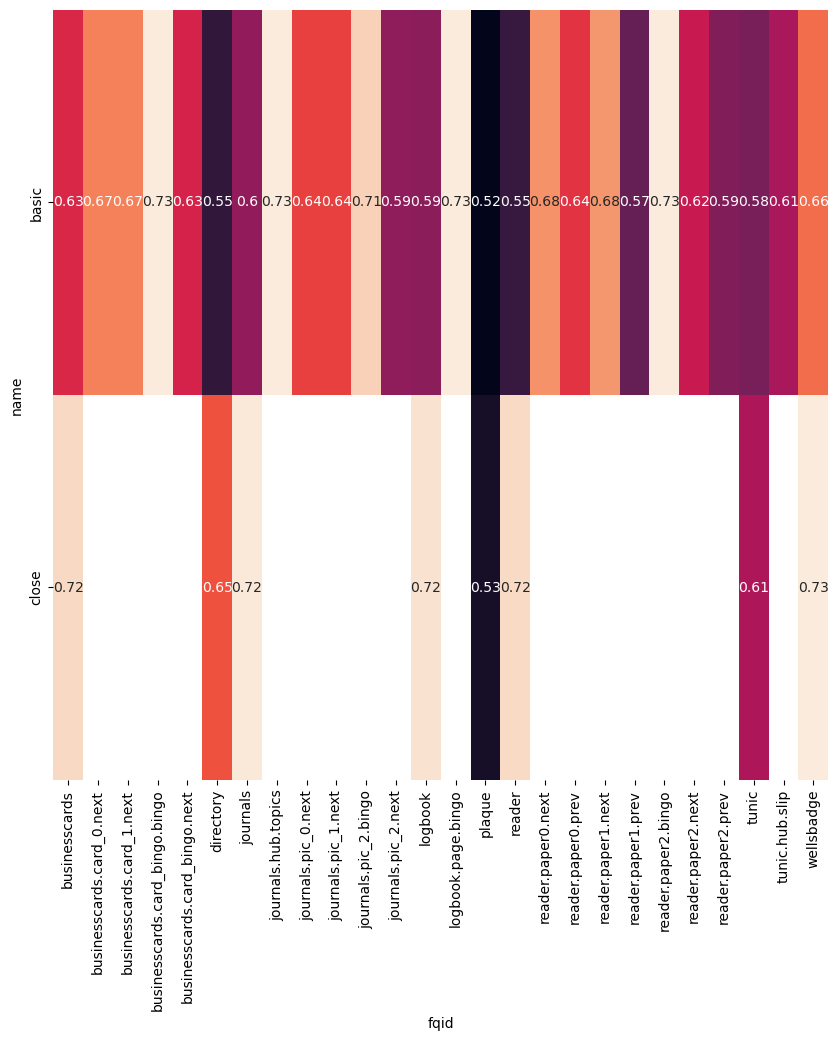

In [82]:
col_pair = ["name", "fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

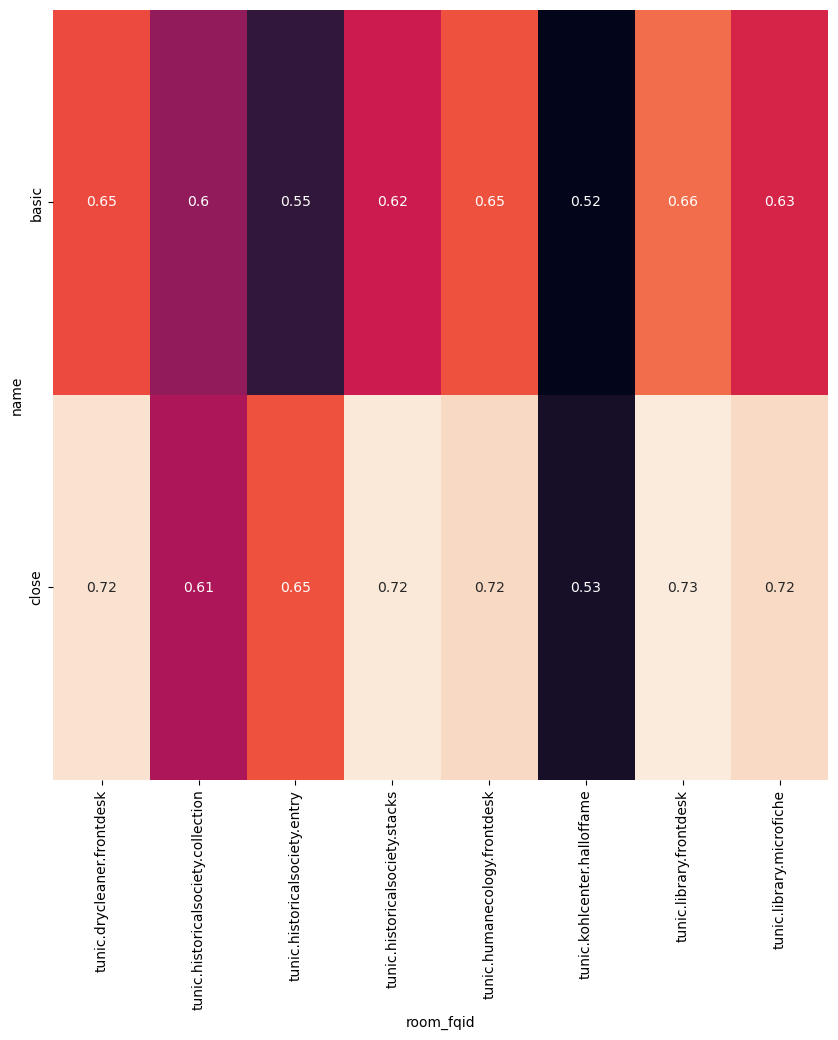

In [83]:
col_pair = ["name", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

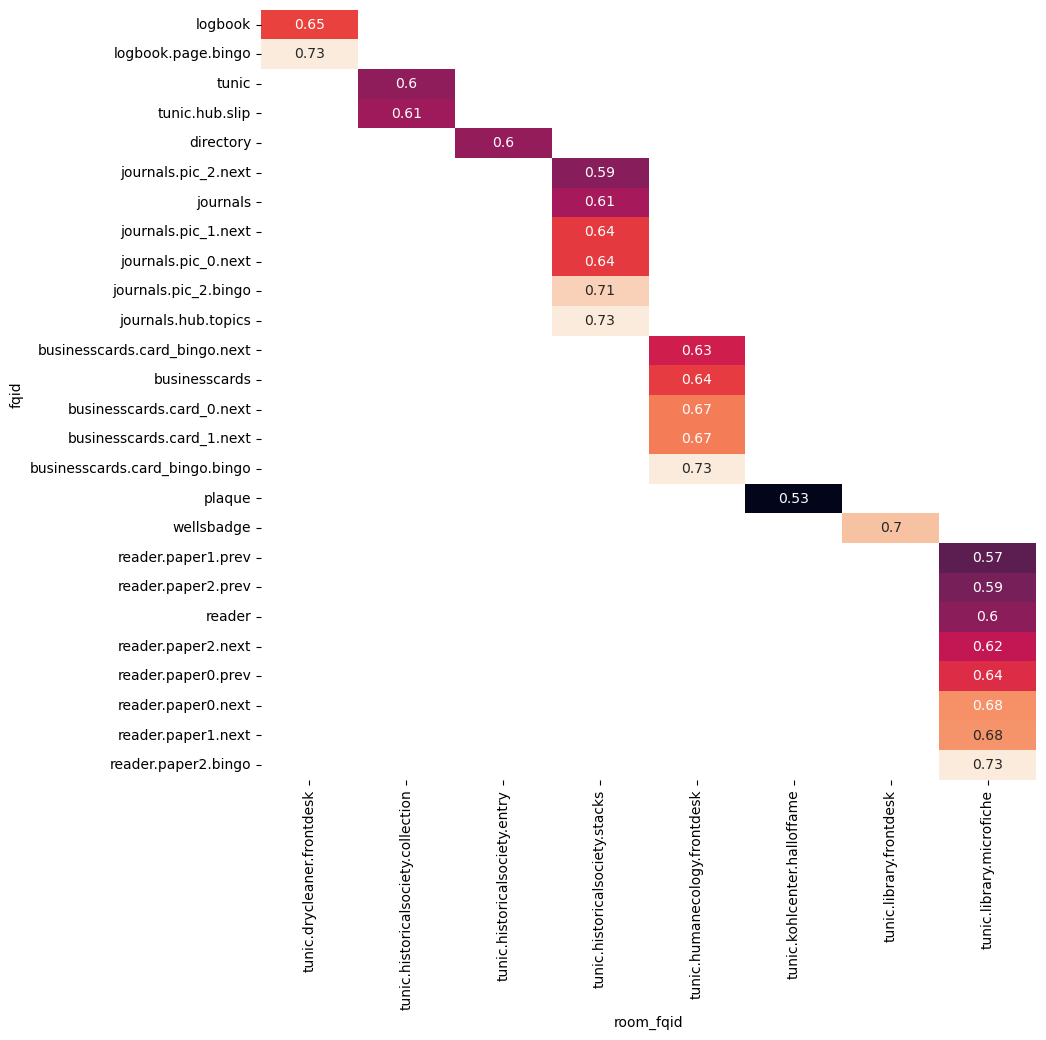

In [84]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

## `event_name` == `"object_hover"`

In [85]:
df__object_hover = df[df["event_name"] == "object_hover"].reset_index(drop=True)
df__object_hover.head()

session_id  index  elapsed_time    event_name       name  level  \
0  20090312431273200    303        338929  object_hover  undefined    7.0   
1  20090312431273200    304        339045  object_hover  undefined    7.0   
2  20090312431273200    306        341328  object_hover  undefined    7.0   
3  20090312431273200    308        342946  object_hover  undefined    7.0   
4  20090312431273200    310        343961  object_hover  undefined    7.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN          NaN          NaN            NaN            NaN   
1   NaN          NaN          NaN            NaN            NaN   
2   NaN          NaN          NaN            NaN            NaN   
3   NaN          NaN          NaN            NaN            NaN   
4   NaN          NaN          NaN            NaN            NaN   

   hover_duration       text                           fqid  \
0            68.0  undefined      businesscards.card_0.next   
1            50.0  undefined      businesscards.card_0.next   
2          1950.0  undefined      businesscards.card_0.next   
3           867.0  undefined      businesscards.card_1.next   
4            17.0  undefined  businesscards.card_bingo.next   

                      room_fqid text_fqid fullscreen hq music  correct  
0  tunic.humanecology.frontdesk       NaN          0  0     1        1  
1  tunic.humanecology.frontdesk       NaN          0  0     1        1  
2  tunic.humanecology.frontdesk       NaN          0  0     1        1  
3  tunic.humanecology.frontdesk       NaN          0  0     1        1  
4  tunic.humanecology.frontdesk       NaN          0  0     1        1

#### Update Category Fields

In [86]:
df__object_hover = recategorize_category_typed_fields(df__object_hover)

In [87]:
summary = summarize_data_info(df__object_hover)
summary

Data Shape: (524264, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     21690   
index              int16           0.0      2472   
elapsed_time       int32           0.0    423095   
event_name      category           0.0         1   
name            category           0.0         2   
level            float16           0.0         8   
page             float16           1.0         0   
room_coor_x      float16           1.0         0   
room_coor_y      float16           1.0         0   
screen_coor_x    float16           1.0         0   
screen_coor_y    float16           1.0         0   
hover_duration   float32           0.0     18577   
text            category           0.0         1   
fqid            category           0.0        36   
room_fqid       category           0.0         8   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                 first_value                  second_value  \
session_id                 20090312431273200             20090312431273200   
index                                    303                           304   
elapsed_time                          338929                        339045   
event_name                      object_hover                  object_hover   
name                               undefined                     undefined   
level                                    7.0                           7.0   
page                                     NaN                           NaN   
room_coor_x                              NaN                           NaN   
room_coor_y                              NaN                           NaN   
screen_coor_x                            NaN                           NaN   
screen_coor_y                            NaN                           NaN   
hover_duration                          68.0                          50.0   
text                               undefined                     undefined   
fqid               businesscards.card_0.next     businesscards.card_0.next   
room_fqid       tunic.humanecology.frontdesk  tunic.humanecology.frontdesk   
text_fqid                                nan                           nan   
fullscreen                                 0                             0   
hq                                         0                             0   
music                                      1                             1   
correct                                    1                             1   

                                 third_value                  min  \
session_id                 20090312431273200  20090312431273200.0   
index                                    306                  0.0   
elapsed_time                          341328                 29.0   
event_name                      object_hover                  NaN   
name                               undefined                  NaN   
level                                    7.0                  5.0   
page                                     NaN                  NaN   
room_coor_x                              NaN                  NaN   
room_coor_y                              NaN                  NaN   
screen_coor_x                            NaN                  NaN   
screen_coor_y                            NaN                  NaN   
hover_duration                        1950.0                  0.0   
text                               undefined                  NaN   
fqid               businesscards.card_0.next                  NaN   
room_fqid       tunic.humanecology.frontdesk                  NaN   
text_fqid                                nan                  NaN   
fullscreen                                 0                  NaN   
hq                                       

#### Insights

- `name` field has two values (basic, undefined).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`

#### Categorical Fields

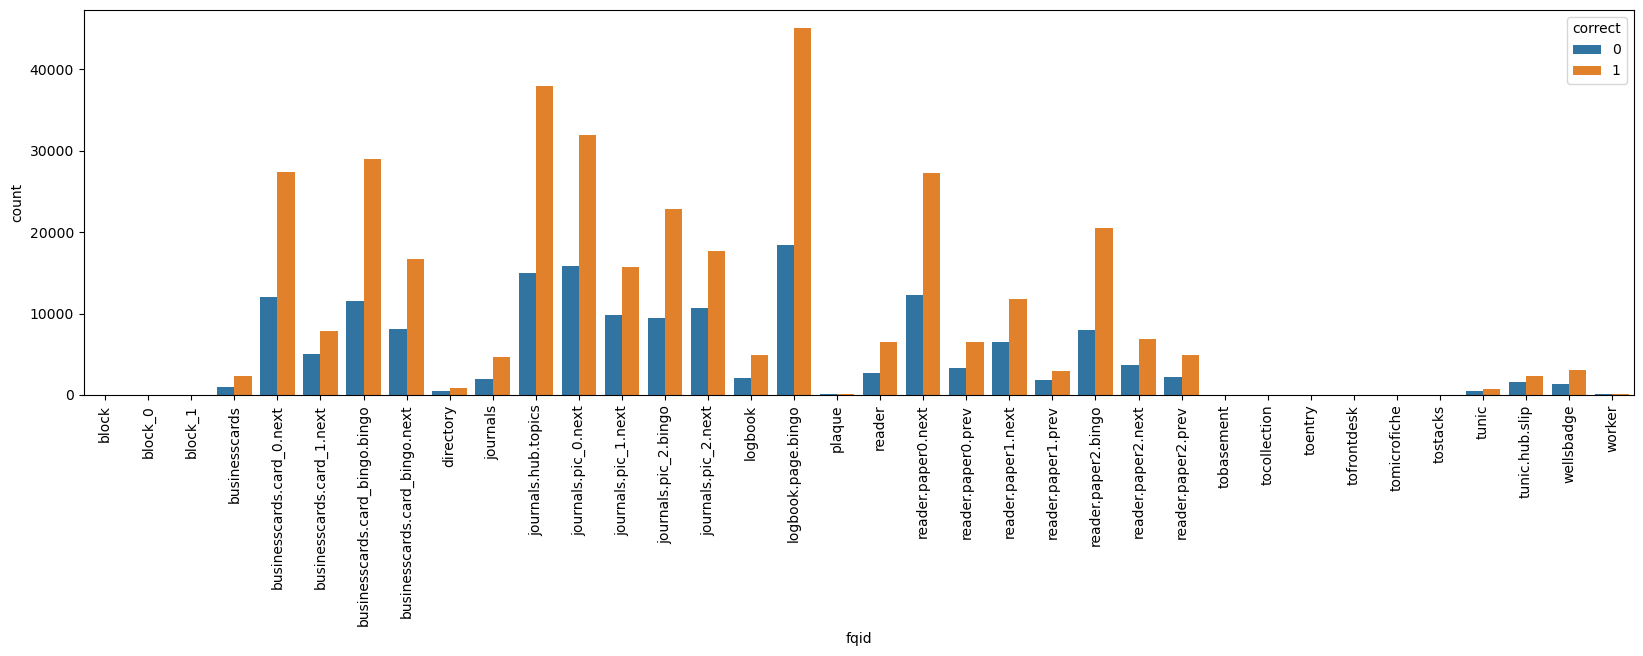

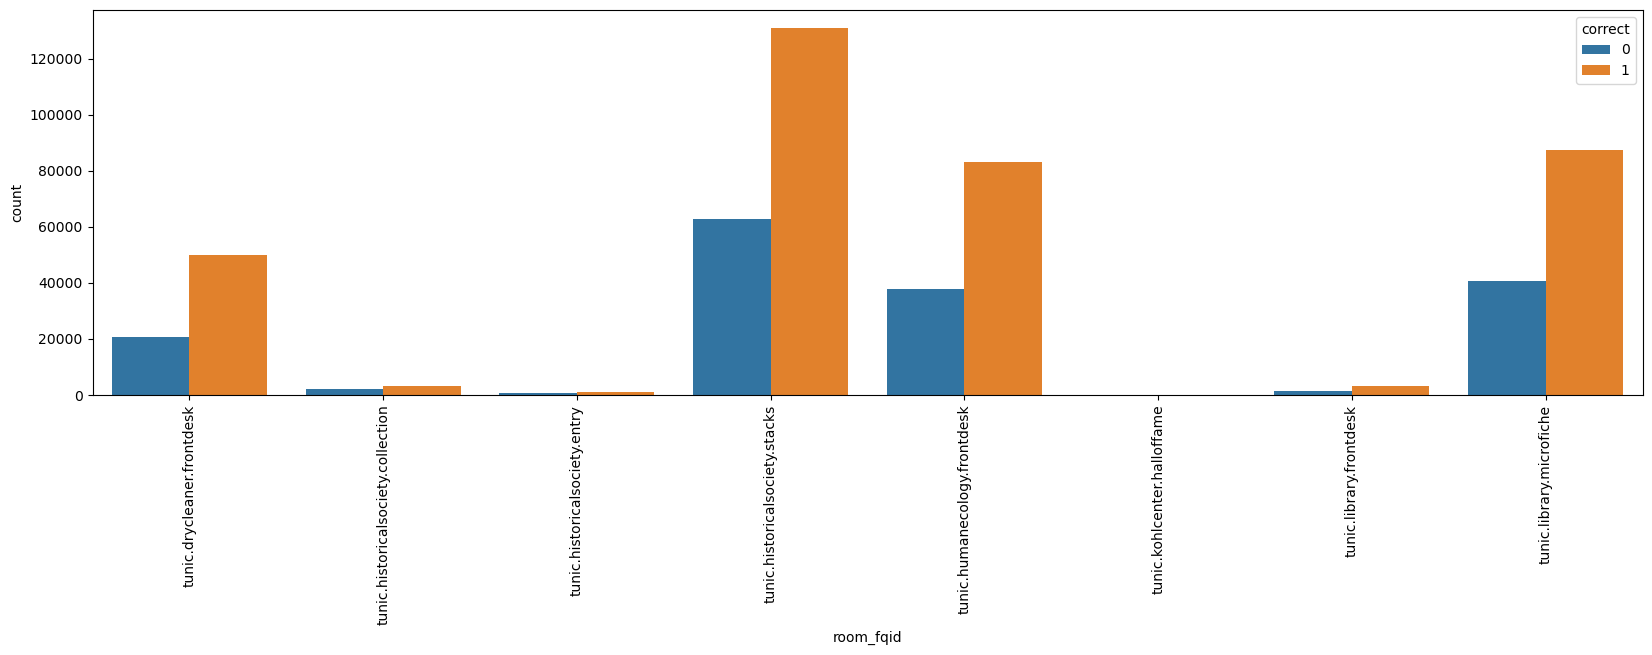

In [88]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__object_hover, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

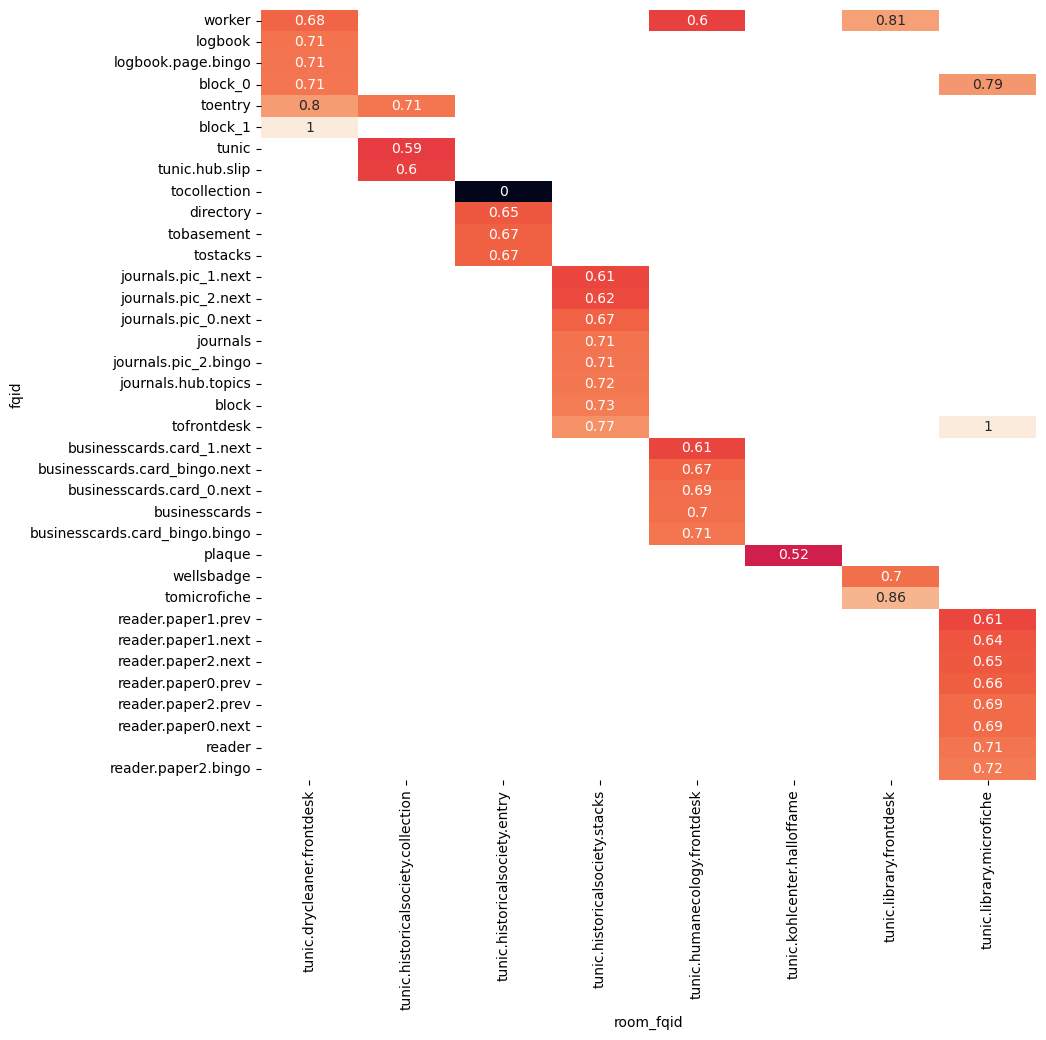

In [89]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_hover, col_pair), figsize=(10, 10))

## `event_name` == `"observation_click"`

In [90]:
df__observation_click = df[df["event_name"] == "observation_click"].reset_index(drop=True)
df__observation_click.head()

session_id  index  elapsed_time         event_name   name  level  \
0  20090312431273200    256        300382  observation_click  basic    6.0   
1  20090312433251036    157        281616  observation_click  basic    5.0   
2  20090312433251036    165        288949  observation_click  basic    5.0   
3  20090312433251036    222        378996  observation_click  basic    6.0   
4  20090312455206810    217        445207  observation_click  basic    6.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN       75.625   -32.000000          419.0          362.0   
1   NaN       86.750  -151.625000          517.0          483.0   
2   NaN      133.875   -67.312500          590.0          369.0   
3   NaN      132.625    67.000000          480.0          263.0   
4   NaN      -78.125    -7.332031          369.0          460.0   

   hover_duration                                 text        fqid  \
0             NaN  I bet the archivist could use this!     magnify   
1             NaN             Better check back later.  outtolunch   
2             NaN     Hmm. Button's still not working.     janitor   
3             NaN  I bet the archivist could use this!     magnify   
4             NaN  I bet the archivist could use this!     magnify   

                           room_fqid  \
0  tunic.historicalsociety.frontdesk   
1     tunic.historicalsociety.stacks   
2   tunic.historicalsociety.basement   
3  tunic.historicalsociety.frontdesk   
4  tunic.historicalsociety.frontdesk   

                                   text_fqid fullscreen hq music  correct  
0  tunic.historicalsociety.frontdesk.magnify          0  0     1        1  
1  tunic.historicalsociety.stacks.outtolunch          0  0     0        0  
2   tunic.historicalsociety.basement.janitor          0  0     0        0  
3  tunic.historicalsociety.frontdesk.magnify          0  0     0        0  
4  tunic.historicalsociety.frontdesk.magnify          1  1     1        1

#### Update Category Fields

In [91]:
df__observation_click = recategorize_category_typed_fields(df__observation_click)

In [92]:
summary = summarize_data_info(df__observation_click)
summary

Data Shape: (64988, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      1528   
elapsed_time       int32           0.0     62388   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         8   
page             float16           1.0         0   
room_coor_x      float16           0.0     12193   
room_coor_y      float16           0.0      7060   
screen_coor_x    float16           0.0      1422   
screen_coor_y    float16           0.0      1085   
hover_duration   float32           1.0         0   
text            category           0.0        13   
fqid            category           0.0         9   
room_fqid       category           0.0         8   
text_fqid       category           0.0        12   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                              first_value  \
session_id                              20090312431273200   
index                                                 256   
elapsed_time                                       300382   
event_name                              observation_click   
name                                                basic   
level                                                 6.0   
page                                                  NaN   
room_coor_x                                        75.625   
room_coor_y                                         -32.0   
screen_coor_x                                       419.0   
screen_coor_y                                       362.0   
hover_duration                                        NaN   
text                  I bet the archivist could use this!   
fqid                                              magnify   
room_fqid               tunic.historicalsociety.frontdesk   
text_fqid       tunic.historicalsociety.frontdesk.magnify   
fullscreen                                              0   
hq                                                      0   
music                                                   1   
correct                                                 1   

                                             second_value  \
session_id                              20090312433251036   
index                                                 157   
elapsed_time                                       281616   
event_name                              observation_click   
name                                                basic   
level                                                 5.0   
page                                                  NaN   
room_coor_x                                         86.75   
room_coor_y                                      -151.625   
screen_coor_x                                       517.0   
screen_coor_y                                       483.0   
hover_duration                                        NaN   
text                             Better check back later.   
fqid                                           outtolunch   
room_fqid                  tunic.historicalsociety.stacks   
text_fqid       tunic.historicalsociety.stacks.outtolunch   
fullscreen                                              0   
hq                                                      0   
music                                                   0   
correct                                                 0   

                                             third_value                  min  \
session_id                             20090312433251036  20090312431273200.0   
index                                                165                  1.0   
elapsed_time                                      288949                 88.0   
event_name                        

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

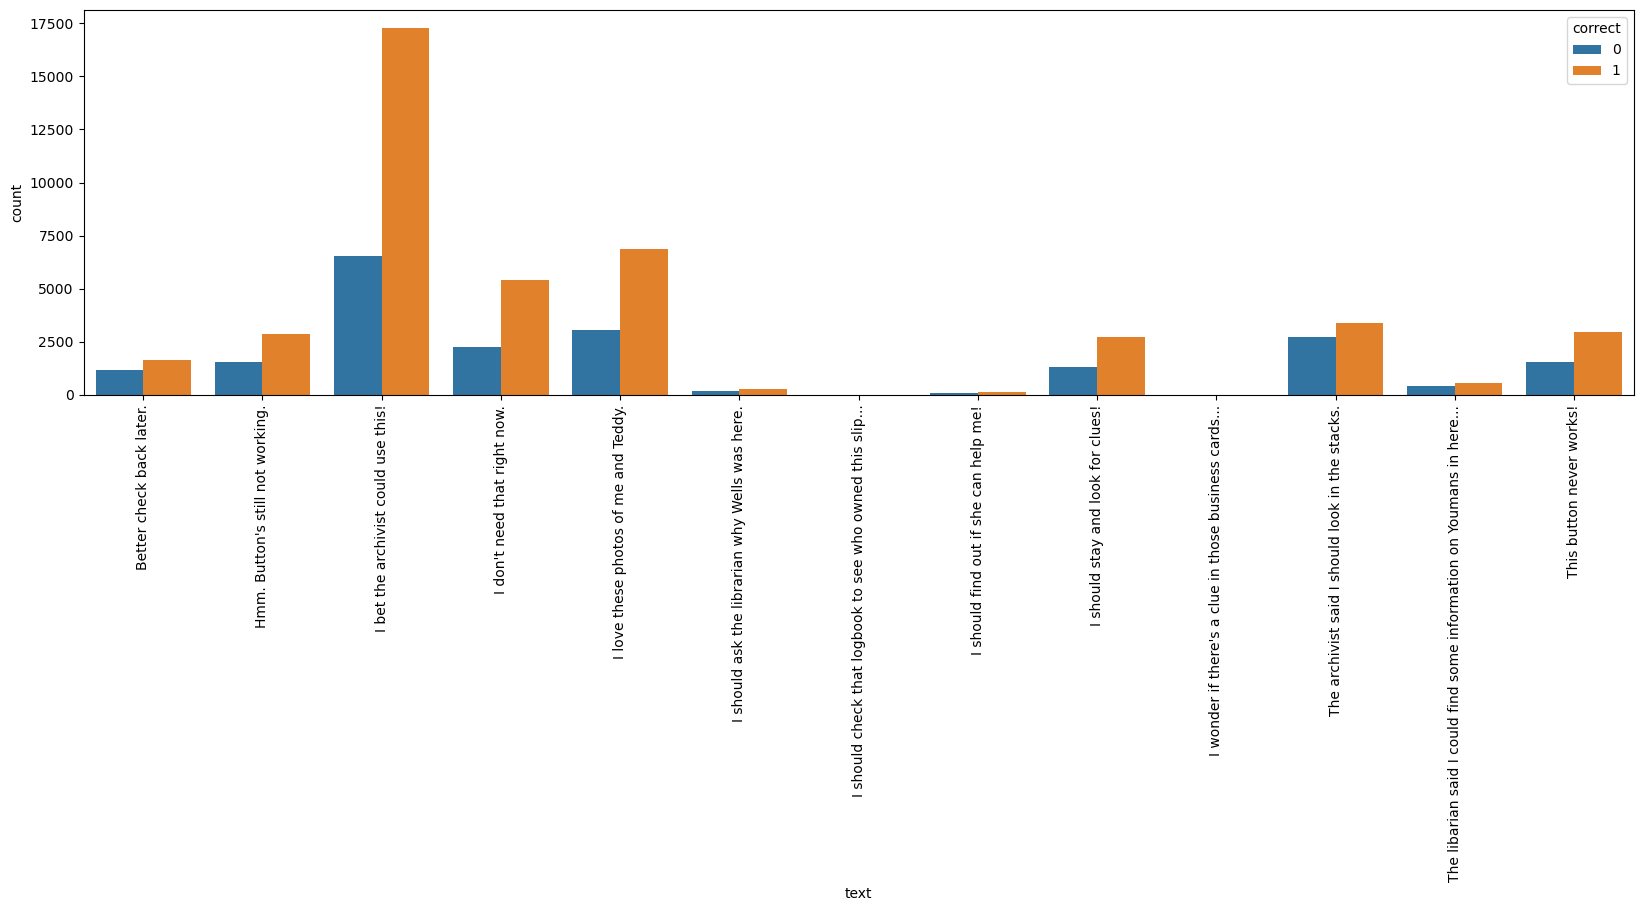

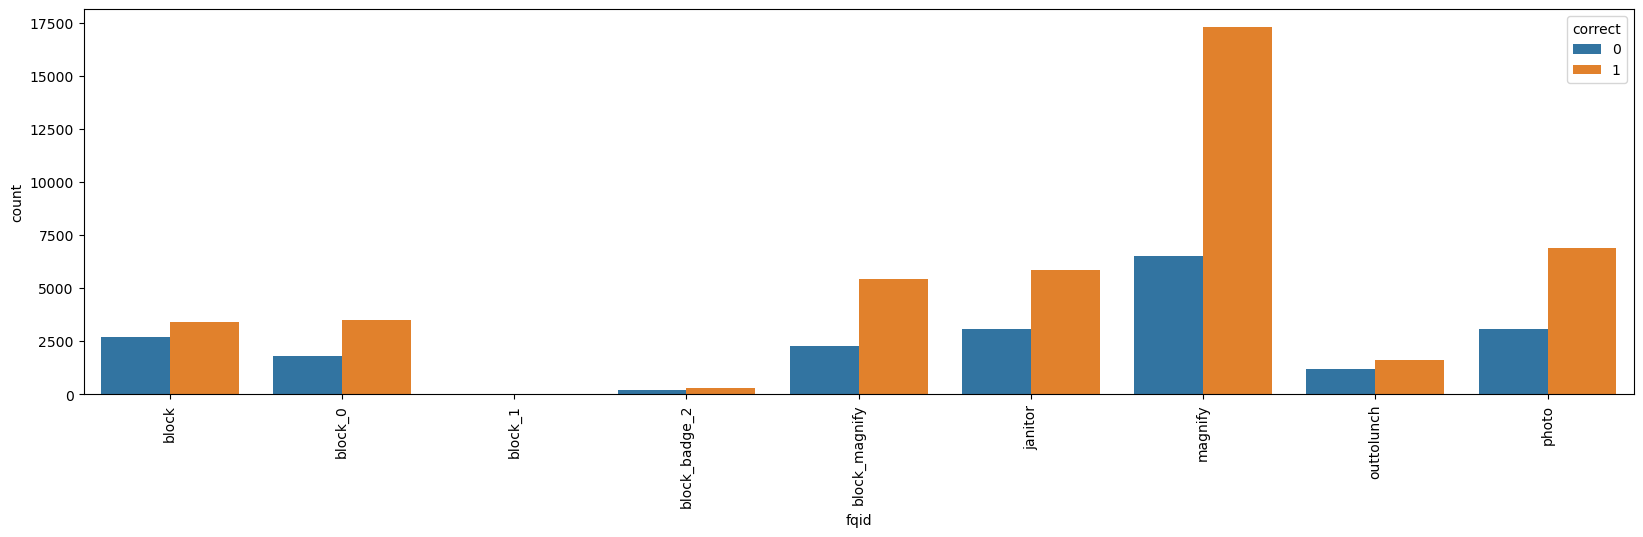

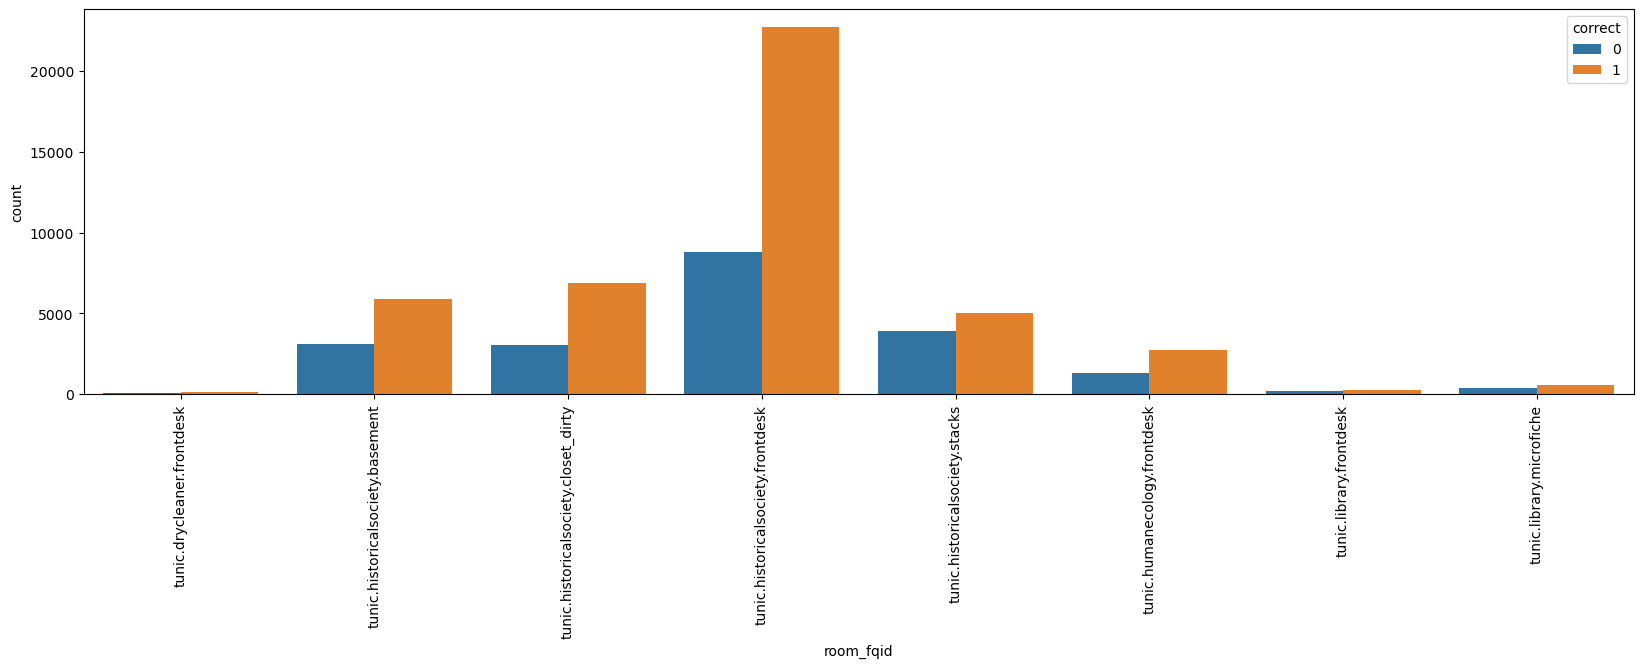

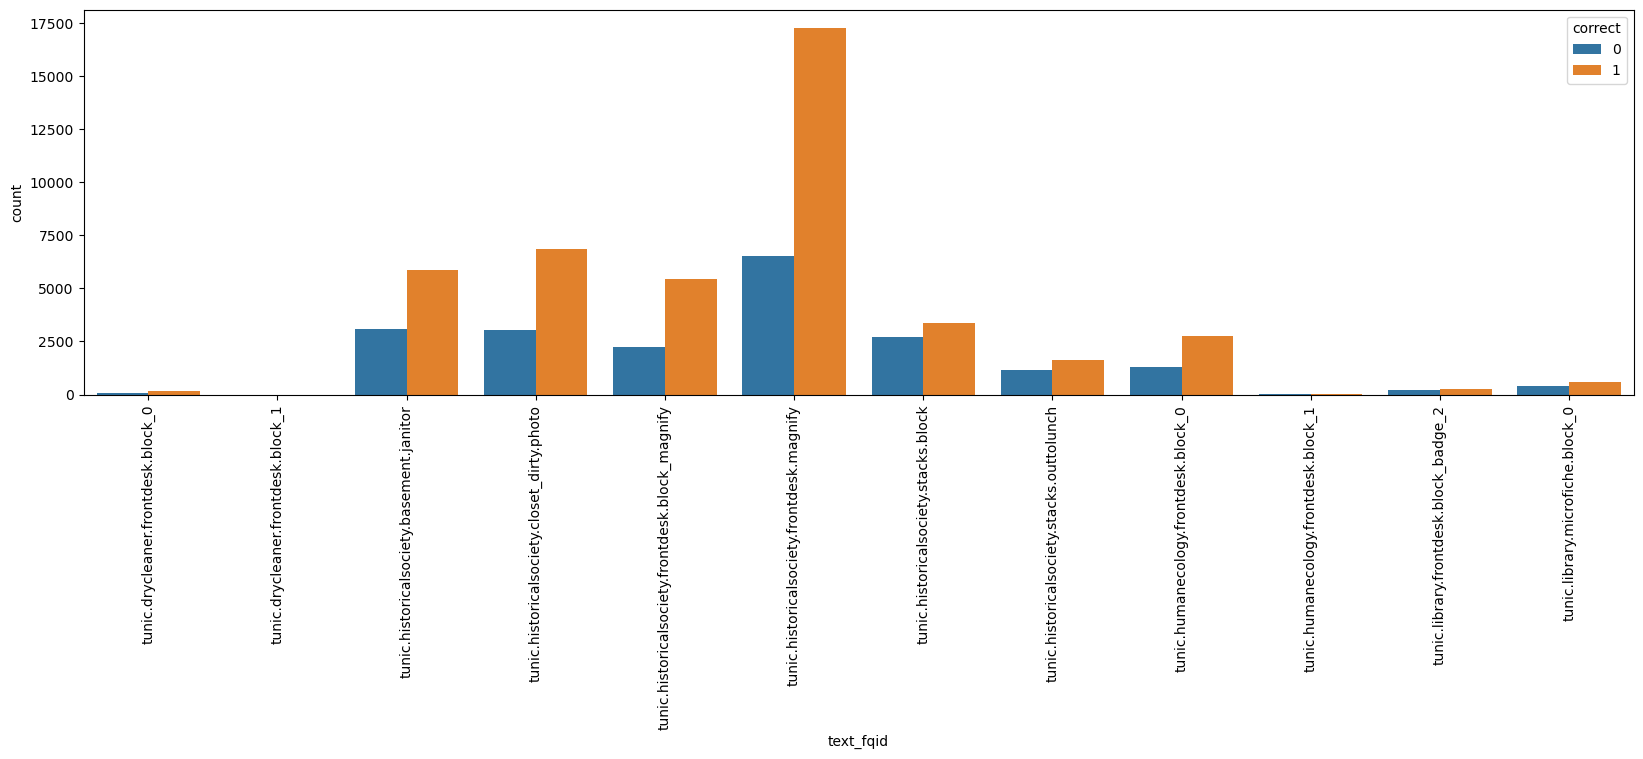

In [93]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__observation_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

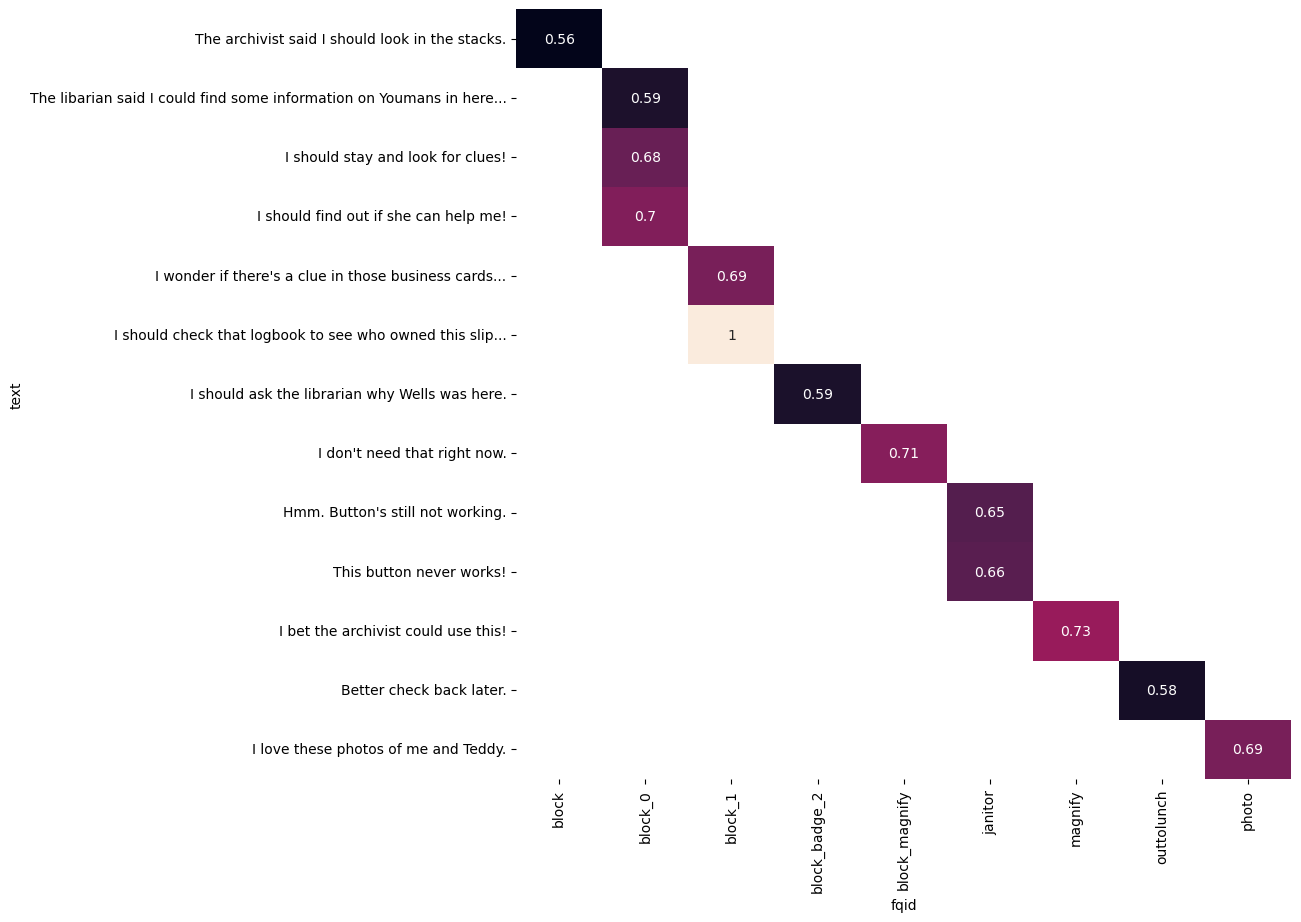

In [94]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

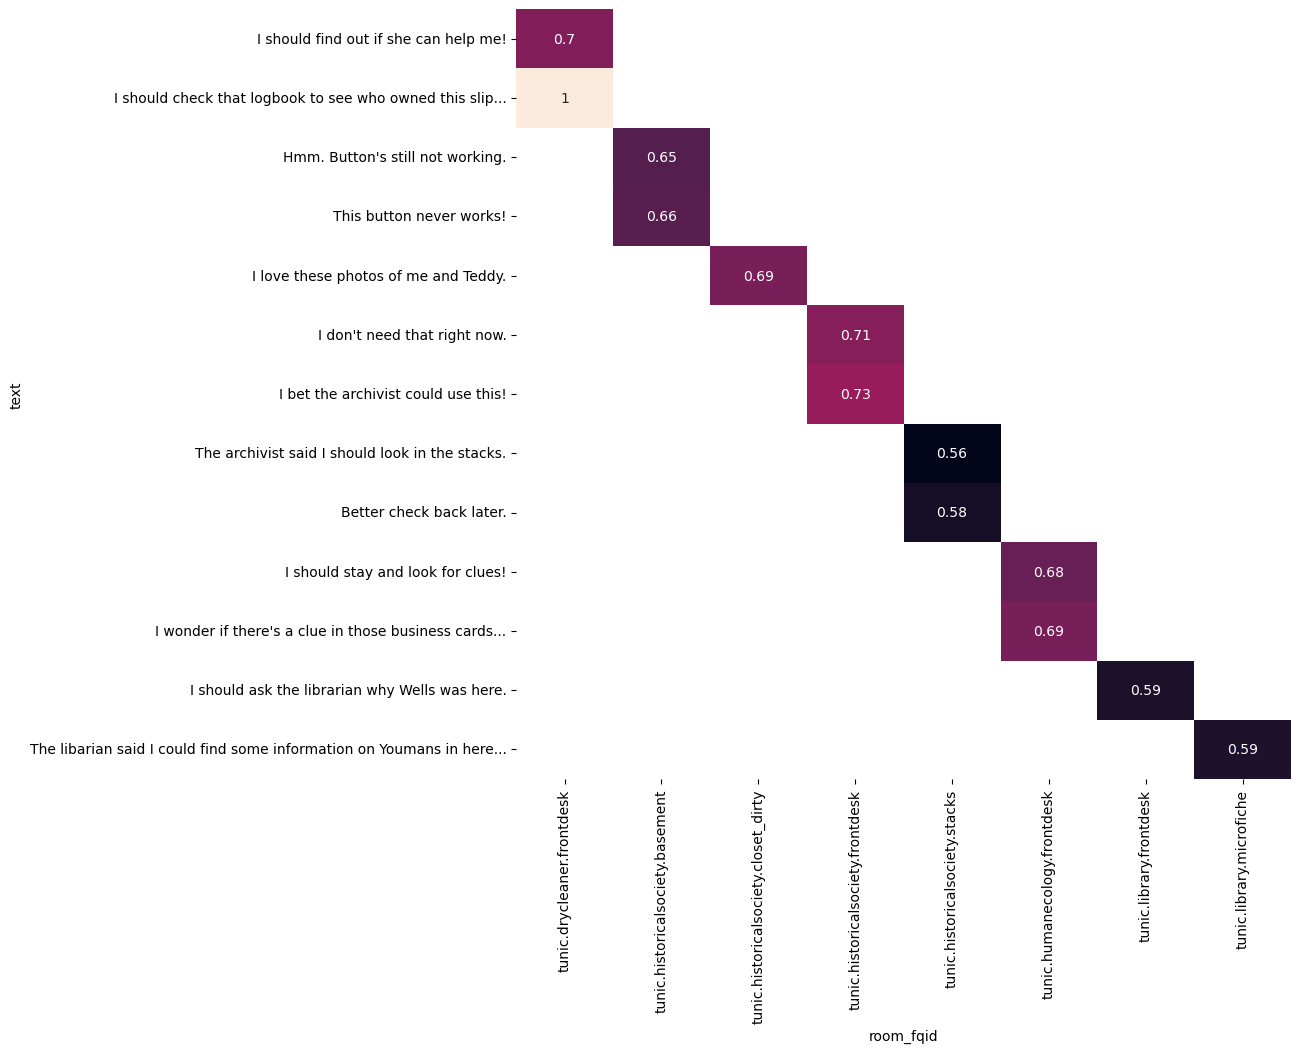

In [95]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

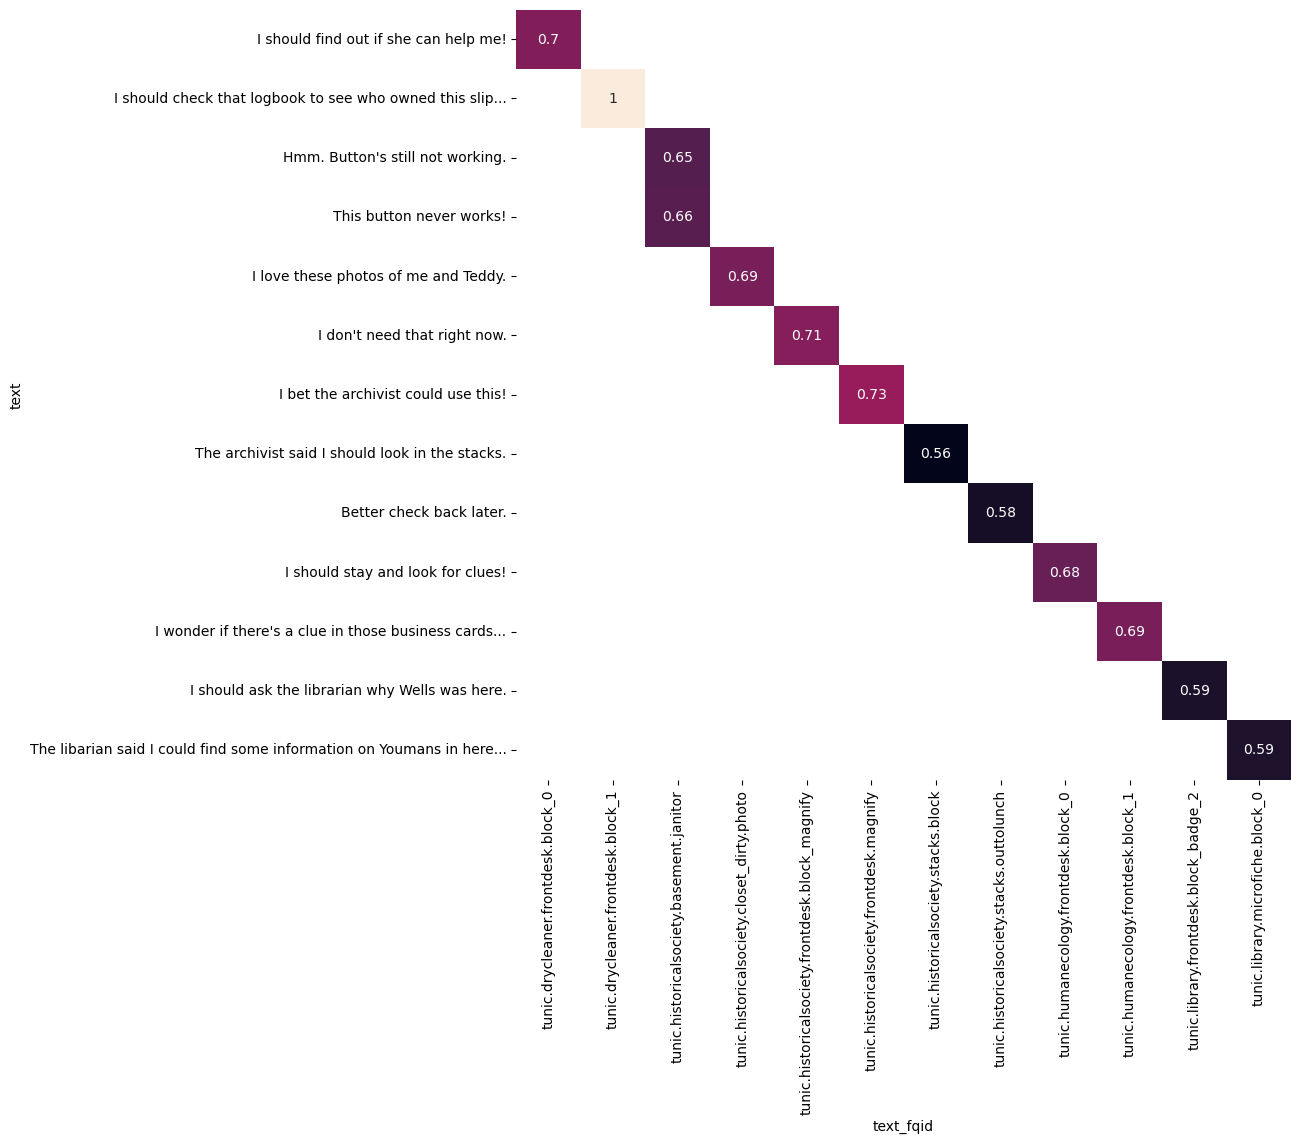

In [96]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

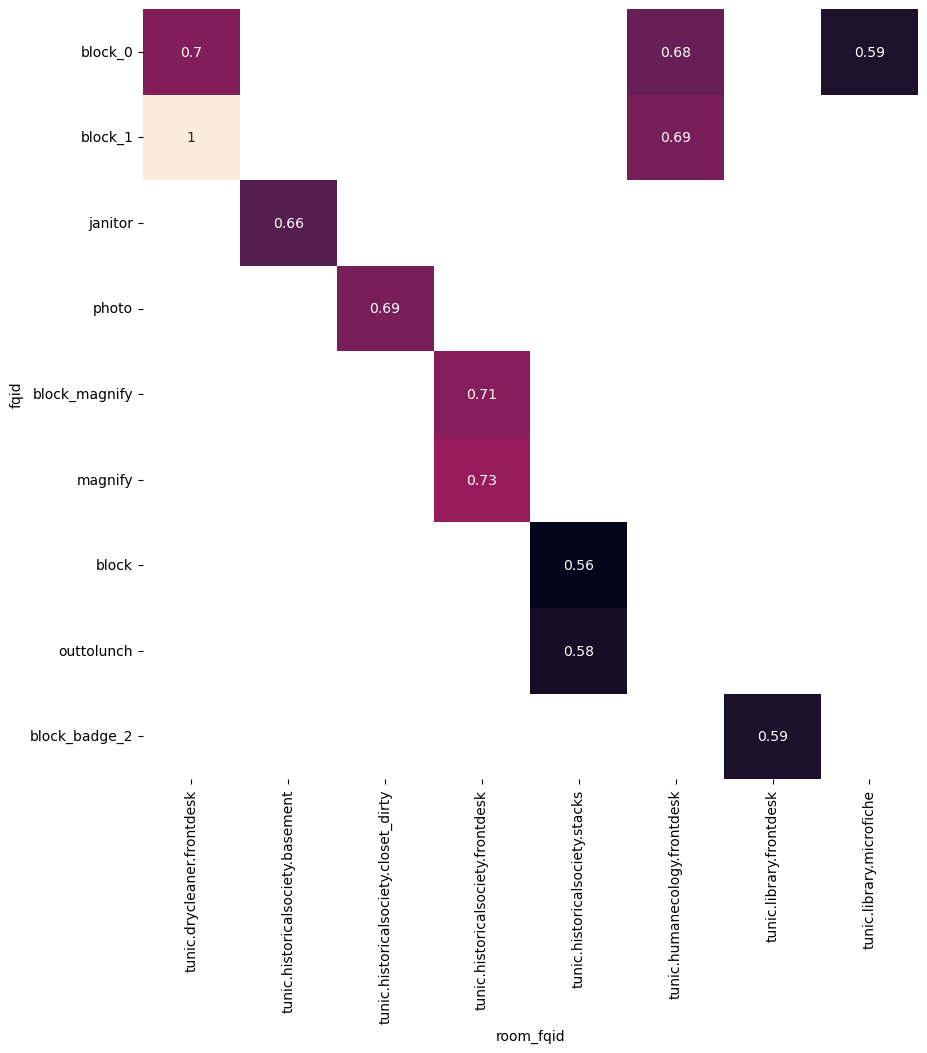

In [97]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

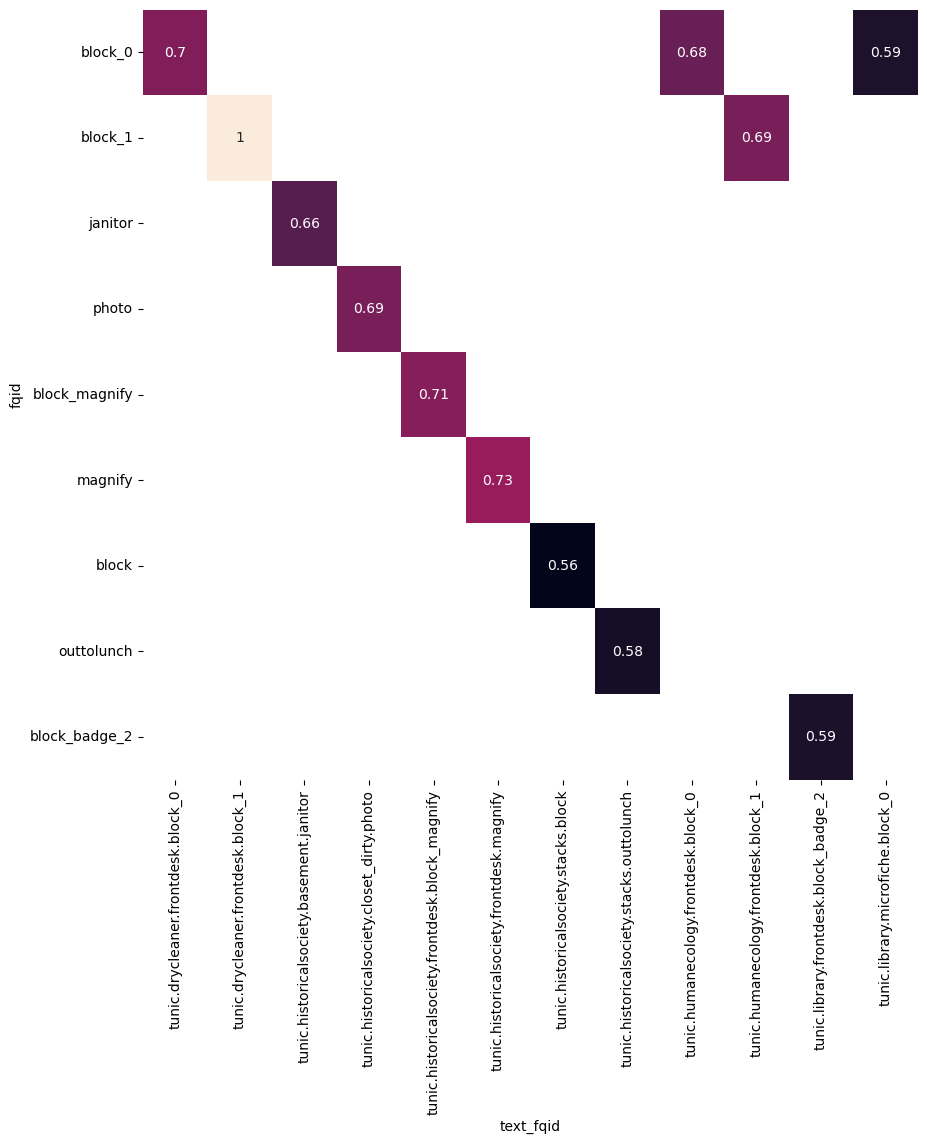

In [98]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

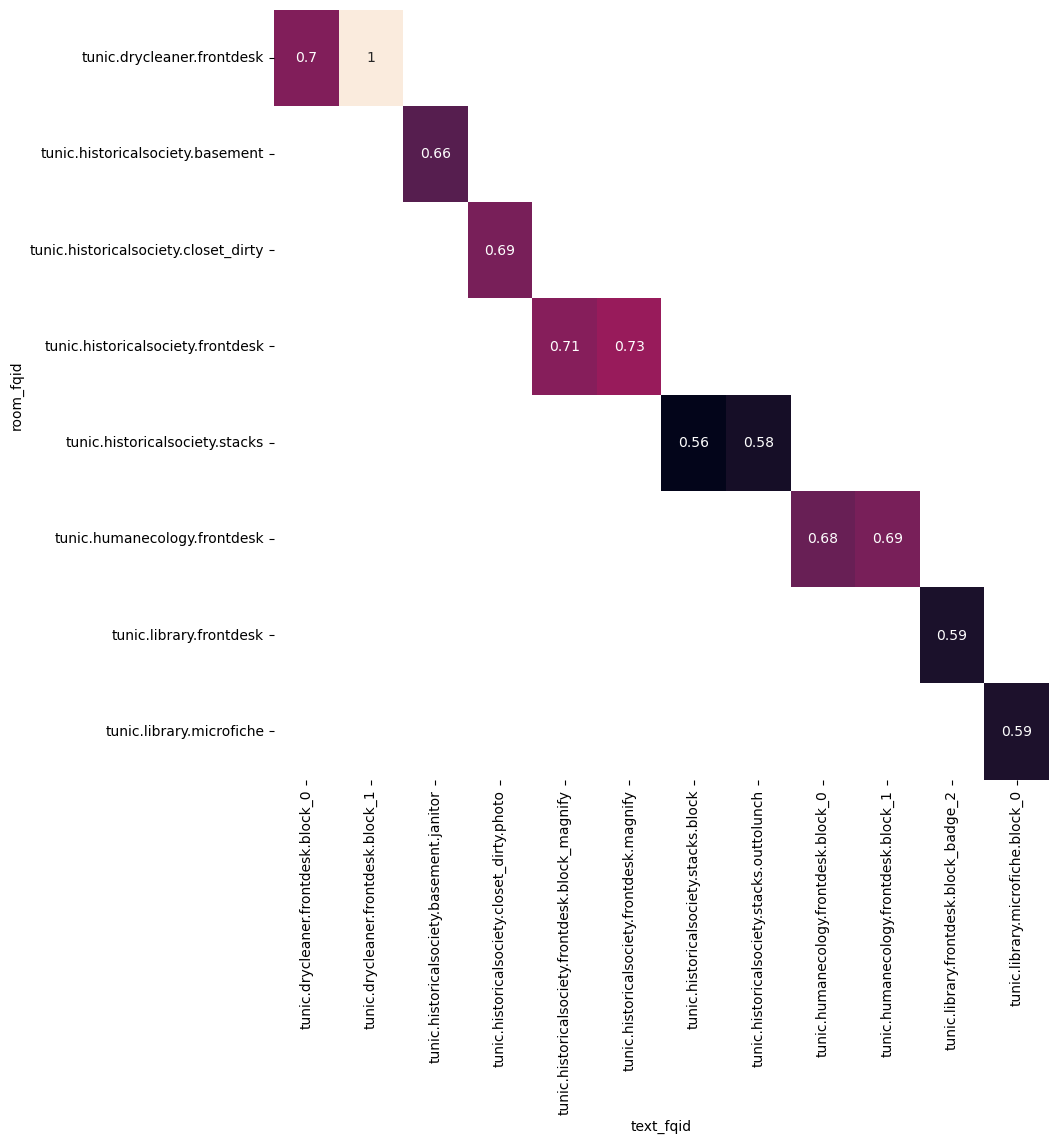

In [99]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

## `event_name` == `"person_click"`

In [100]:
df__person_click = df[df["event_name"] == "person_click"].reset_index(drop=True)
df__person_click.head()

session_id  index  elapsed_time    event_name   name  level  page  \
0  20090312431273200    176        222334  person_click  basic    5.0   NaN   
1  20090312431273200    177        223251  person_click  basic    5.0   NaN   
2  20090312431273200    194        239167  person_click  basic    6.0   NaN   
3  20090312431273200    222        262132  person_click  basic    6.0   NaN   
4  20090312431273200    223        262516  person_click  basic    6.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0      273.000   -19.234375          649.0          321.0             NaN   
1      240.875  -228.250000          628.0          459.0             NaN   
2     -615.500    28.296875          312.0          269.0             NaN   
3     -716.500  -212.125000          192.0          509.0             NaN   
4     -725.000  -205.125000          196.0          502.0             NaN   

                                     text    fqid  \
0  What are you still doing here,  Jolie?    boss   
1    Go find your grampa and get to work!    boss   
2                Can you help me tidy up?  gramps   
3                 Who could've done this?  gramps   
4                  It must've been Wells.  gramps   

                              room_fqid  \
0                  tunic.capitol_0.hall   
1                  tunic.capitol_0.hall   
2  tunic.historicalsociety.closet_dirty   
3  tunic.historicalsociety.closet_dirty   
4  tunic.historicalsociety.closet_dirty   

                                           text_fqid fullscreen hq music  \
0             tunic.capitol_0.hall.boss.talktogramps          0  0     1   
1             tunic.capitol_0.hall.boss.talktogramps          0  0     1   
2  tunic.historicalsociety.closet_dirty.gramps.he...          0  0     1   
3   tunic.historicalsociety.closet_dirty.gramps.news          0  0     1   
4   tunic.historicalsociety.closet_dirty.gramps.news          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

#### Update Category Fields

In [101]:
df__person_click = recategorize_category_typed_fields(df__person_click)

In [102]:
summary = summarize_data_info(df__person_click)
summary

Data Shape: (2692117, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      3597   
elapsed_time       int32           0.0   1055703   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         8   
page             float16           1.0         0   
room_coor_x      float16           0.0     21206   
room_coor_y      float16           0.0     16541   
screen_coor_x    float16           0.0      4009   
screen_coor_y    float16           0.0      3092   
hover_duration   float32           1.0         0   
text            category           0.0       167   
fqid            category           0.0         4   
room_fqid       category           0.0         7   
text_fqid       category           0.0        26   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                           first_value  \
session_id                           20090312431273200   
index                                              176   
elapsed_time                                    222334   
event_name                                person_click   
name                                             basic   
level                                              5.0   
page                                               NaN   
room_coor_x                                      273.0   
room_coor_y                                 -19.234375   
screen_coor_x                                    649.0   
screen_coor_y                                    321.0   
hover_duration                                     NaN   
text            What are you still doing here,  Jolie?   
fqid                                              boss   
room_fqid                         tunic.capitol_0.hall   
text_fqid       tunic.capitol_0.hall.boss.talktogramps   
fullscreen                                           0   
hq                                                   0   
music                                                1   
correct                                              1   

                                          second_value  \
session_id                           20090312431273200   
index                                              177   
elapsed_time                                    223251   
event_name                                person_click   
name                                             basic   
level                                              5.0   
page                                               NaN   
room_coor_x                                    240.875   
room_coor_y                                    -228.25   
screen_coor_x                                    628.0   
screen_coor_y                                    459.0   
hover_duration                                     NaN   
text              Go find your grampa and get to work!   
fqid                                              boss   
room_fqid                         tunic.capitol_0.hall   
text_fqid       tunic.capitol_0.hall.boss.talktogramps   
fullscreen                                           0   
hq                                                   0   
music                                                1   
correct                                              1   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                         194   
elapsed_time                                               239167   
event_name                                           person_click   
name                                                        basic   
level                                                         6.0   
p

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

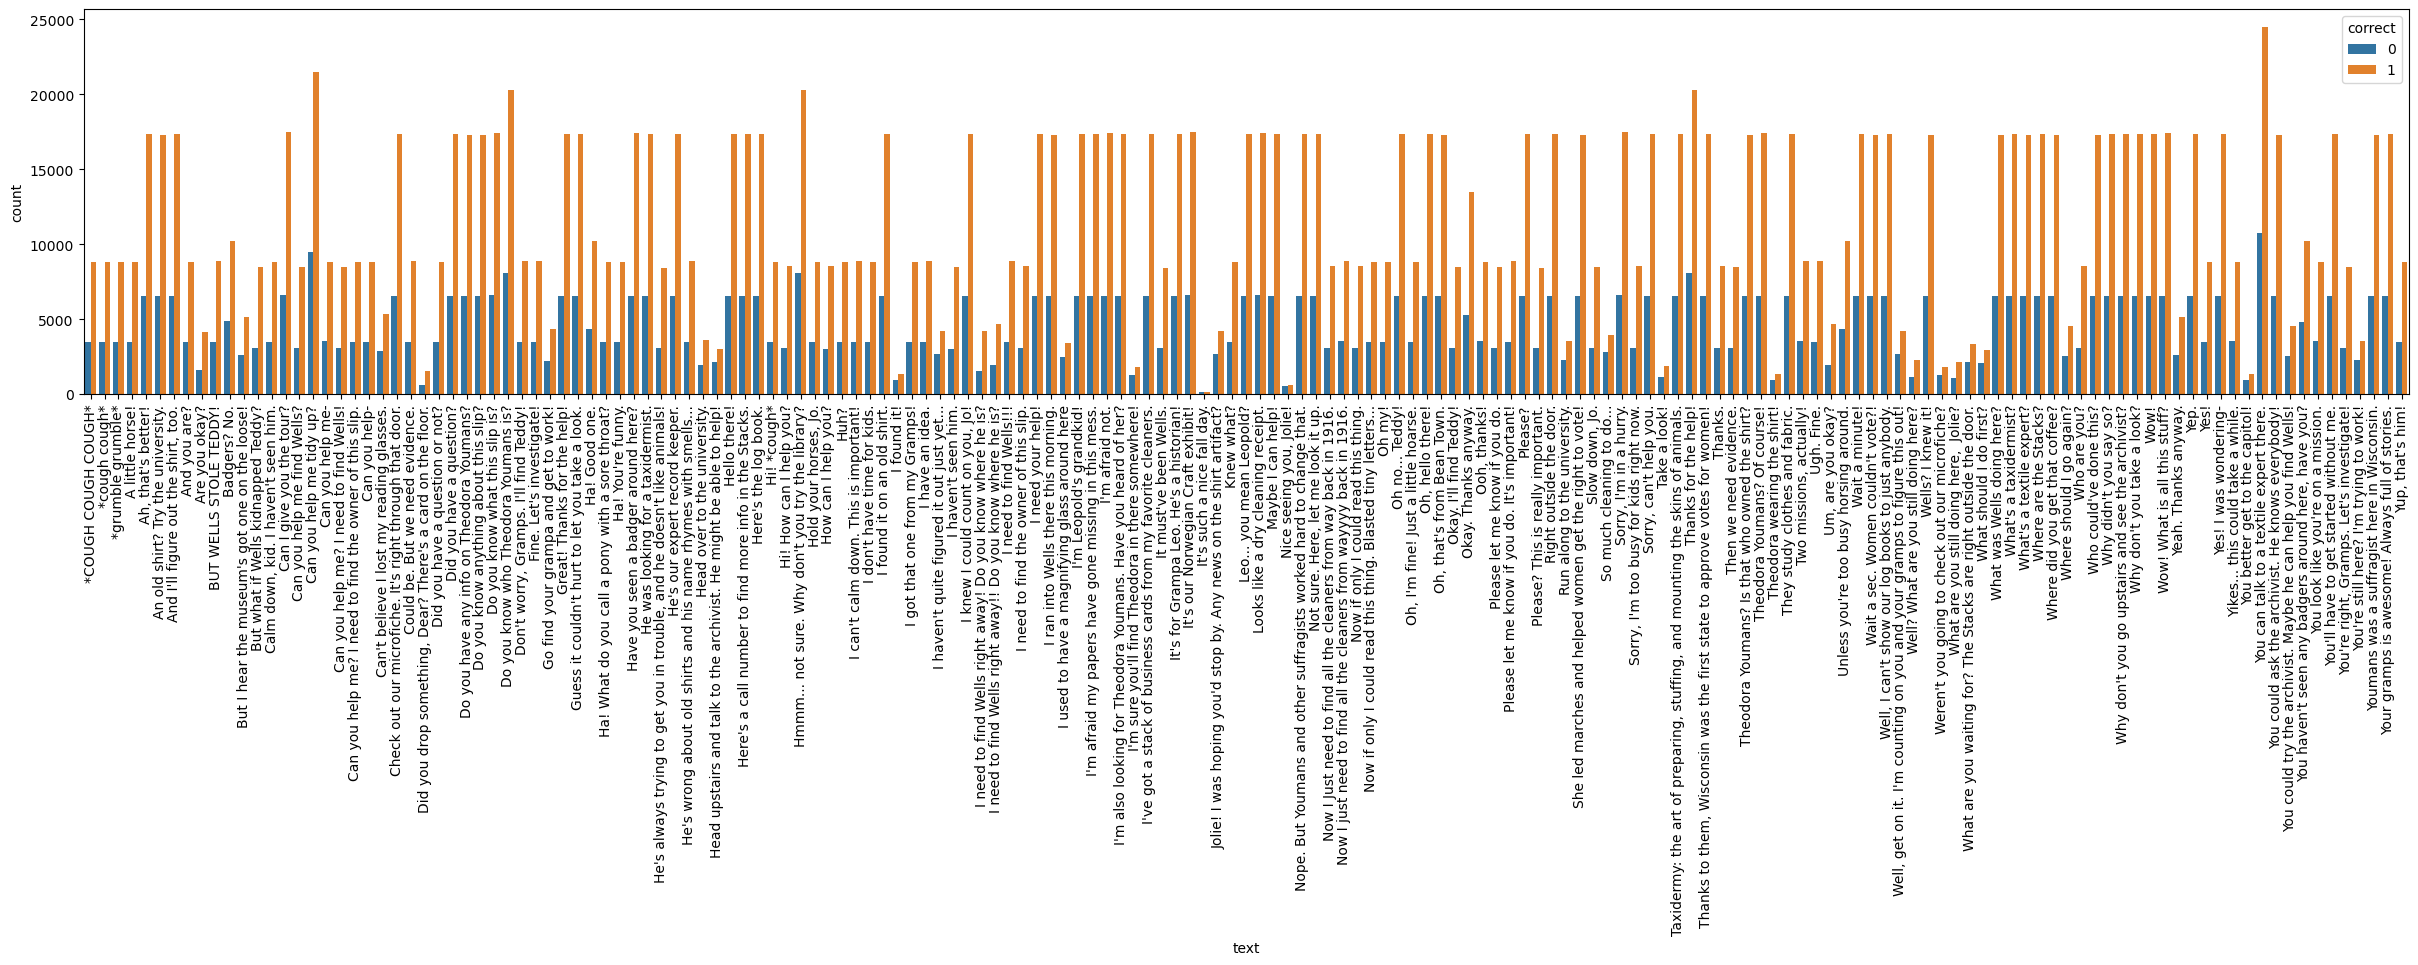

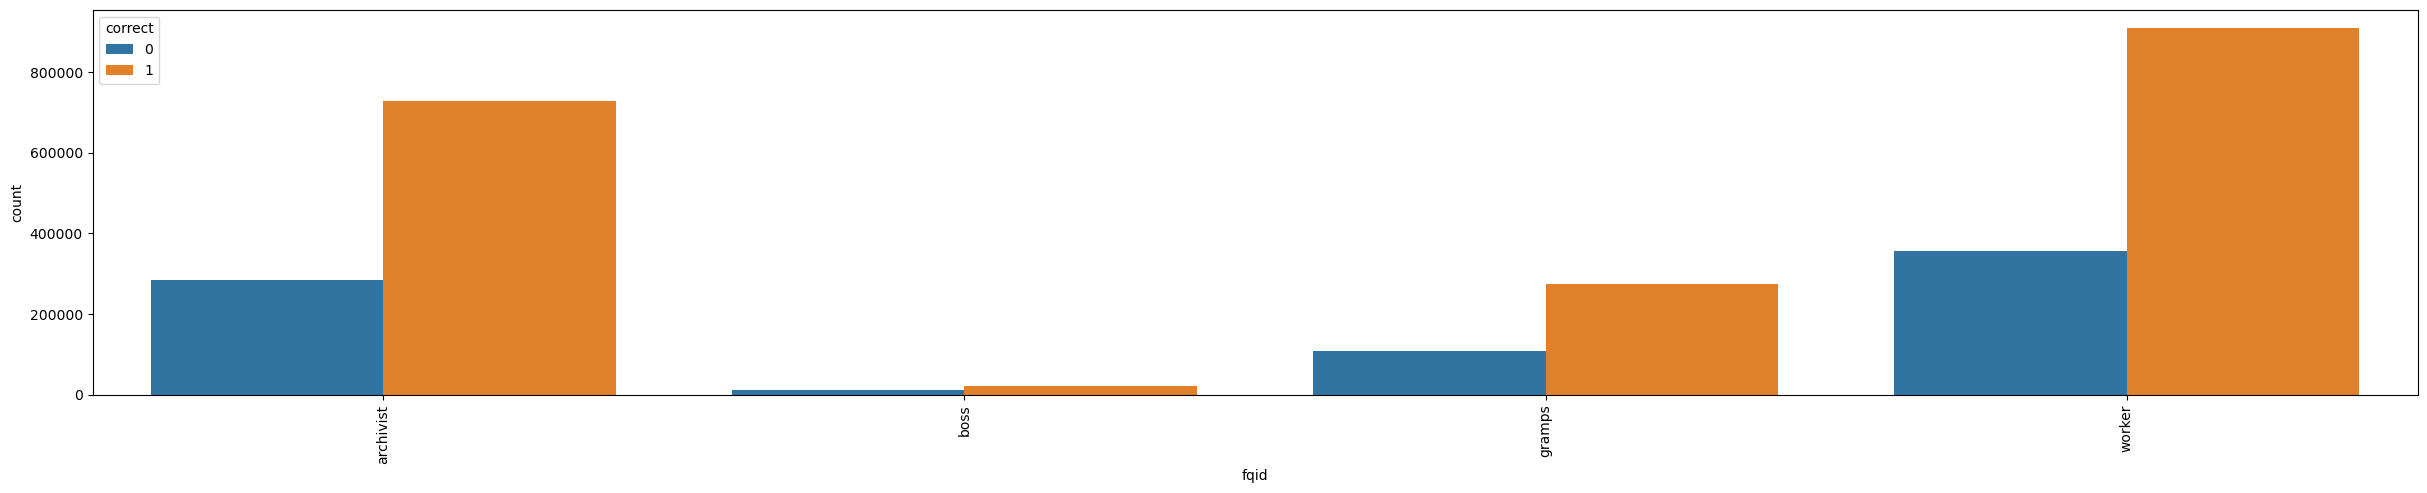

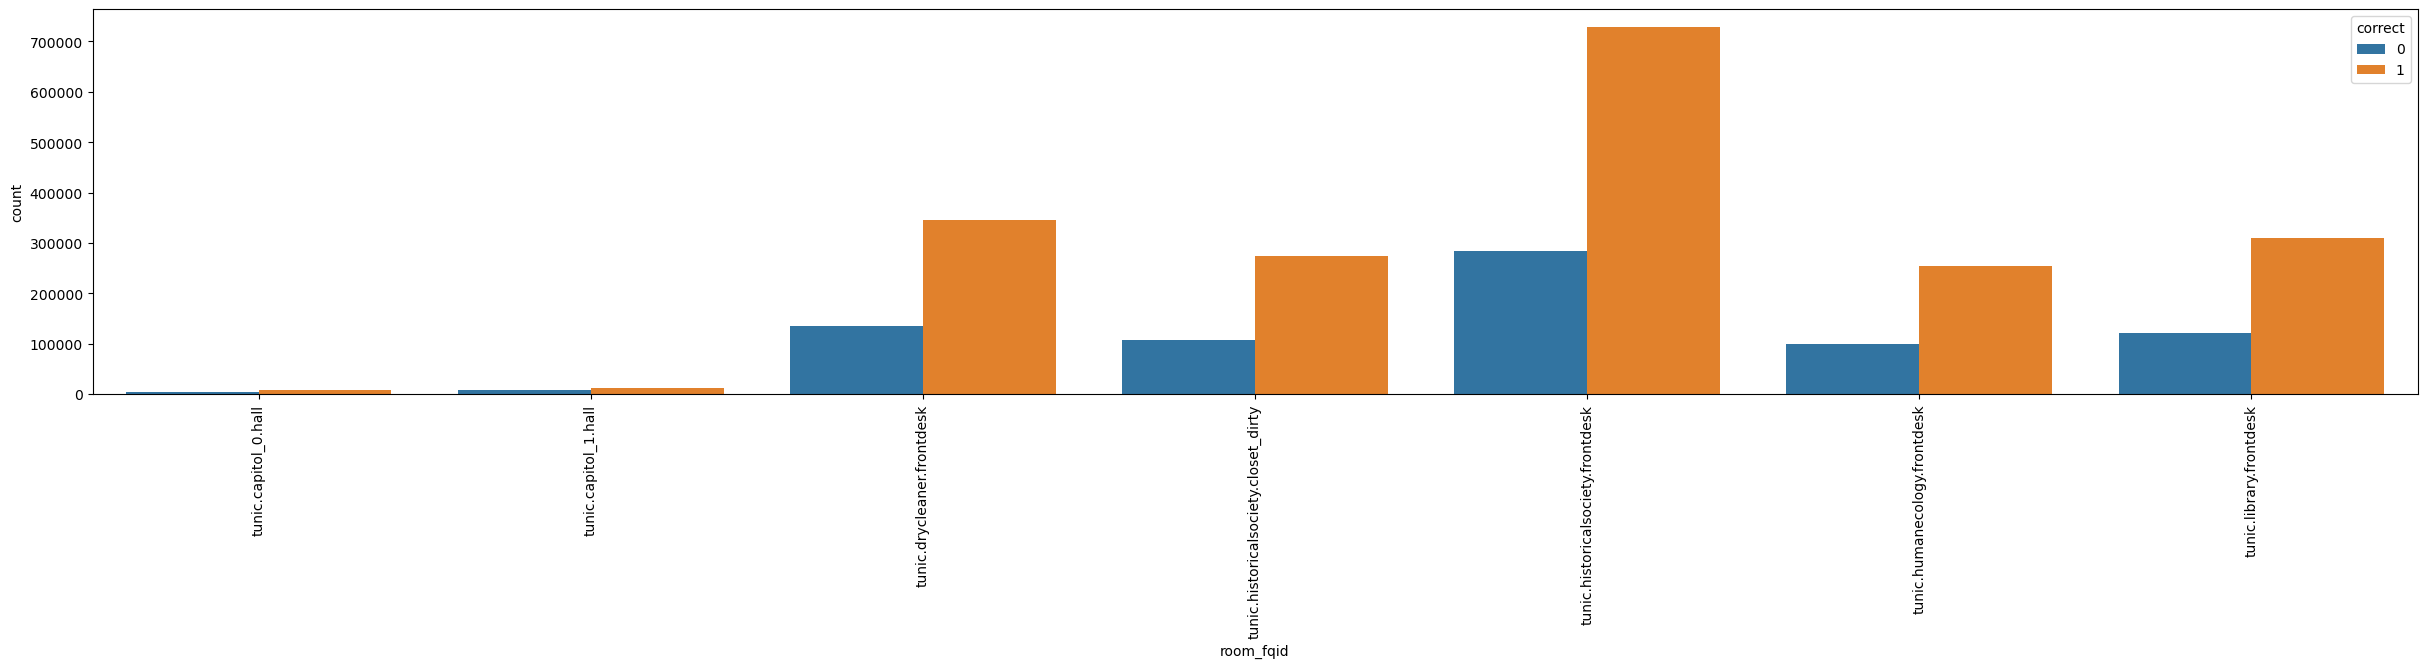

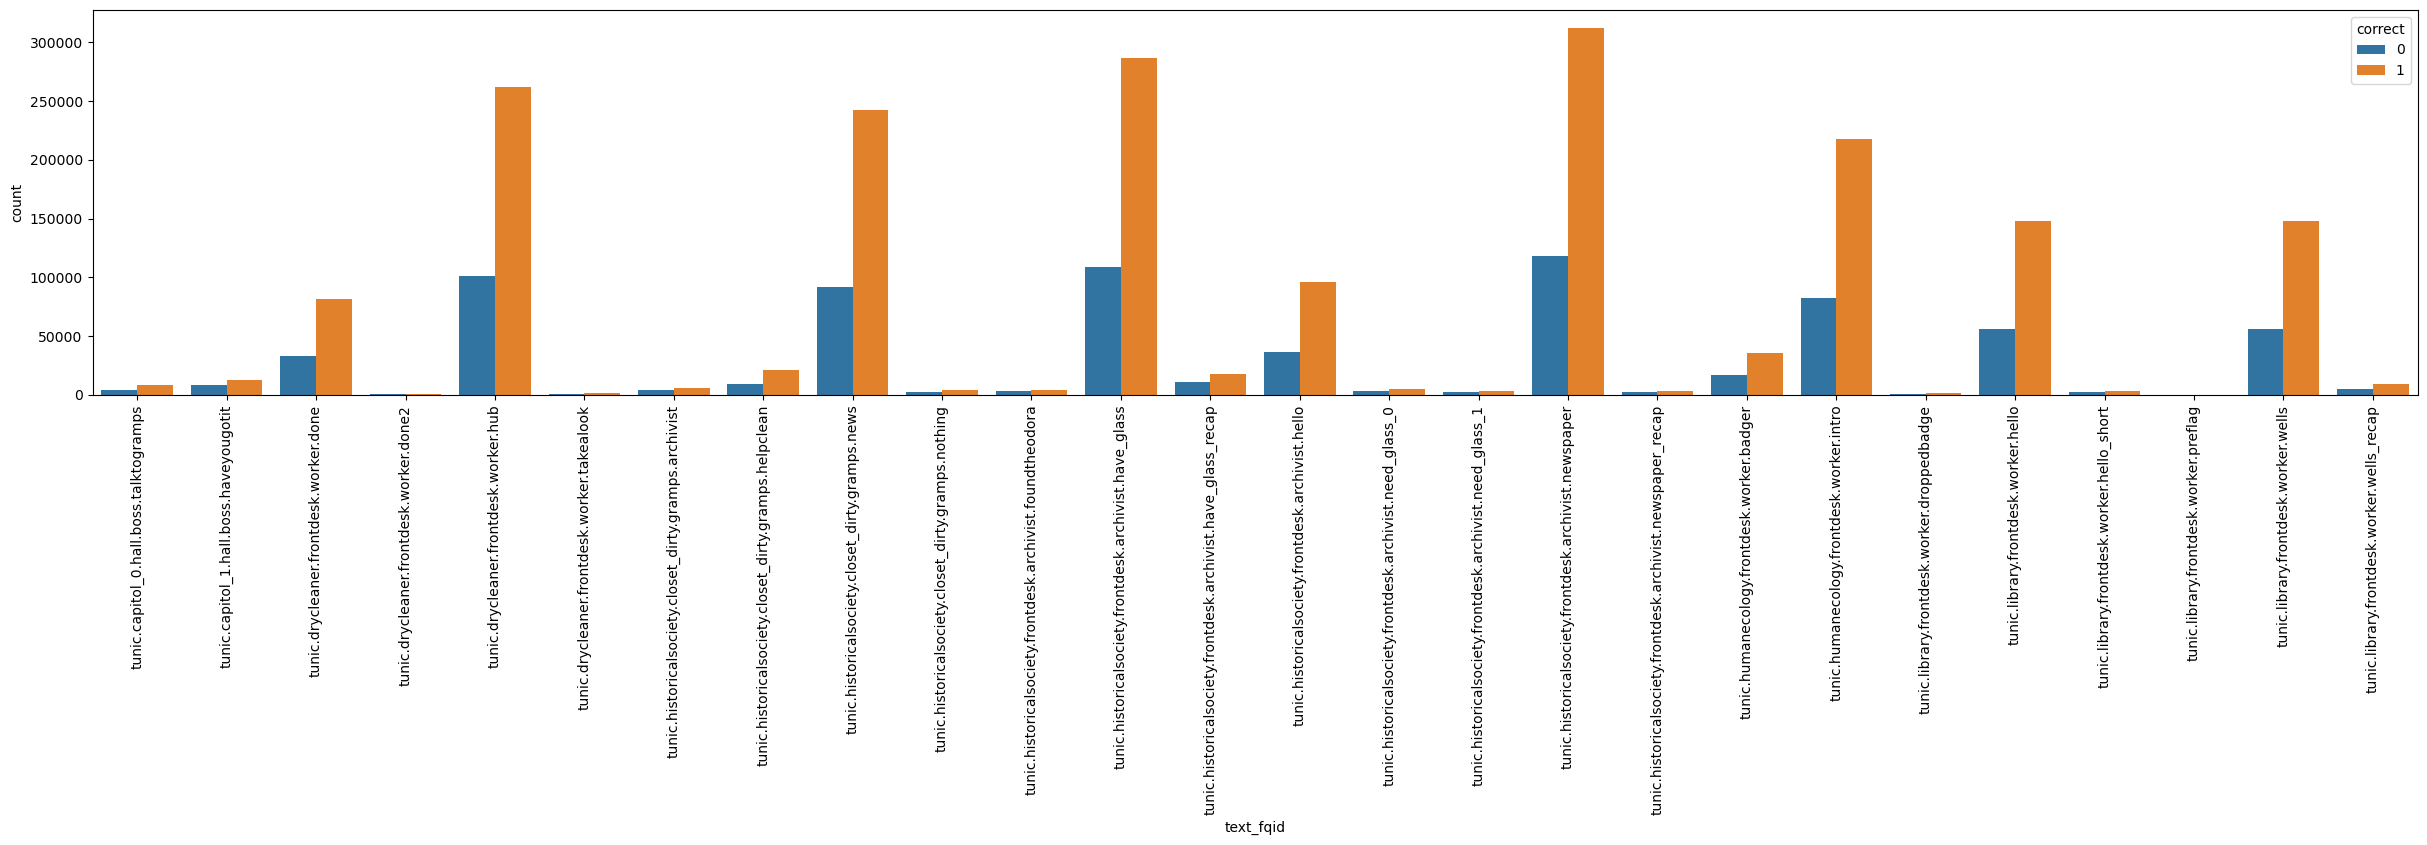

In [103]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.countplot(data=df__person_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

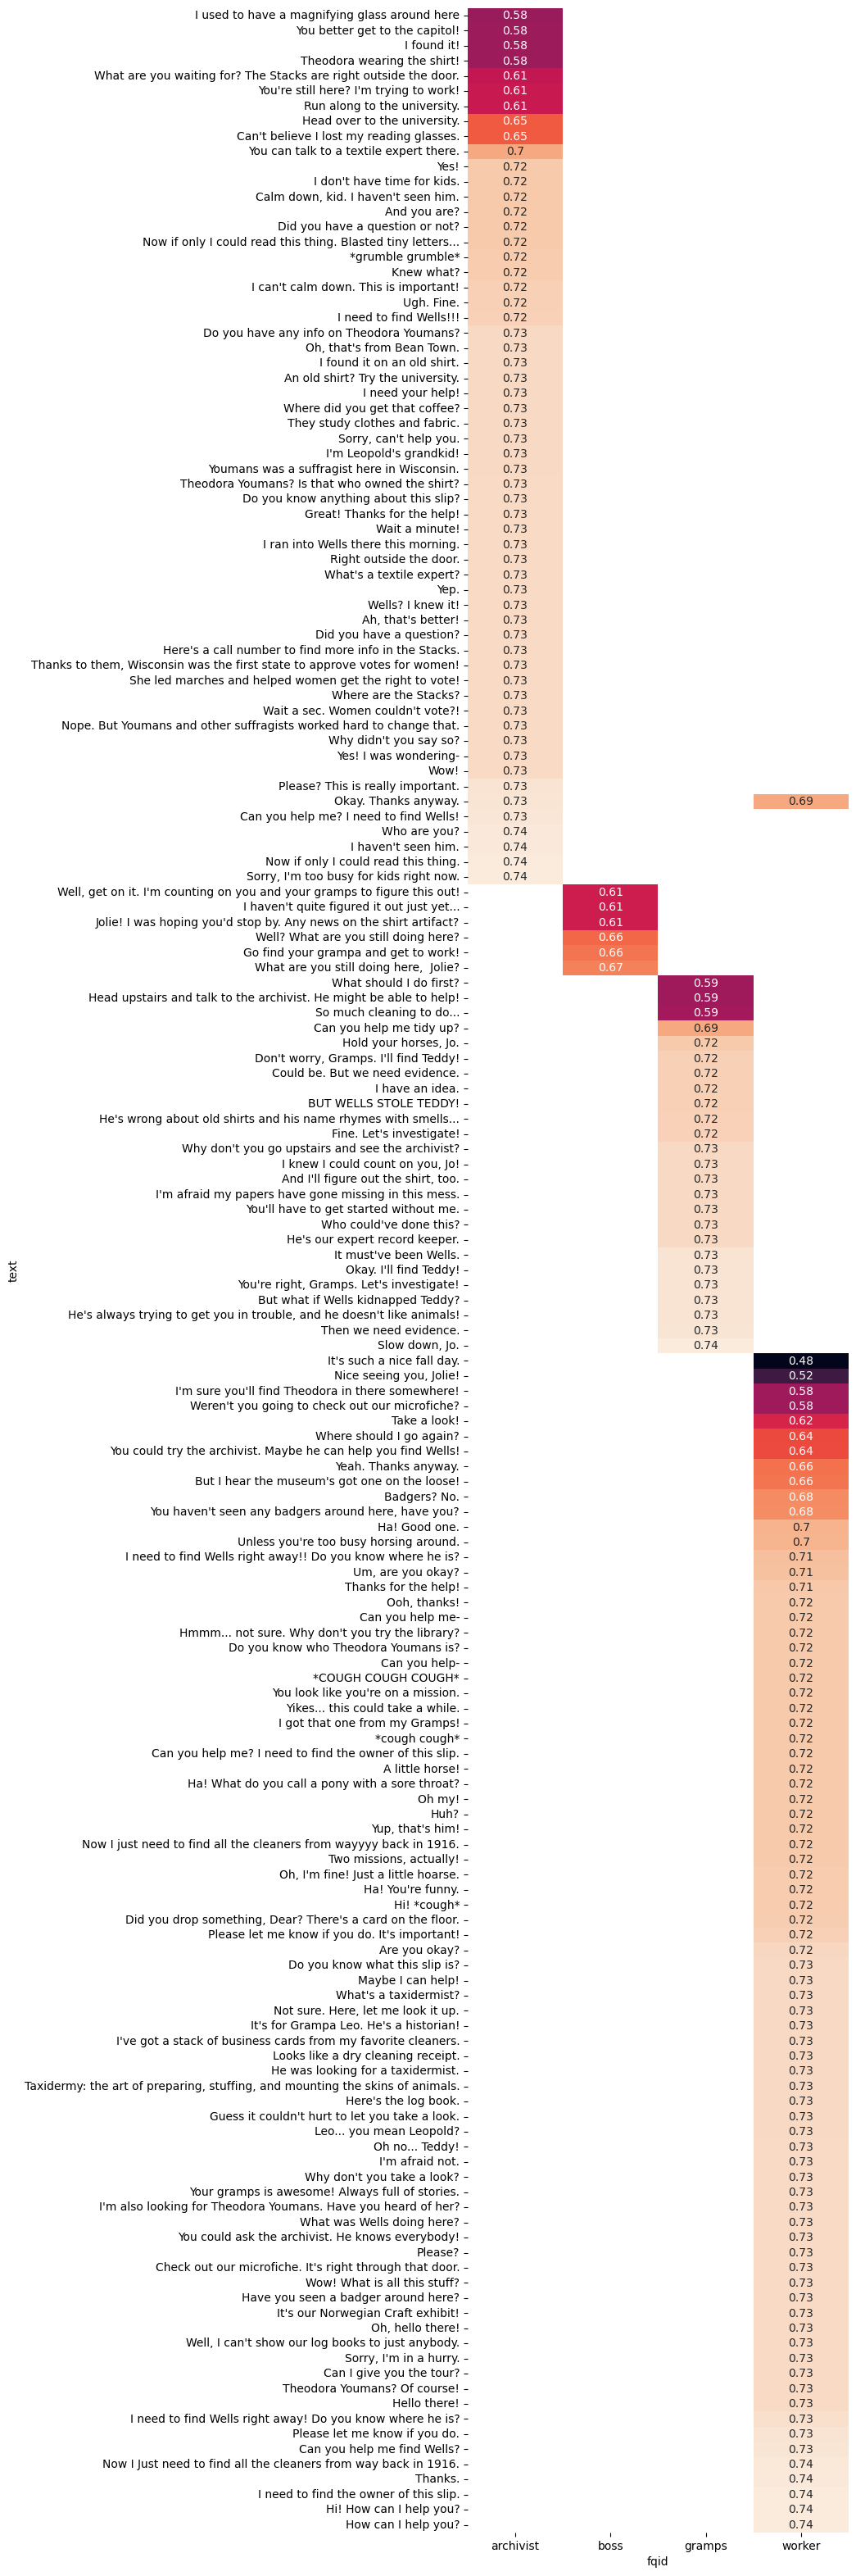

In [104]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(6, 40))

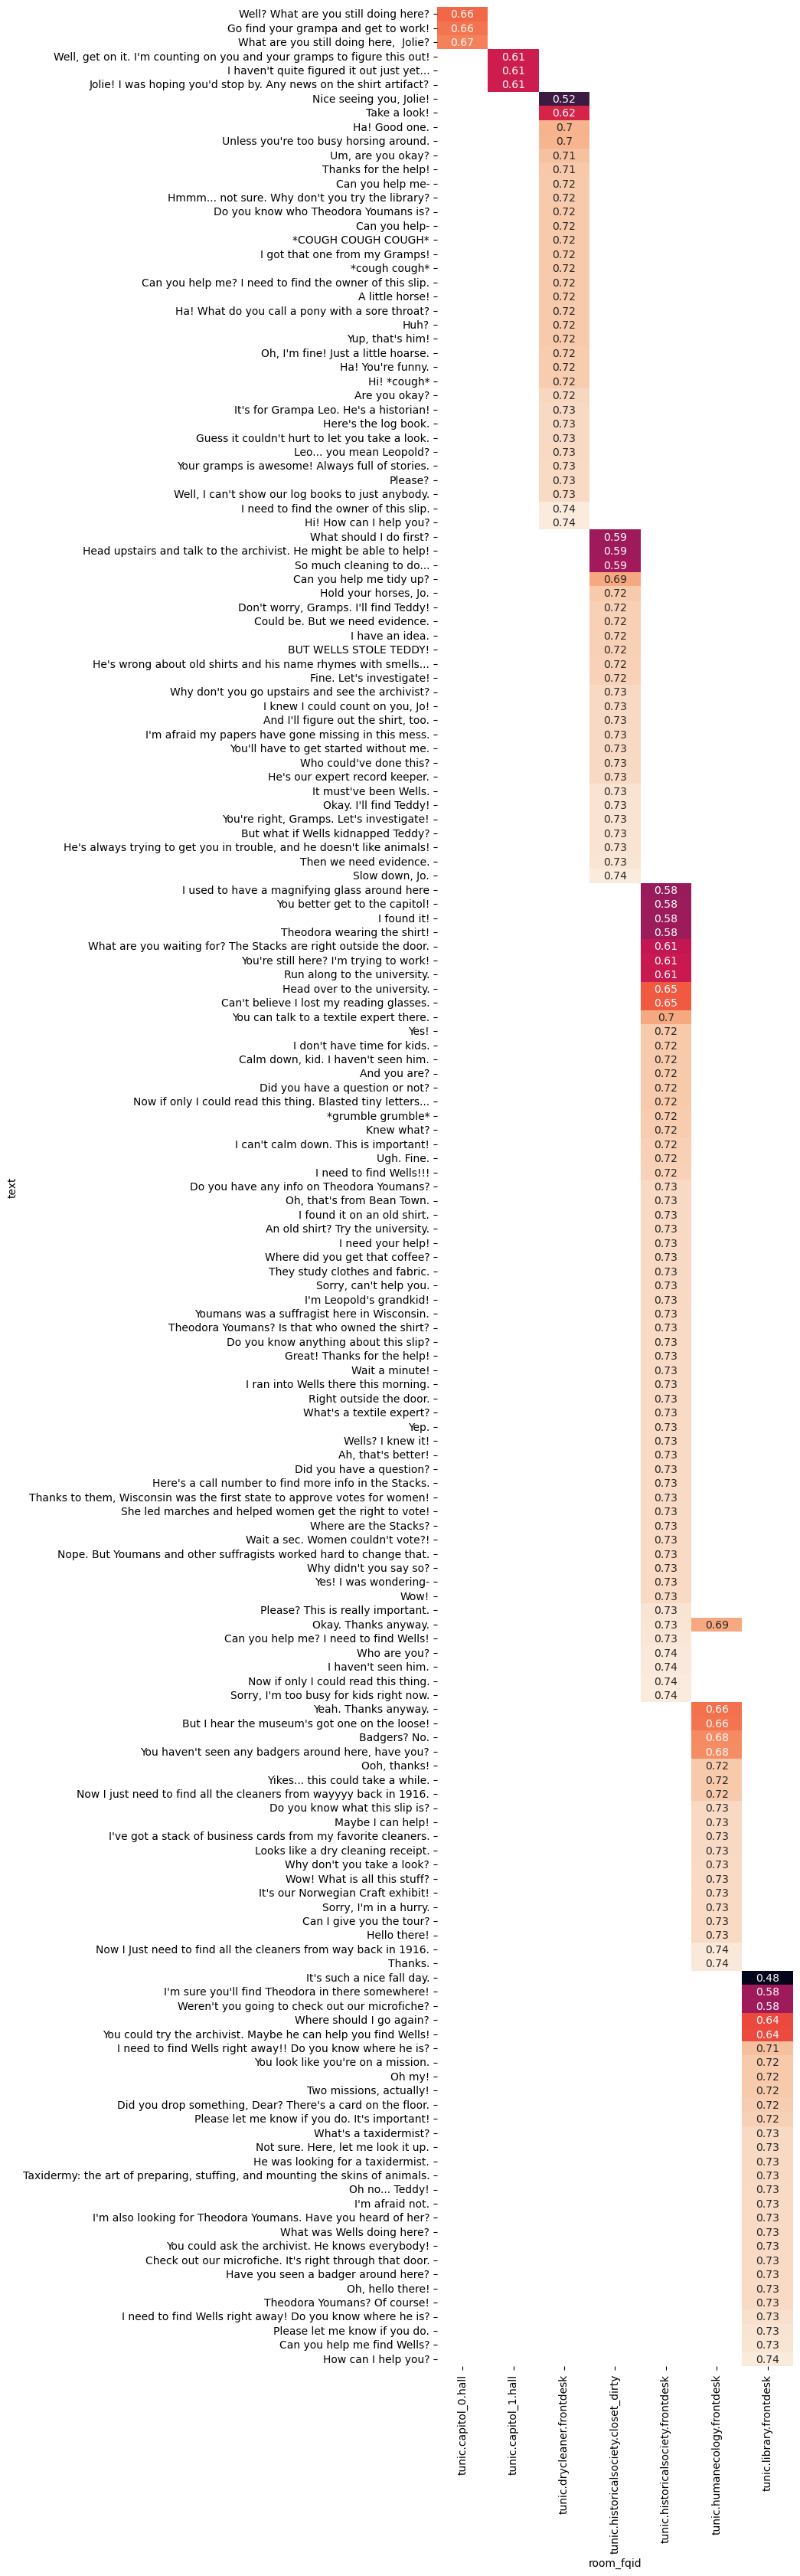

In [105]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(6, 40))

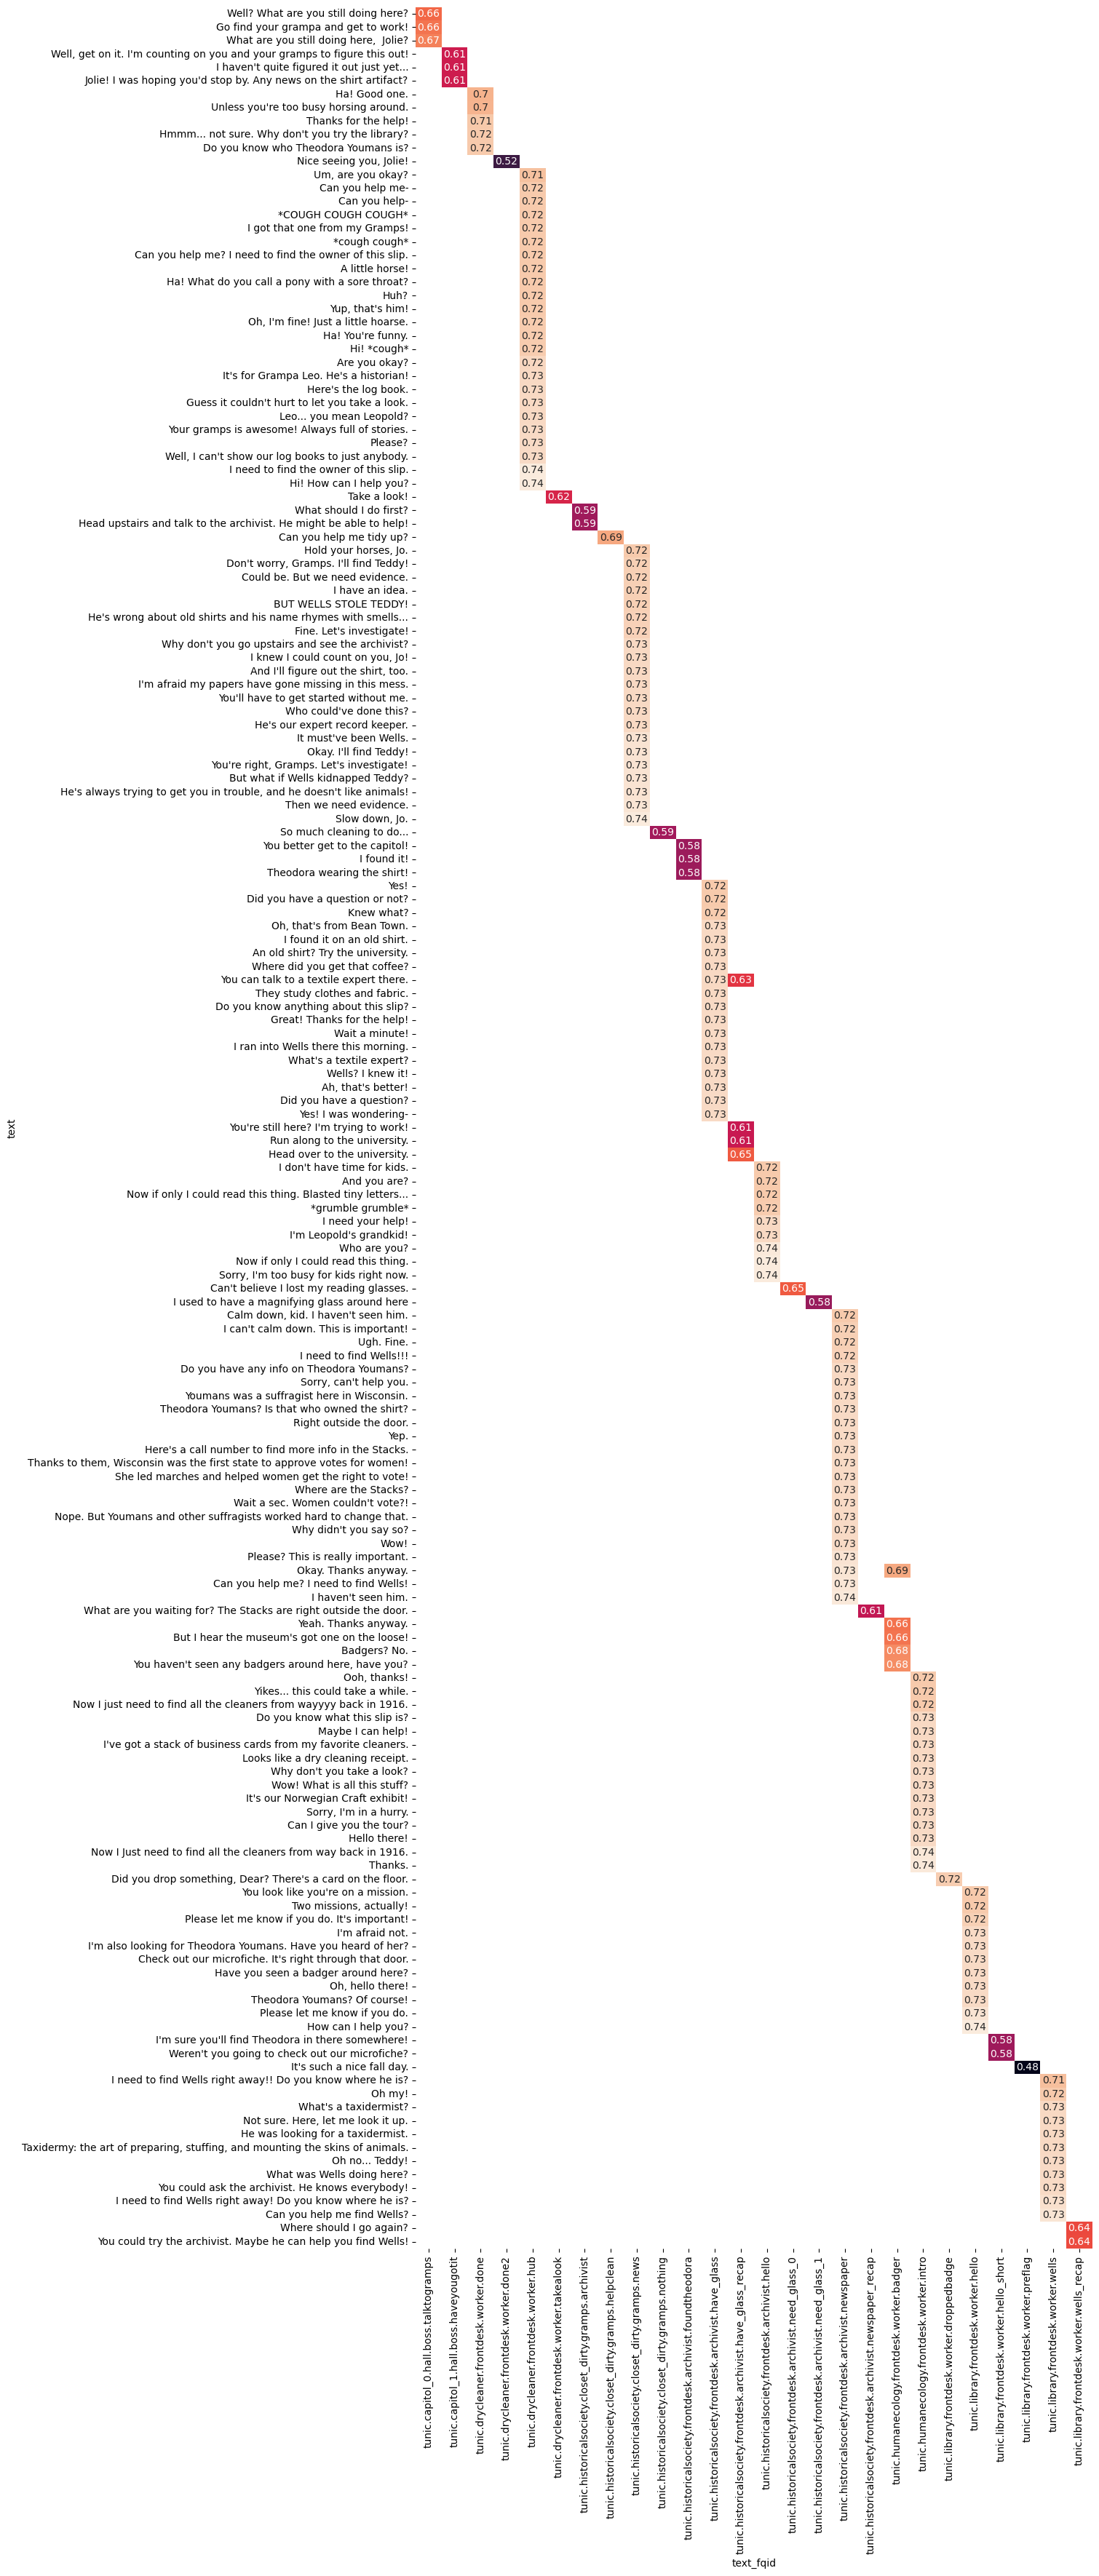

In [106]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(12, 40))

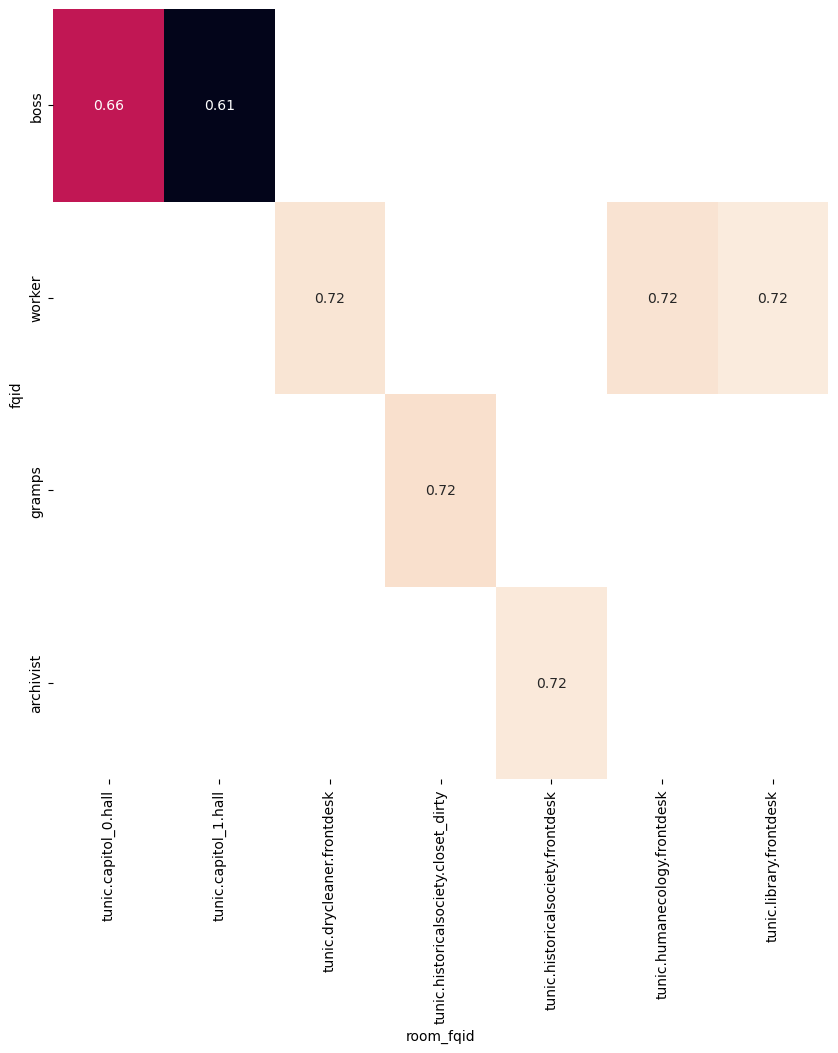

In [107]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(10, 10))

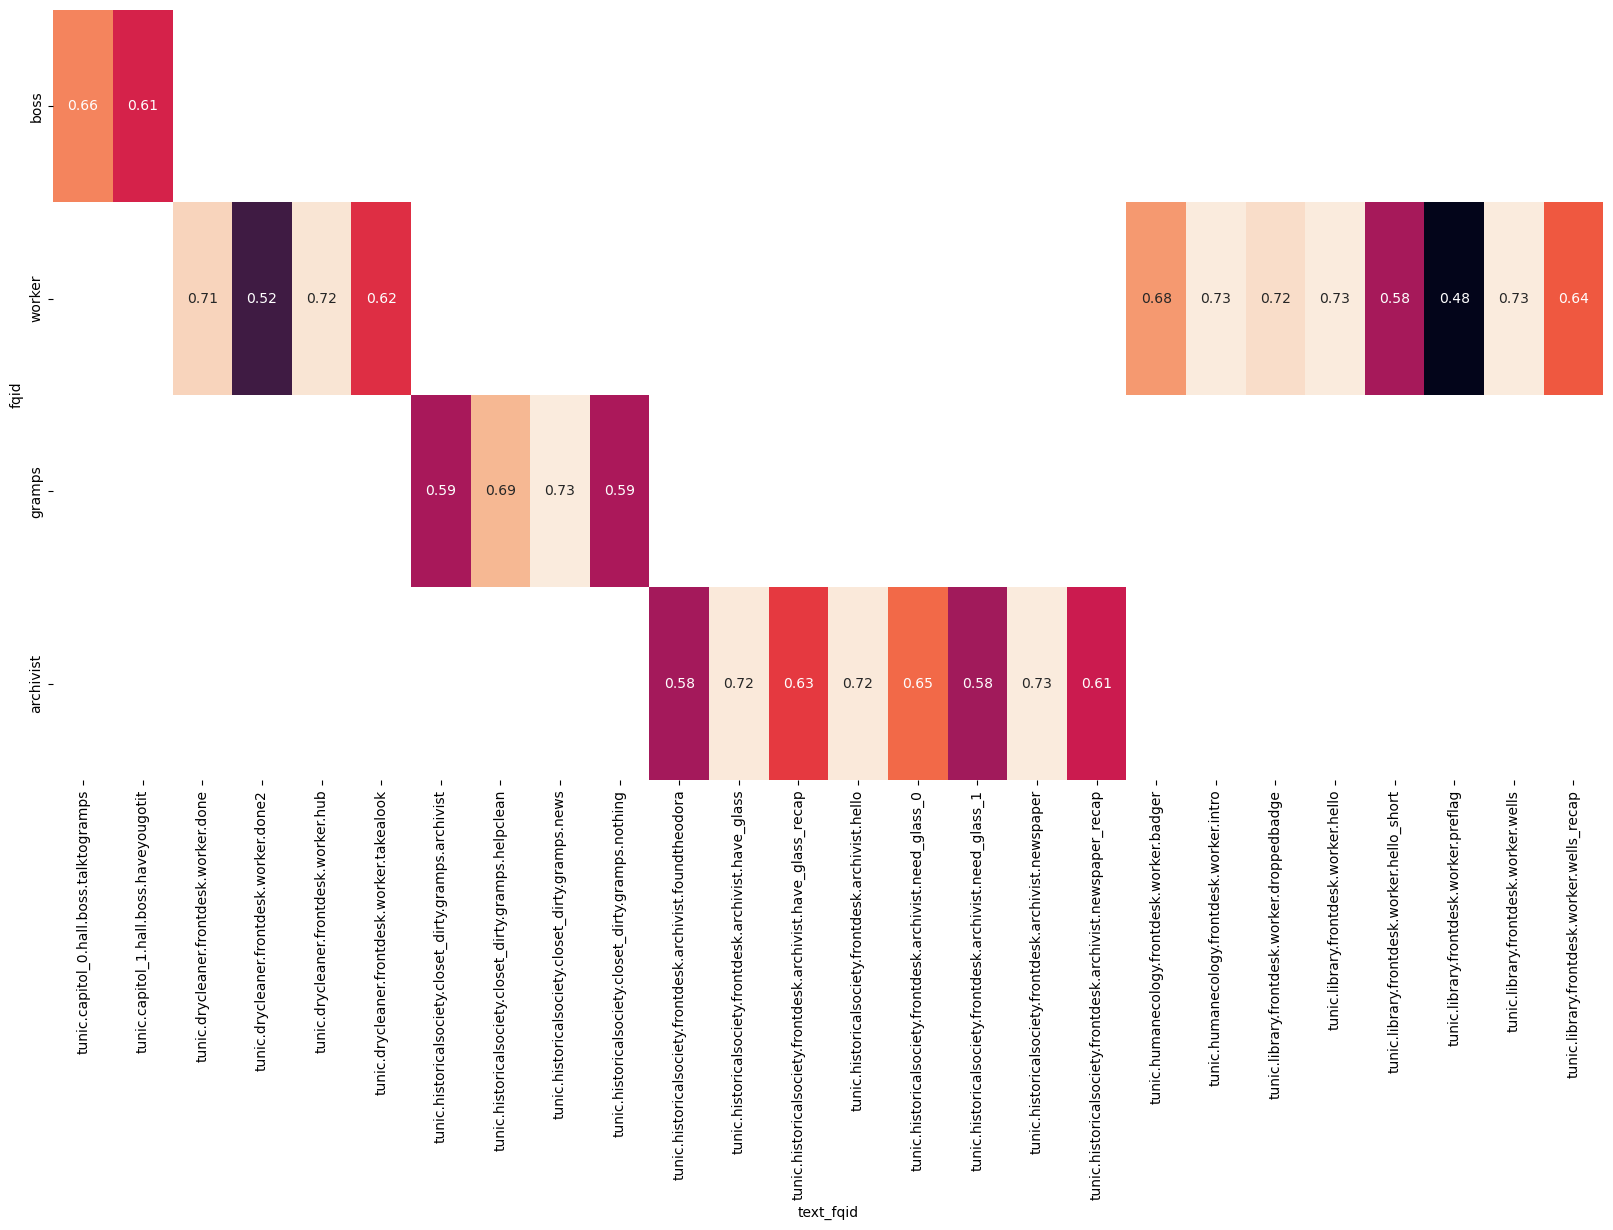

In [108]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(20, 10))

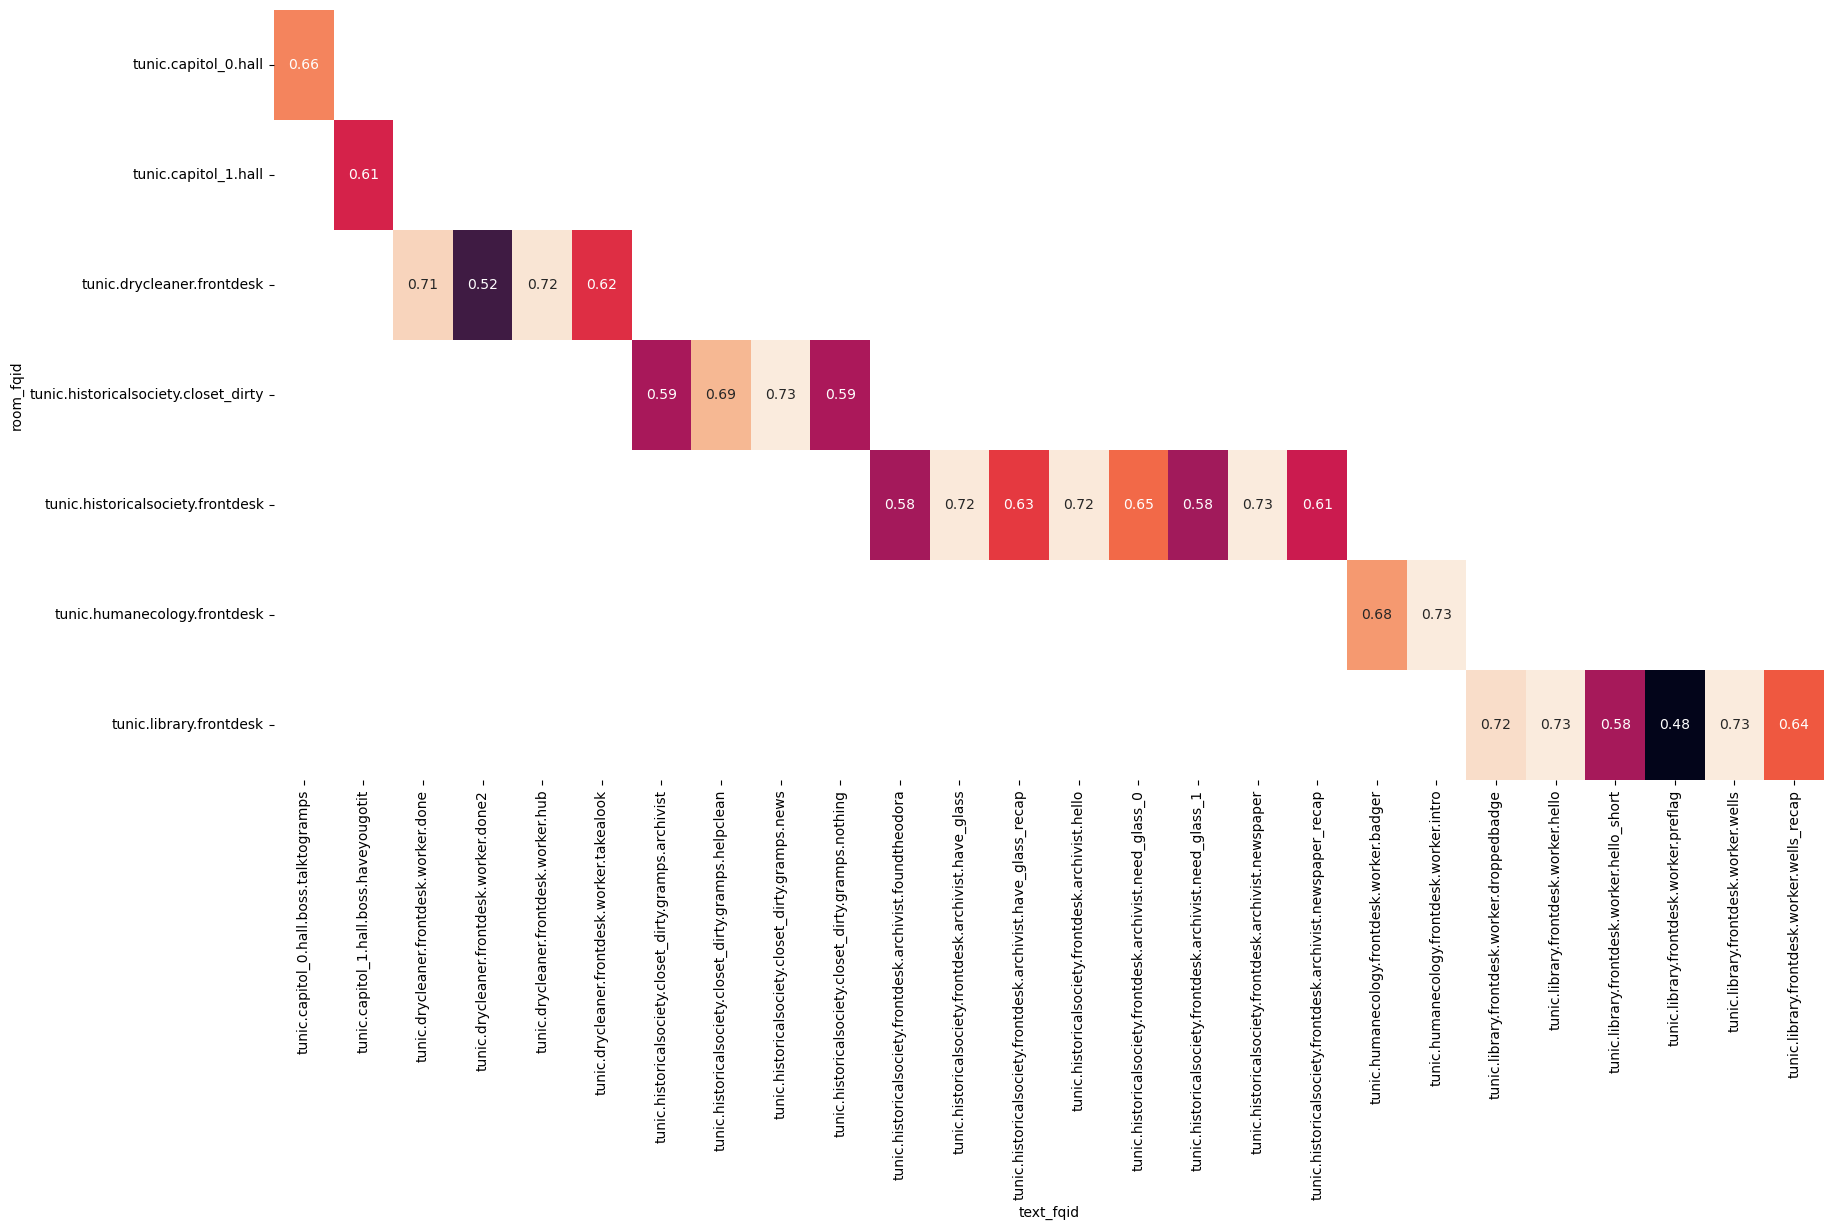

In [109]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(20, 10))